In [ ]:
### Proyecto de la asignatura Tratamiento de Datos realizado por Calin Cristian Dinga Pastae (100451528) y Víctor Díez Rozas (100451534) ###

## 0) Descargar e importar

In [ ]:
# Descargar el modelo de SpaCy. En este caso se escoge el modelo grande en lengua
# inglesa porque el corpus se encuentra en este idioma.
!python -m spacy download en_core_web_lg

# Descargar paquetes (necesarios para los puntos 5 y 6)
!pip install evaluate
!pip install rouge
!pip install bert_score

# Importar las librerías necesarias
import evaluate
import gensim
from gensim.matutils import corpus2dense
from gensim.models import TfidfModel, Word2Vec
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from rouge import Rouge
from transformers import BertForSequenceClassification, BertModel, BertTokenizer, pipeline, TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fs

## 1) Análisis de variables de entrada. Visualice la relación entre la variable de salida y algunas de las categorías en la variable 'categories' y explique su potencial relevancia en el problema.



In [ ]:
# Importar el corpus en formato DataFrame
corpus_in_df = pd.read_json('full_format_recipes.json')

In [ ]:
# Ejemplo: segunda muestra del corpus
print("\n# Directions: instrucciones para hacer la receta.")
print(f"** Tipo de dato: {type(corpus_in_df['directions'][1])}.\n** Contenido: {corpus_in_df['directions'][1]}")
print("\n# Categories: distintas categorías que se asignan al plato.")
print(f"** Tipo de dato: {type(corpus_in_df['categories'][1])}.\n** Contenido: {corpus_in_df['categories'][1]}")
print("\n# Desc: descripción.")
print(f"** Tipo de dato: {type(corpus_in_df['desc'][1])}.\n** Contenido: {corpus_in_df['desc'][1]}")
print("\n# Title: título de la publicación.")
print(f"** Tipo de dato: {type(corpus_in_df['title'][1])}.\n** Contenido: {corpus_in_df['title'][1]}")
print("\n# Rating: puntuación dada por usuarios.")
print(f"** Tipo de dato: {type(corpus_in_df['rating'][1])}.\n** Contenido: {corpus_in_df['rating'][1]}")
print("\n# Fat: cantidad de grasa en gramos.")
print(f"** Tipo de dato: {type(corpus_in_df['fat'][1])}.\n** Contenido: {corpus_in_df['fat'][1]}")
print("\n# Protein: cantidad de proteínas en gramos.")
print(f"** Tipo de dato: {type(corpus_in_df['protein'][1])}.\n** Contenido: {corpus_in_df['protein'][1]}")
print("\n# Calories: cantidad de calorías en gramos.")
print(f"** Tipo de dato: {type(corpus_in_df['calories'][1])}.\n** Contenido: {corpus_in_df['calories'][1]}")
print("\n# Sodium: cantidad de sodio en gramos.")
print(f"** Tipo de dato: {type(corpus_in_df['sodium'][1])}.\n** Contenido: {corpus_in_df['sodium'][1]}")
print("\n# Ingredients: cantidad de cada ingrediente.")
print(f"** Tipo de dato: {type(corpus_in_df['ingredients'][1])}.\n** Contenido: {corpus_in_df['ingredients'][1]}")
print("\n# Date: fecha de publicación.")
print(f"** Tipo de dato: {type(corpus_in_df['date'][1])}.\n** Contenido: {corpus_in_df['date'][1]}")


# Directions: instrucciones para hacer la receta.
** Tipo de dato: <class 'list'>.
** Contenido: ['Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and let stand 30 minutes. Chill overnight.', 'Preheat oven to 325°F. Line 7-cup pâté or bread pan with plastic wrap. Melt butter in heavy small skillet over low heat. Add remaining 5 shallots. Cover and cook until very soft, stirring occasionally, about 15 minutes. Transfer to processor. Add pork, eggs, flour and Port and puree. Strain cream mixture, pressing on solids to extract as much liquid as possible. With processor running, add cream through feed tube and process just until combined with pork. Transfer to large bowl. Mix in currants.', 'Spoon mixture into prepared pan. Cover with foil. Place pan in large pan. Add boiling water to larger pan to within 1/2 inch of top of terrine. Bake until terrine begins to shrink from sides of pan and knife inserted into center comes out 

In [ ]:
# Eliminar muestras que no tengan 'categories' ni 'rating'
corpus_to_analyse_in_df = corpus_in_df.dropna(subset=['categories', 'rating'])

# Expandir las categorías en filas individuales usando explode
expanded_df = corpus_to_analyse_in_df.explode('categories')

# Crear el DataFrame final con las columnas 'categories' y 'rating'
category_ratings_df = expanded_df[['categories', 'rating']]

# Mostrar el número total de categorías
print(f"El número total de categorías es: {category_ratings_df['categories'].nunique()}\n")

# Contar el número de veces que aparece cada categoría
category_counts = category_ratings_df['categories'].value_counts()

# Filtrar las categorías que más se repiten (e.g., las 400 más frecuentes)
most_frequent_categories = category_counts.head(400).index

# Filtrar el DataFrame para trabajar solo con las categorías más frecuentes
filtered_category_ratings_df = category_ratings_df[category_ratings_df['categories'].isin(most_frequent_categories)]

# Calcular la media de 'rating' para cada una de las categorías más frecuentes
category_mean_ratings = filtered_category_ratings_df.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Mostrar las 25 mejores categorías
print(f"\nLas veinticinco mejores categorías son:\n{category_mean_ratings.head(25)}")

# Mostrar las 25 peores categorías
print(f"\nLas veintinco peores categorías son:\n{category_mean_ratings.tail(25)}")

El número total de categorías es: 674


Las veinticinco mejores categorías son:
categories
Lamb Chop                   4.388889
Ground Lamb                 4.339286
Marsala                     4.305556
Brisket                     4.276316
Beef Tenderloin             4.262153
Stuffing/Dressing           4.257246
Pork Tenderloin             4.255208
Game                        4.236111
Kentucky Derby              4.218750
Beef Rib                    4.207589
Trout                       4.155093
Rosh Hashanah/Yom Kippur    4.145221
Brussel Sprout              4.140625
Pork Rib                    4.133772
Meat                        4.133772
Bok Choy                    4.131356
Braise                      4.130682
Molasses                    4.129464
Goat Cheese                 4.120521
Low Carb                    4.116736
New Year's Day              4.115854
Lunar New Year              4.103261
Fig                         4.103084
Pomegranate                 4.099026
Steak                

- El objetivo del proyecto es desarrollar un modelo de regresión que, a partir de las características de una receta de cocina (e.g., sus instrucciones), prediga la valoración dada por un usuario.

- Las características disponibles son: instrucciones, categorías, descripción, título, cantidad de grasa, cantidad de proteínas, cantidad de calorías, cantidad de sodio, ingredientes y fecha de publicación. Para determinar qué características se deben emplear en el modelo de regresión, se analiza la relación entre la característica ```categories``` y ```rating```.

- Los pasos para realizar el análisis son:

  1) Eliminar recetas que contengan valores nulos en ```categories``` o ```rating```.
  
  2) Asociar a cada categoría su valoración.
  
  3) Contar el número de veces que aparece cada categoría.
  
  4) Filtrar las 400 categorías más frecuentes.
  
  5) Calcular la valoración media de las 400 categorías más frecuentes.
  
  6) Mostrar las 25 mejores y las 25 peores categorías valoradas.

- La celda anterior revela que las categorías con mejor ```rating``` están relacionadas con productos cárnicos (lamb chop, ground lamb, brisket, etc.) y con eventos/celebraciones (game, Kentucky derby, Rosh Hashanah/Yom Kippur, New Year's Day, etc.), mientras que las categorías con peor ```rating``` están relacionadas con bebidas alcohólicas (gin, bitters, spirit, alcoholic, etc.) y con otro tipo de bebidas (lime juice, tea, etc.). Entonces, se puede concluir que el modelo de regresión hay que entrenarlo con datos que contengan el tipo de alimento o de bebida, y las celebraciones.

- En el enunciado se indica que se debe trabajar, como mínimo, con ```directions``` y/o ```desc```. En este caso se va a utilizar ```directions```. El motivo de omitir ```desc``` es que ```directions``` ya incluye toda la información sobre la receta, por lo que ```desc``` es contenido redundante.

- También se encuentran las características ```ingredients``` y ```title```. La primera tendría sentido utilizarla ya que, como se ha visto en la imagen, los ingredientes son el factor más influyente en el ```rating``` (e.g., la carne está mucho mejor calificada que las bebidas). Sin embargo, se ha descartado para evitar superar el umbral máximo de tokens proporcionado por BERT<sup>[1]</sup>. La característica ```title``` no se utiliza ya que es contenido redundante; la información brindada en el título ya se incluye en las instrucciones.

- La característica ```categories``` sí que se utiliza porque resulta útil para predecir el ```rating```, tal y como se ha visto antes.

- La característica ```date``` también se utiliza ya que, como se ha visto en la celda, las celebraciones influyen en el ```rating```. En concreto, se van a utilizar el día y el mes. Las horas, minutos, segundos, año y zona horaria no se consideran relevantes porque las festividades que se han visto se realizan todos los años, durante todo el día y en todas las regiones del planeta.

- Las características ```fat```, ```protein```, ```calories``` y ```sodium``` no parecen influir de manera significativa. Apenas se observan entre los valores máximos y mínimos de ```rating```. Por tanto, no se van a emplear para entrenar el modelo.

<sup>[1]</sup> Entre ```ingredients``` y ```directions``` se ha decidido utilizar ```directions``` porque en el enunciado se indica que esta última es de obligado uso. Además, cabe mencionar que al descartar ```ingredients``` no se suele perder excesiva cantidad de información ya que en ```directions``` suelen aparecer los ingredientes más relevantes.


## 2) Implementación de un pipeline para el preprocesado de los textos. Para esta tarea puede usar las librerías habituales (NLTK, Gensim o SpaCy), o cualquier otra librería que considere oportuna. Tenga en cuenta que para trabajar con transformers el texto se pasa sin preprocesar.

Antes de seguir, es importante mencionar que se ha reducido el número de recetas empleadas a 4000 porque las 20130 recetas suponían un elevado coste computacional.


In [ ]:
# Eliminar valores nulos
corpus_cleaned_in_df = corpus_in_df.dropna(subset=['date', 'categories', 'directions', 'rating'])

# Reducir el número de recetas a 4000 recetas aleatorias
corpus_4000_samples_in_df = corpus_cleaned_in_df.sample(4000, random_state=42)

# Obtener las características deseadas
selected_features = ['date', 'categories', 'directions']
corpus_selected_features_in_df = corpus_4000_samples_in_df[selected_features]

# Obtener 'rating'
selected_features = ['rating']
rating_in_df = corpus_4000_samples_in_df[selected_features]
rating_in_lists = np.array(rating_in_df.values.tolist()).flatten().tolist()

In [ ]:
# Guardar las recetas con las características deseadas en formato DataFrame
corpus_selected_features_in_df.to_csv('corpus_4000_samples_in_df.csv', index=False)

In [ ]:
# Importar las recetas con las características deseadas en formato DataFrame
corpus_selected_features_in_df = pd.read_csv('corpus_4000_samples_in_df.csv')

In [ ]:
# Guardar 'rating' en formato JSON
with open('rating_4000_samples.json', 'w') as f:
  json.dump(rating_in_lists, f)

In [ ]:
# Importar 'rating' en formato JSON
with open('rating_4000_samples.json', 'r') as f:
  rating_in_lists = json.load(f)

El primer paso es realizar un preprocesado de los datos. Para ello, se va a emplear la librería SpaCy. Como se ha comentado en el apartado anterior, las características a las que se va a realizar el preprocesado son ```directions```, ```categories``` y ```date```. Sin embargo, cada una de ellas cuenta con un preprocesado diferente.

- La característica ```directions``` es una lista de strings. Entonces, para cada string se va a realizar la tokenización, la homogeneización y la limpieza.
- La característica ```categories``` es una lista de strings. Sin embargo, en lugar de realizar el mismo preprocesado que en ```directions```, solamente se realiza la conversión a minúsculas. El motivo de no realizar un preprocesado mayor es que las palabras que forman cada string ya constituyen una entidad, por lo que es conveniente mantenerlas juntas y que no pierdan información. Además, se convierten a minúsculas con el objetivo de reducir el tamaño del diccionario que se creará en el siguiente apartado.
- La característica ```date``` proporciona el año, mes, día, hora, minutos, segundos y zona horaria. Como se ha comentado anteriormente, el preprocesado que se realiza consiste en extraer el mes y el día en que se publicó la receta.
- El preprocesado finaliza tras juntar las tres características preprocesadas en una única lista.



In [ ]:
# Cargar el modelo de SpaCy
nlp = spacy.load("en_core_web_lg")

In [ ]:
def pre_string(string):
  """Preprocesa un texto eliminando palabras vacías, signos de puntuación y números, y aplicando lematización."""
  # Se ha decidido eliminar los números porque lo importante es el tipo de alimento que se emplea, no su cantidad
  # (e.g., si en una receta hay que utilizar 200g de azúcar, lo importante es saber que utiliza azúcar).
  return [word.lemma_ for word in nlp(string) if not word.is_stop and not word.is_punct and not word.is_digit and word.is_alpha]


def pre_feature(feature, feature_name):
  """Preprocesa cada característica según su tipo."""
  if feature_name == 'directions':
    # 'directions' es una lista de strings. Entonces, para cada string se va a
    # realizar la tokenización, la homogeneización y la limpieza.
    return [token for direction in feature for token in pre_string(direction)]

  elif feature_name == 'categories':
    # 'categories' es una lista de strings. Sin embargo, en lugar de realizar el
    # mismo preprocesado que en 'directions', solamente se realiza la conversión
    # a minúsculas. El motivo de no realizar un preprocesado mayor es que las
    # palabras que forman cada string ya constituyen una entidad, por lo que es
    # conveniente mantenerlas juntas y que no pierdan información. Además, se
    # convierten a minúsculas con el objetivo de reducir el tamaño del
    # diccionario que se creará en el siguiente apartado.
    return [category.lower() for category in feature]

  elif feature_name == 'date':
    # el preprocesado que se realiza consiste en extraer el mes y el día en que
    # se publicó la receta.
    return [str(feature.month), str(feature.day)]

  return feature


def pre_sample(sample, feature_names):
  """Preprocesa una muestra completa, aplicando 'pre_feature' a cada característica."""
  return [pre_feature(feature, feature_names[k]) for k, feature in enumerate(sample)]


def pre_corpus(corpus_selected_features_in_df):
  """Preprocesa el corpus completo."""
  # Paso 1: convertir el corpus a formato de listas
  selected_features = ['date', 'categories', 'directions']
  corpus_selected_features_in_lists = corpus_selected_features_in_df.values.tolist()

  # Paso 2: preprocesar el corpus
  return [pre_sample(recipe, selected_features) for recipe in corpus_selected_features_in_lists]

In [ ]:
# Preprocesar el corpus
corpus_lists = pre_corpus(corpus_selected_features_in_df)

print("# Corpus preprocesado:")
print(f"** Número de recetas original: {len(corpus_selected_features_in_df)}")
print(f"** Número de recetas: {len(corpus_lists)}")

# Corpus preprocesado:
** Número de recetas original: 4000
** Número de recetas: 4000


In [ ]:
# Ejemplo: primera receta preprocesada
print("\n# Date: ")
print(f"** Contenido: {corpus_selected_features_in_df['date'][11886]}")
print(f"** Contenido preprocesado: {corpus_lists[0][0]}")
print("\n# Categories: ")
print(f"** Contenido: {corpus_selected_features_in_df['categories'][11886]}")
print(f"** Contenido preprocesado: {corpus_lists[0][1]}")
print("\n# Directions: ")
print(f"** Contenido: {corpus_selected_features_in_df['directions'][11886]}")
print(f"** Contenido preprocesado: {corpus_lists[0][2]}")


# Date: 
** Contenido: 2004-08-20 04:00:00+00:00
** Contenido preprocesado: ['8', '20']

# Categories: 
** Contenido: ['Soup/Stew', 'Beef', 'Tomato', 'Celery', 'Fall', 'Simmer', 'Gourmet']
** Contenido preprocesado: ['soup/stew', 'beef', 'tomato', 'celery', 'fall', 'simmer', 'gourmet']

# Directions: 
** Contenido: ['Whisk egg whites in a large bowl until foamy and add eggshells. Separately pulse tomatoes and celery in a food processor until coarsely chopped, then add to egg whites. Whisk in beef, salt, and peppercorns.', 'Heat veal stock, if jellied, in a 4-quart heavy saucepan just until it becomes liquid, then whisk in beef mixture. Heat over moderately high heat, stirring and scraping bottom constantly with a wooden spoon to prevent egg white from sticking, until stock comes to a simmer (this will take about 20 minutes). Reduce heat and gently simmer broth, without stirring, until all impurities rise to surface and form a crust, and broth underneath is clear, about 30 minutes.', "

In [ ]:
# Agrupar todas las características en una única lista por receta
corpus = [[token for sublist in recipe for token in sublist] for recipe in corpus_lists]

In [ ]:
# Ejemplo: primera receta lista para la vectorización
print(corpus[0])

['8', '20', 'soup/stew', 'beef', 'tomato', 'celery', 'fall', 'simmer', 'gourmet', 'whisk', 'egg', 'white', 'large', 'bowl', 'foamy', 'add', 'eggshell', 'separately', 'pulse', 'tomato', 'celery', 'food', 'processor', 'coarsely', 'chop', 'add', 'egg', 'white', 'whisk', 'beef', 'salt', 'peppercorn', 'heat', 'veal', 'stock', 'jelly', 'quart', 'heavy', 'saucepan', 'liquid', 'whisk', 'beef', 'mixture', 'heat', 'moderately', 'high', 'heat', 'stir', 'scrape', 'constantly', 'wooden', 'spoon', 'prevent', 'egg', 'white', 'stick', 'stock', 'come', 'simmer', 'minute', 'reduce', 'heat', 'gently', 'simmer', 'broth', 'stir', 'impurity', 'rise', 'surface', 'form', 'crust', 'broth', 'underneath', 'clear', 'minute', 'Ladle', 'broth', 'crust', 'large', 'sieve', 'line', 'double', 'thickness', 'dampen', 'paper', 'towel', 'set', 'large', 'bowl', 'let', 'liquid', 'drain', 'liquid', 'drain', 'completely', 'tap', 'edge', 'sieve', 'repeatedly', 'metal', 'spoon', 'help', 'drain', 'Broth', 'completely', 'clear', '

In [ ]:
# Guardar el corpus preprocesado en formato JSON
with open('corpus_4000_samples.json', 'w') as f:
  json.dump(corpus, f)

In [ ]:
# Importar el corpus preprocesado en formato JSON
with open('corpus_4000_samples.json', 'r') as f:
  corpus = json.load(f)

## 3) Representación vectorial de los documentos mediante tres procedimientos diferentes.

El segundo paso es vectorizar los datos preprocesados. En concreto, se van a realizar tres tipos de vectorización: TF-IDF, Word2Vec y embeddings contextuales de BERT.

### Representación TF-IDF

Los pasos para realizar la vectorización TF-IDF son:
  
  1) Generar el diccionario y filtrar aquellos tokens que aparezcan en menos de 4 recetas o en más del 80% de las recetas.
  
  2) Aplicar la vectorización BoW a cada una de las recetas.
  
  3) Generar el modelo TF-IDF y aplicar la vectorización TF-IDF a cada una de las recetas preprocesadas.

  4) Resultado: matriz ```4000x2354```, donde 4000 es el número de recetas y 2354 es el número de tokens del diccionario.


In [ ]:
# Paso 1: generar el vocabulario del corpus, es decir, el diccionario.
dictionary = gensim.corpora.Dictionary(corpus)
print(f"El diccionario tras el preprocesado tiene {len(dictionary)} palabras.")
dictionary.filter_extremes(no_below=4, no_above=0.8)
print(f"El diccionario tras filtrar palabras muy o poco frecuentes tiene {len(dictionary)} palabras.")

El diccionario tras el preprocesado tiene 5253 palabras.
El diccionario tras filtrar palabras muy o poco frecuentes tiene 2354 palabras.


In [ ]:
# Paso 2: vectorizar cada receta utilizando BoW y dense (se necesita 'dense' en los tensores de PyTorch)
n_tokens = len(dictionary)
num_docs = len(corpus)
corpus_bow_format = [dictionary.doc2bow(recipe) for recipe in corpus]
corpus_bow_dense = corpus2dense(corpus_bow_format, num_terms=n_tokens, num_docs=num_docs).T

In [ ]:
# Ejemplo: primera receta vectorizada en BoW
print(f"Los primeros cinco tokens de la primera receta sin vectorizar: {corpus[0][:5]}")
print(f"Los primeros cinco tokens de la primera receta en formato BoW dense:")
i = 0
while i<5:
  print(f"** {corpus[0][i]}: {corpus_bow_dense[0][dictionary.token2id[corpus[0][i]]]}")
  i = i + 1

Los primeros cinco tokens de la primera receta sin vectorizar: ['8', '20', 'soup/stew', 'beef', 'tomato']
Los primeros cinco tokens de la primera receta en formato BoW dense:
** 8: 1.0
** 20: 1.0
** soup/stew: 1.0
** beef: 3.0
** tomato: 2.0


In [ ]:
# Paso 3: crear el modelo TF-IDF
model_tf_idf = TfidfModel(corpus_bow_format)

# Paso 4: vectorizar cada receta utilizando TF-IDF
corpus_tfidf_format = model_tf_idf[corpus_bow_format]
corpus_tfidf_dense = corpus2dense(corpus_tfidf_format, num_terms=n_tokens, num_docs=num_docs).T

In [ ]:
# Ejemplo: primera receta vectorizada en TF-IDF
print(f"Los primeros cinco tokens de la primera receta sin vectorizar: {corpus[0][:5]}")
print(f"Los primeros cinco tokens de la primera receta en formato TF-IDF dense:")
i = 0
while i<5:
  print(f"** {corpus[0][i]}: {corpus_tfidf_dense[0][dictionary.token2id[corpus[0][i]]]}")
  i = i + 1

Los primeros cinco tokens de la primera receta sin vectorizar: ['8', '20', 'soup/stew', 'beef', 'tomato']
Los primeros cinco tokens de la primera receta en formato TF-IDF dense:
** 8: 0.01551259309053421
** 20: 0.016761381179094315
** soup/stew: 0.08449452370405197
** beef: 0.28156501054763794
** tomato: 0.11608653515577316


In [ ]:
# Guardar las recetas vectorizadas con TF-IDF en formato CSV

# Convertir la matriz densa a un DataFrame de pandas
df = pd.DataFrame(corpus_tfidf_dense)

# Guardar el DataFrame en un archivo CSV
df.to_csv('corpus_tfidf_dense_4000_samples.csv', index=False)

In [ ]:
# Importar las recetas vectorizadas con TF-IDF en formato CSV

# Cargar el archivo CSV en un DataFrame de pandas
df_loaded = pd.read_csv('corpus_tfidf_dense_4000_samples.csv')

# Convertir a formato numpy
corpus_tfidf_dense = df_loaded.to_numpy()

### Representación Word2Vec



Los pasos para realizar la vectorización Word2Vec son:

  1) Entrenar el modelo Word2Vec aplicando el algoritmo CBoW.

  2) Aplicar la vectorización Word2Vec a cada una de las recetas preprocesadas.

  3) Resultado: matriz ```4000x100```, donde 4000 es el número de recetas y 100 es el tamaño del vector Word2Vec.


In [ ]:
# Paso 1: entrenar el modelo Word2Vec
model_word2vec = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=0)

def vectorize_doc(doc, model):
    vectors = [model.wv[word] for word in doc if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Paso 2: aplicar la vectorización Word2Vec a cada una de las recetas preprocesadas
corpus_word2vec_format = np.array([vectorize_doc(recipe, model_word2vec) for recipe in corpus])

In [ ]:
# Ejemplo: primera receta vectorizada en Word2Vec
print(f"La primera receta sin vectorizar:\n{corpus[0]}\n")
print(f"La primera receta vectorizada en formato word2vec:\n{corpus_word2vec_format[0]}")

La primera receta sin vectorizar:
['8', '20', 'soup/stew', 'beef', 'tomato', 'celery', 'fall', 'simmer', 'gourmet', 'whisk', 'egg', 'white', 'large', 'bowl', 'foamy', 'add', 'eggshell', 'separately', 'pulse', 'tomato', 'celery', 'food', 'processor', 'coarsely', 'chop', 'add', 'egg', 'white', 'whisk', 'beef', 'salt', 'peppercorn', 'heat', 'veal', 'stock', 'jelly', 'quart', 'heavy', 'saucepan', 'liquid', 'whisk', 'beef', 'mixture', 'heat', 'moderately', 'high', 'heat', 'stir', 'scrape', 'constantly', 'wooden', 'spoon', 'prevent', 'egg', 'white', 'stick', 'stock', 'come', 'simmer', 'minute', 'reduce', 'heat', 'gently', 'simmer', 'broth', 'stir', 'impurity', 'rise', 'surface', 'form', 'crust', 'broth', 'underneath', 'clear', 'minute', 'Ladle', 'broth', 'crust', 'large', 'sieve', 'line', 'double', 'thickness', 'dampen', 'paper', 'towel', 'set', 'large', 'bowl', 'let', 'liquid', 'drain', 'liquid', 'drain', 'completely', 'tap', 'edge', 'sieve', 'repeatedly', 'metal', 'spoon', 'help', 'drain',

In [ ]:
# Guardar las recetas vectorizadas con Word2Vec en formato npy
np.save('corpus_word2vec_format_4000_samples.npy', corpus_word2vec_format)

In [ ]:
# Importar las recetas vectorizadas con Word2Vec en formato npy
corpus_word2vec_format = np.load('corpus_word2vec_format_4000_samples.npy')

### Representación Embeddings Contextuales


Los pasos para realizar la vectorización de embeddings contextuales de BERT son:

  1) Preparar el corpus de datos. A BERT hay que pasarle las recetas sin el preprocesado realizado anteriormente. El único preprocesado que se ha realizado ha sido juntar las características ```date```, ```categories``` y ```directions``` en un único string, añadiendo delante de cada una el nombre de la característica.

  2) Cargar el modelo preentrenado.

  3) Extraer los embeddings contextuales.

  4) Resultado: matriz ```4000x768```, donde 4000 es el número de recetas y 768 es el tamaño del vector embeddings.


In [ ]:
def adapt_feature_for_transformers(feature, feature_name):
  """Combina las características textuales de una receta en un único texto."""

  if feature_name == 'directions':
    directions = f"Directions: {' '.join(feature)}"
    return directions

  elif feature_name == 'categories':
    categories = f"Categories: {', '.join(feature)}."
    return categories

  elif feature_name == 'date':
    date = f"Date: month {feature.month} and day {feature.day}."
    return date


def adapt_sample_for_transformers(sample, feature_names):
  """Adapta una muestra completa."""
  return ' '.join(adapt_feature_for_transformers(feature, feature_names[k]) for k, feature in enumerate(sample))


def adapt_corpus_for_transformers(corpus_selected_features_in_df):
  """Prepara el corpus completo para los modelos Transformers."""

  # Paso 1: convertir el corpus a formato de listas
  selected_features = ['date', 'categories', 'directions']
  corpus_selected_features_in_lists = corpus_selected_features_in_df.values.tolist()

  # Paso 2: adaptar cada muestra
  return [adapt_sample_for_transformers(recipe, selected_features) for recipe in corpus_selected_features_in_lists]


def get_bert_embeddings(recipe):
  """Calcula los embeddings contextuales con BERT para una receta dada."""
  # Paso 1: tokenizar la receta
  input_ids = tokenizer.encode(recipe, return_tensors='pt', truncation=True, max_length=512)
  # Paso 2: obtener los embeddings con el modelo preentrenado
  with torch.no_grad():
      outputs = model_bert(input_ids)

  # Paso 3: extraer los embeddings de la última capa oculta
  last_hidden_state = outputs.last_hidden_state  # (1, n_tokens, hidden_size)

  # Paso 4: promediar los embeddings de todos los tokens de la entrada para
  # obtener una representación de la frase.
  average_embedding = torch.mean(last_hidden_state, dim=1)  # (1, hidden_size)
  average_embedding = average_embedding.squeeze(0) # (hidden_size)

  return average_embedding

In [ ]:
# Paso 1: preparar el corpus para Transformers
corpus_in_transformers = adapt_corpus_for_transformers(corpus_selected_features_in_df)

In [ ]:
# Ejemplo: primera receta adaptada para Transformers
print(corpus_in_transformers[0])

Date: month 8 and day 20. Categories: Soup/Stew, Beef, Tomato, Celery, Fall, Simmer, Gourmet. Directions: Whisk egg whites in a large bowl until foamy and add eggshells. Separately pulse tomatoes and celery in a food processor until coarsely chopped, then add to egg whites. Whisk in beef, salt, and peppercorns. Heat veal stock, if jellied, in a 4-quart heavy saucepan just until it becomes liquid, then whisk in beef mixture. Heat over moderately high heat, stirring and scraping bottom constantly with a wooden spoon to prevent egg white from sticking, until stock comes to a simmer (this will take about 20 minutes). Reduce heat and gently simmer broth, without stirring, until all impurities rise to surface and form a crust, and broth underneath is clear, about 30 minutes. Ladle broth with crust into a large sieve lined with a double thickness of dampened paper towels set over a large bowl and let all liquid drain through. (If liquid doesn't drain completely, tap edge of sieve repeatedly w

In [ ]:
# Paso 2: cargar el modelo preentrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Paso 3: obtener los embeddings contextuales
embeddings = [get_bert_embeddings(recipe) for recipe in corpus_in_transformers]

In [ ]:
# Ejemplo: primera receta vectorizada en formato embeddings
print(f"Los tokens asignados a la primera receta preprocesada:\n{corpus[0]}\n")
print(f"El número de tokens asignados a la primera receta preprocesada: {len(corpus[0])}\n")
print(f"Los tokens asignados por BERT a la primera receta:\n{tokenizer.tokenize(corpus_in_transformers[0])}\n")
print(f"El número de tokens asignados por BERT a la primera receta: {len(tokenizer.tokenize(corpus_in_transformers[0]))}\n")
print(f"La longitud de la primera receta vectorizada en formato embeddings: {len(embeddings[0])}\n")
print(f"La primera receta vectorizada en formato embeddings:\n{embeddings[0]}")

Los tokens asignados a la primera receta preprocesada:
['8', '20', 'soup/stew', 'beef', 'tomato', 'celery', 'fall', 'simmer', 'gourmet', 'whisk', 'egg', 'white', 'large', 'bowl', 'foamy', 'add', 'eggshell', 'separately', 'pulse', 'tomato', 'celery', 'food', 'processor', 'coarsely', 'chop', 'add', 'egg', 'white', 'whisk', 'beef', 'salt', 'peppercorn', 'heat', 'veal', 'stock', 'jelly', 'quart', 'heavy', 'saucepan', 'liquid', 'whisk', 'beef', 'mixture', 'heat', 'moderately', 'high', 'heat', 'stir', 'scrape', 'constantly', 'wooden', 'spoon', 'prevent', 'egg', 'white', 'stick', 'stock', 'come', 'simmer', 'minute', 'reduce', 'heat', 'gently', 'simmer', 'broth', 'stir', 'impurity', 'rise', 'surface', 'form', 'crust', 'broth', 'underneath', 'clear', 'minute', 'Ladle', 'broth', 'crust', 'large', 'sieve', 'line', 'double', 'thickness', 'dampen', 'paper', 'towel', 'set', 'large', 'bowl', 'let', 'liquid', 'drain', 'liquid', 'drain', 'completely', 'tap', 'edge', 'sieve', 'repeatedly', 'metal', 'spo

In [ ]:
# Guardar las recetas vectorizadas con embeddings en formato PyTorch
torch.save(embeddings, 'embeddings_4000_samples.pt')

In [ ]:
# Importar las recetas vectorizadas con embeddings en formato PyTorch
embeddings = torch.load('embeddings_4000_samples.pt')

<ipython-input-5-01ee7d79a398>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load('embeddings_4000_samples.pt')


## 4) Entrenamiento y evaluación de modelos de regresión.



In [ ]:
# Obtener las entradas del corpus de datos
X_tf_idf = corpus_tfidf_dense
X_word2vec = corpus_word2vec_format
X_embeddings = embeddings

# Obtener las salidas del corpus de datos
y = rating_in_lists

### Redes neuronales utilizando PyTorch para su implementación

La hoja de ruta es la siguiente:

1) Obtener los conjuntos de entrenamiento, validación y pruebas. Convertir los conjuntos a tensores de PyTorch. Generar lotes de entrenamiento (```batch_size=64```).

2) Entrenar, validar y evaluar la red neuronal más sencilla: el perceptrón simple.

3) Añadir nuevas capas (lineales y no lineales) al perceptrón para dar mayor expresividad al modelo. Entrenar, validar y evaluar el perceptrón multicapa.
4) Probar diferentes valores de tasa de aprendizaje para determinar cuál sería el valor óptimo en el perceptrón multicapa.

5) Probar técnicas vistas en clase para optimizar el perceptrón multicapa: ```dropout``` y ```early stopping```.

6) Trabajo futuro: aplicar otras técnicas para mejorar las prestaciones, como la inicialización de los pesos (Xavier y He), otros optimizadores (e.g., Adam), el uso de ```schedulers``` para la tasa de aprendizaje, ```lasso regularization```, ```ridge regularization```, ```batch normalisation```, ```data augmentation```, etc.

Sobre las redes neuronales:

- El número de características a la entrada se corresponde con el número de características de cada vectorización. El número de características a la salida es 1 porque se trata de un problema de regresión.
- En el perceptrón simple no hay capas ocultas. En el perceptrón multicapa hay una capa oculta. El número de neuronas de dicha capa es, aproximadamente, 2/3 el número total de características, tal y como se recomienda [aquí](https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3).
- En el perceptrón simple no hay funciones de activación no lineales. En el perceptrón multicapa hay una ReLU. De acuerdo con lo leído [aquí](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/), se recomienda que en los perceptrones siempre se utilice ReLU, por lo que no se prueban otras.
- En todos los casos, la función de activación de la capa de salida es la lineal. De acuerdo con lo leído [aquí](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/), no se puede emplear ninguna otra cuando se trata de un problema de regresión.
- Se ha establecido que la función de pérdidas durante el entrenamiento sea el MSE (Mean Squared Error). El motivo de su elección es que es el error que se suele emplear en problemas de regresión, tal y como se puede leer [aquí](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/).
- Se ha establecido que el optimizador durante el entrenamiento sea el SGD (Stochastic Gradient Descent). El motivo de su elección es que es el optimizador que se ha utilizado en la asignatura.
- Se ha establecido que, para validar los parámetros y evaluar la red neuronal, la métrica empleada sea el MAE (Mean Absolute Error) porque proporciona una medida más interpretable de los errores del modelo.
- Todos los entrenamientos se han llevado a cabo durante 400 épocas. Sin embargo, los regresores utilizados para evaluar sobre el conjunto de pruebas tienen los parámetros para los que el MAE del conjunto de validación es mínimo.


In [ ]:
# Dividir en conjunto de entrenamiento/validación y de pruebas
X_train_and_val_tf_idf, X_test_tf_idf, y_train_and_val_tf_idf, y_test_tf_idf = train_test_split(X_tf_idf, y, test_size=0.2, random_state=42)
X_train_and_val_word2vec, X_test_word2vec, y_train_and_val_word2vec, y_test_word2vec = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
X_train_and_val_embeddings, X_test_embeddings, y_train_and_val_embeddings, y_test_embeddings = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

In [ ]:
# Dividir en conjunto de entrenamiento y de validación
X_train_tf_idf, X_val_tf_idf, y_train_tf_idf, y_val_tf_idf = train_test_split(X_train_and_val_tf_idf, y_train_and_val_tf_idf, test_size=0.2, random_state=42)
X_train_word2vec, X_val_word2vec, y_train_word2vec, y_val_word2vec = train_test_split(X_train_and_val_word2vec, y_train_and_val_word2vec, test_size=0.2, random_state=42)
X_train_embeddings, X_val_embeddings, y_train_embeddings, y_val_embeddings = train_test_split(X_train_and_val_embeddings, y_train_and_val_embeddings, test_size=0.2, random_state=42)

In [ ]:
# Convertir a tensores de PyTorch los conjuntos con vectorizaciones TF-IDF y Word2Vec (embeddings ya está en este formato)
X_train_tf_idf_torch = torch.tensor(X_train_tf_idf).float()
X_val_tf_idf_torch = torch.tensor(X_val_tf_idf).float()
X_test_tf_idf_torch = torch.tensor(X_test_tf_idf).float()
y_train_tf_idf_torch = torch.tensor(y_train_tf_idf)
y_val_tf_idf_torch = torch.tensor(y_val_tf_idf)
y_test_tf_idf_torch = torch.tensor(y_test_tf_idf)

X_train_word2vec_torch = torch.tensor(X_train_word2vec)
X_val_word2vec_torch = torch.tensor(X_val_word2vec)
X_test_word2vec_torch = torch.tensor(X_test_word2vec)
y_train_word2vec_torch = torch.tensor(y_train_word2vec)
y_val_word2vec_torch = torch.tensor(y_val_word2vec)
y_test_word2vec_torch = torch.tensor(y_test_word2vec)

X_train_embeddings_torch = torch.stack(X_train_embeddings)
X_val_embeddings_torch = torch.stack(X_val_embeddings)
X_test_embeddings_torch = torch.stack(X_test_embeddings)
y_train_embeddings_torch = torch.tensor(y_train_embeddings)
y_val_embeddings_torch = torch.tensor(y_val_embeddings)
y_test_embeddings_torch = torch.tensor(y_test_embeddings)

In [ ]:
# Generar lotes de entrenamiento
train_ds_tf_idf = TensorDataset(X_train_tf_idf_torch, y_train_tf_idf_torch)
train_dl_tf_idf = DataLoader(train_ds_tf_idf, batch_size=64)

train_ds_word2vec = TensorDataset(X_train_word2vec_torch, y_train_word2vec_torch)
train_dl_word2vec = DataLoader(train_ds_word2vec, batch_size=64)

train_ds_embeddings = TensorDataset(X_train_embeddings_torch, y_train_embeddings_torch)
train_dl_embeddings = DataLoader(train_ds_embeddings, batch_size=64)

#### Perceptrón simple

In [ ]:
# Definir el modelo del perceptrón simple
class SimplePerceptron(nn.Module):
  def __init__(self, nin, nout):
    super().__init__()
    self.lin = nn.Linear(nin, nout)

  def forward(self, x):
    return self.lin(x)


def instantiate_simple_perceptron(train_dl, X_train_torch, X_val_torch, y_train_torch, y_val_torch, epochs, lr, model_path):

  # Paso 1: iniciar el perceptrón simple
  nin = X_train_torch.size()[1]  # Número de características de entrada
  nout = 1  # Una salida (para regresión)
  my_net = SimplePerceptron(nin, nout)

  # Paso 2: definir la función de pérdidas y el optimizador
  loss_func = nn.MSELoss()
  opt = optim.SGD(my_net.parameters(), lr=lr)

  # Paso 3: inicializar las listas para almacenar los valores de las pérdidas y métricas
  loss_train = np.zeros(epochs)
  loss_val = np.zeros(epochs)
  mae_train = np.zeros(epochs)
  mae_val = np.zeros(epochs)

  # Paso 4: inicializar variables para determinar el mejor modelo
  best_val_mae = float('inf')
  best_epoch = float('inf')
  best_model_state = None

  for epoch in range(epochs):

    # Entrenamiento por lotes
    for xb, yb in train_dl:
      # Ajustar dimensiones de yb
      yb = yb.view(-1, 1)
      # Calcular la salida de la red
      pred = my_net(xb)
      # Calcular las pérdidas para el lote actual
      loss = loss_func(pred, yb)
      # Calcular los gradientes y optimizar los parámetros
      loss.backward()
      opt.step()
      opt.zero_grad()

    # Evaluar las prestaciones al finalizar cada época
    with torch.no_grad():
      pred_train = my_net(X_train_torch)
      loss_train[epoch] = loss_func(pred_train, y_train_torch.view(-1, 1)).item()
      mae_train[epoch] = mean_absolute_error(y_train_torch.view(-1, 1), pred_train).item()

      pred_val = my_net(X_val_torch)
      loss_val[epoch] = loss_func(pred_val, y_val_torch.view(-1, 1)).item()
      mae_val[epoch] = mean_absolute_error(y_val_torch.view(-1, 1), pred_val).item()

    # Guardar el modelo si se encuentra un mejor MAE en validación
    if mae_val[epoch] < best_val_mae:
      best_val_mae = mae_val[epoch]
      best_epoch = epoch
      best_model_state = my_net.state_dict()

    print(f'Epoch [{epoch+1}/{epochs}]\tLoss: {loss_train[epoch]:.4f}\tMAE: {mae_train[epoch]:.4f}\tVal Loss: {loss_val[epoch]:.4f}\tVal MAE: {mae_val[epoch]:.4f}')

  # Guardar el modelo con el mejor MAE en validación
  if best_model_state is not None:
    torch.save(best_model_state, model_path)
    print(f"\nModelo en época {best_epoch+1} tiene el mejor MAE de validación. Almacenando en '{model_path}'...\n\n")

  # Representación gráfica
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(loss_train, 'b', label='Train')
  plt.plot(loss_val, 'r', label='Validation')
  plt.legend()
  plt.title('MSE Loss')
  plt.subplot(1, 2, 2)
  plt.plot(mae_train, 'b', label='Train')
  plt.plot(mae_val, 'r', label='Validation')
  plt.legend()
  plt.title('MAE')
  plt.show()

In [ ]:
# Valores iniciales
epochs = 400
lr = 0.01

Análisis del perceptrón simple para la vectorización TF-IDF:

Epoch [1/400]	Loss: 4.3565	MAE: 1.9980	Val Loss: 4.2819	Val MAE: 1.9885
Epoch [2/400]	Loss: 2.3027	MAE: 1.3194	Val Loss: 2.1504	Val MAE: 1.2806
Epoch [3/400]	Loss: 1.9195	MAE: 1.0846	Val Loss: 1.7349	Val MAE: 1.0287
Epoch [4/400]	Loss: 1.8442	MAE: 0.9904	Val Loss: 1.6464	Val MAE: 0.9265
Epoch [5/400]	Loss: 1.8260	MAE: 0.9495	Val Loss: 1.6230	Val MAE: 0.8823
Epoch [6/400]	Loss: 1.8184	MAE: 0.9321	Val Loss: 1.6137	Val MAE: 0.8641
Epoch [7/400]	Loss: 1.8130	MAE: 0.9245	Val Loss: 1.6081	Val MAE: 0.8564
Epoch [8/400]	Loss: 1.8080	MAE: 0.9209	Val Loss: 1.6035	Val MAE: 0.8528
Epoch [9/400]	Loss: 1.8031	MAE: 0.9189	Val Loss: 1.5994	Val MAE: 0.8510
Epoch [10/400]	Loss: 1.7984	MAE: 0.9175	Val Loss: 1.5955	Val MAE: 0.8498
Epoch [11/400]	Loss: 1.7937	MAE: 0.9164	Val Loss: 1.5917	Val MAE: 0.8489
Epoch [12/400]	Loss: 1.7891	MAE: 0.9155	Val Loss: 1.5879	Val MAE: 0.8482
Epoch [13/400]	Loss: 1.7846	MAE: 0.9146	Val Loss: 1.5843	Val MAE: 0.847

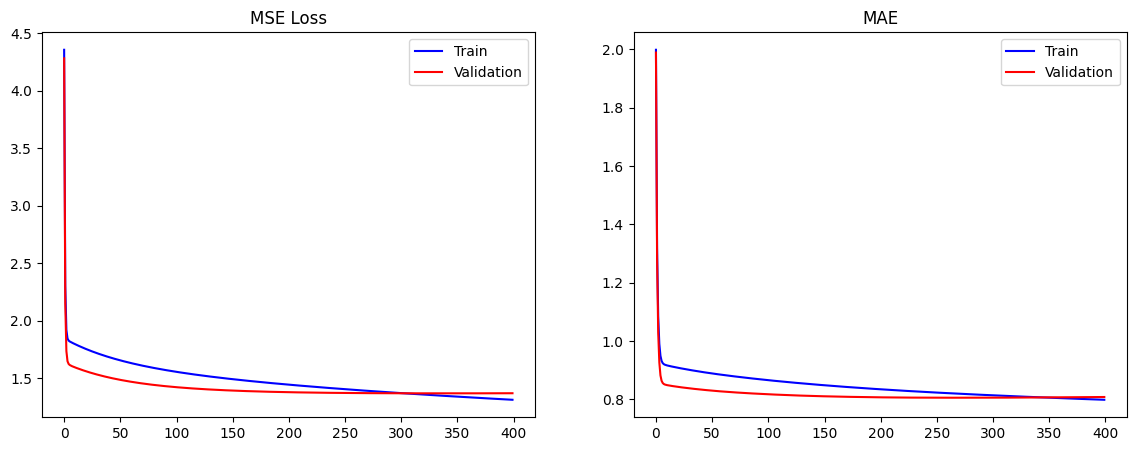

In [ ]:
print("Análisis del perceptrón simple para la vectorización TF-IDF:\n")
instantiate_simple_perceptron(train_dl_tf_idf, X_train_tf_idf_torch, X_val_tf_idf_torch, y_train_tf_idf_torch, y_val_tf_idf_torch, epochs, lr, "best_simple_perceptron_tf_idf.pth")

Análisis del perceptrón simple para la vectorización Word2Vec:

Epoch [1/400]	Loss: 1.9017	MAE: 1.0447	Val Loss: 1.6112	Val MAE: 0.9553
Epoch [2/400]	Loss: 1.7888	MAE: 0.9871	Val Loss: 1.5219	Val MAE: 0.9021
Epoch [3/400]	Loss: 1.7516	MAE: 0.9646	Val Loss: 1.4937	Val MAE: 0.8828
Epoch [4/400]	Loss: 1.7337	MAE: 0.9534	Val Loss: 1.4799	Val MAE: 0.8732
Epoch [5/400]	Loss: 1.7225	MAE: 0.9469	Val Loss: 1.4710	Val MAE: 0.8676
Epoch [6/400]	Loss: 1.7144	MAE: 0.9425	Val Loss: 1.4646	Val MAE: 0.8638
Epoch [7/400]	Loss: 1.7081	MAE: 0.9391	Val Loss: 1.4598	Val MAE: 0.8613
Epoch [8/400]	Loss: 1.7029	MAE: 0.9364	Val Loss: 1.4562	Val MAE: 0.8595
Epoch [9/400]	Loss: 1.6985	MAE: 0.9341	Val Loss: 1.4533	Val MAE: 0.8581
Epoch [10/400]	Loss: 1.6947	MAE: 0.9322	Val Loss: 1.4511	Val MAE: 0.8568
Epoch [11/400]	Loss: 1.6914	MAE: 0.9306	Val Loss: 1.4494	Val MAE: 0.8558
Epoch [12/400]	Loss: 1.6885	MAE: 0.9292	Val Loss: 1.4480	Val MAE: 0.8550
Epoch [13/400]	Loss: 1.6858	MAE: 0.9279	Val Loss: 1.4469	Val MAE: 0.8

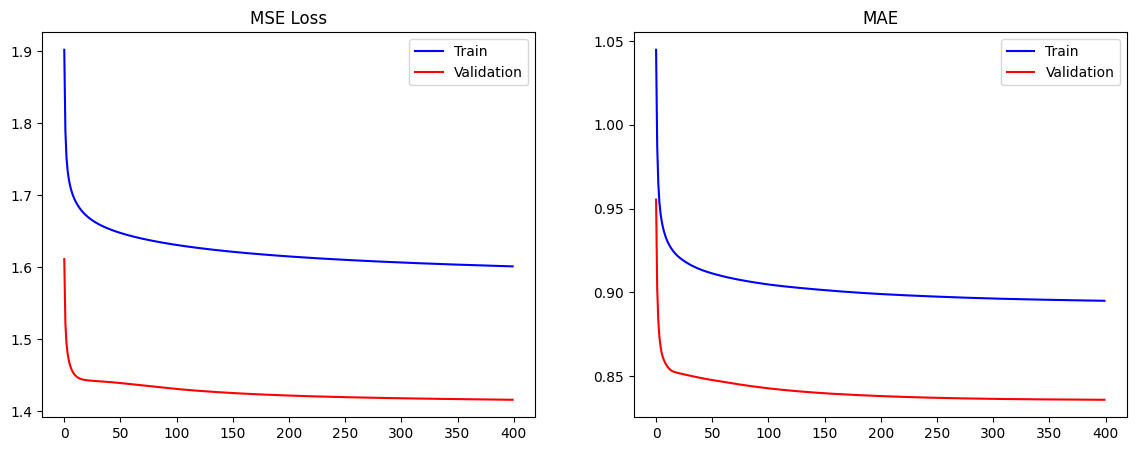

In [ ]:
print("Análisis del perceptrón simple para la vectorización Word2Vec:\n")
instantiate_simple_perceptron(train_dl_word2vec, X_train_word2vec_torch, X_val_word2vec_torch, y_train_word2vec_torch, y_val_word2vec_torch, epochs, lr, "best_simple_perceptron_word2vec.pth")

Análisis del perceptrón simple para la vectorización embeddings:

Epoch [1/400]	Loss: 1.8697	MAE: 1.1097	Val Loss: 1.6797	Val MAE: 1.0528
Epoch [2/400]	Loss: 1.8116	MAE: 1.0789	Val Loss: 1.6096	Val MAE: 1.0175
Epoch [3/400]	Loss: 1.7828	MAE: 1.0623	Val Loss: 1.5746	Val MAE: 0.9981
Epoch [4/400]	Loss: 1.7654	MAE: 1.0524	Val Loss: 1.5542	Val MAE: 0.9869
Epoch [5/400]	Loss: 1.7534	MAE: 1.0458	Val Loss: 1.5411	Val MAE: 0.9796
Epoch [6/400]	Loss: 1.7443	MAE: 1.0409	Val Loss: 1.5321	Val MAE: 0.9746
Epoch [7/400]	Loss: 1.7368	MAE: 1.0371	Val Loss: 1.5255	Val MAE: 0.9709
Epoch [8/400]	Loss: 1.7304	MAE: 1.0340	Val Loss: 1.5205	Val MAE: 0.9681
Epoch [9/400]	Loss: 1.7247	MAE: 1.0313	Val Loss: 1.5166	Val MAE: 0.9660
Epoch [10/400]	Loss: 1.7195	MAE: 1.0290	Val Loss: 1.5134	Val MAE: 0.9644
Epoch [11/400]	Loss: 1.7147	MAE: 1.0270	Val Loss: 1.5108	Val MAE: 0.9630
Epoch [12/400]	Loss: 1.7102	MAE: 1.0251	Val Loss: 1.5085	Val MAE: 0.9619
Epoch [13/400]	Loss: 1.7059	MAE: 1.0234	Val Loss: 1.5065	Val MAE: 0

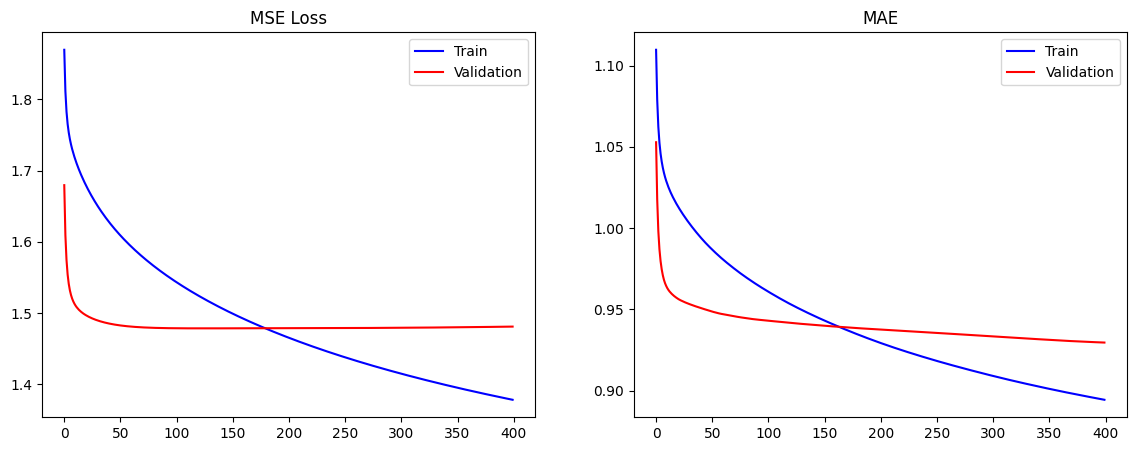

In [ ]:
print("Análisis del perceptrón simple para la vectorización embeddings:\n")
instantiate_simple_perceptron(train_dl_embeddings, X_train_embeddings_torch, X_val_embeddings_torch, y_train_embeddings_torch, y_val_embeddings_torch, epochs, lr, "best_simple_perceptron_embeddings.pth")

In [ ]:
def evaluate_model(model_path, X_test_torch, y_test_torch):
  # Paso 1: cargar el modelo guardado
  best_model = SimplePerceptron(X_test_torch.size()[1], 1)
  best_model.load_state_dict(torch.load(model_path, weights_only=True))
  best_model.eval()

  # Paso 2: realizar predicciones sobre el conjunto de pruebas
  with torch.no_grad():
      pred_test = best_model(X_test_torch)

  # Paso 3: evaluar las predicciones
  test_mae = mean_absolute_error(y_test_torch.view(-1, 1), pred_test).item()
  return test_mae

In [ ]:
test_mae_tf_idf = evaluate_model('best_simple_perceptron_tf_idf.pth', X_test_tf_idf_torch, y_test_tf_idf_torch)
test_mae_word2vec = evaluate_model('best_simple_perceptron_word2vec.pth', X_test_word2vec_torch, y_test_word2vec_torch)
test_mae_embeddings = evaluate_model('best_simple_perceptron_embeddings.pth', X_test_embeddings_torch, y_test_embeddings_torch)

# Mostrar resultados
print("Análisis del perceptrón simple:\n")
print(f"* TF-IDF -> MAE -> conjunto de pruebas -> {test_mae_tf_idf:.4f}")
print(f"* Word2Vec -> MAE -> conjunto de pruebas -> {test_mae_word2vec:.4f}")
print(f"* Embeddings -> MAE -> conjunto de pruebas -> {test_mae_embeddings:.4f}")

Análisis del perceptrón simple:

* TF-IDF -> MAE -> conjunto de pruebas -> 0.8583
* Word2Vec -> MAE -> conjunto de pruebas -> 0.8812
* Embeddings -> MAE -> conjunto de pruebas -> 0.9520


#### Perceptrón multicapa

In [ ]:
# Definir el modelo del perceptrón multicapa
class MLPerceptron(nn.Module):
  def __init__(self, nin, nout, n_hidden):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(nin, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, nout)
    )

  def forward(self, x):
      return self.model(x)


def instantiate_ml_perceptron(train_dl, X_train_torch, X_val_torch, y_train_torch, y_val_torch, n_hidden, epochs, lr, model_path):

  # Paso 1: iniciar el perceptrón multicapa
  nin = X_train_torch.size()[1]  # Número de características de entrada
  nout = 1  # Una salida (para regresión)
  my_net = MLPerceptron(nin, nout, n_hidden)

  # Paso 2: definir la función de pérdidas y el optimizador
  loss_func = nn.MSELoss()
  opt = optim.SGD(my_net.parameters(), lr=lr)

  # Paso 3: inicializar las listas para almacenar los valores de las pérdidas y métricas
  loss_train = np.zeros(epochs)
  loss_val = np.zeros(epochs)
  mae_train = np.zeros(epochs)
  mae_val = np.zeros(epochs)

  # Paso 4: inicializar variables para determinar el mejor modelo
  best_val_mae = float('inf')
  best_epoch = float('inf')
  best_model_state = None

  for epoch in range(epochs):

    # Entrenamiento por lotes
    for xb, yb in train_dl:
      # Ajustar dimensiones de yb
      yb = yb.view(-1, 1)
      # Calcular la salida de la red
      pred = my_net(xb)
      # Calcular las pérdidas para el lote actual
      loss = loss_func(pred, yb)
      # Calcular los gradientes y optimizar los parámetros
      loss.backward()
      opt.step()
      opt.zero_grad()

    # Evaluar las prestaciones al finalizar cada época
    with torch.no_grad():
      pred_train = my_net(X_train_torch)
      loss_train[epoch] = loss_func(pred_train, y_train_torch.view(-1, 1)).item()
      mae_train[epoch] = mean_absolute_error(y_train_torch.view(-1, 1), pred_train).item()

      pred_val = my_net(X_val_torch)
      loss_val[epoch] = loss_func(pred_val, y_val_torch.view(-1, 1)).item()
      mae_val[epoch] = mean_absolute_error(y_val_torch.view(-1, 1), pred_val).item()

    # Guardar el modelo si se encuentra un mejor MAE en validación
    if mae_val[epoch] < best_val_mae:
      best_val_mae = mae_val[epoch]
      best_epoch = epoch
      best_model_state = my_net.state_dict()

    print(f'Epoch [{epoch+1}/{epochs}]\tLoss: {loss_train[epoch]:.4f}\tMAE: {mae_train[epoch]:.4f}\tVal Loss: {loss_val[epoch]:.4f}\tVal MAE: {mae_val[epoch]:.4f}')

  # Guardar el modelo con el mejor MAE en validación
  if best_model_state is not None:
    torch.save(best_model_state, model_path)
    print(f"\nModelo en época {best_epoch+1} tiene el mejor MAE de validación. Almacenando en '{model_path}'...\n\n")

  # Representación gráfica
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(loss_train, 'b', label='Train')
  plt.plot(loss_val, 'r', label='Validation')
  plt.legend()
  plt.title('MSE Loss')
  plt.subplot(1, 2, 2)
  plt.plot(mae_train, 'b', label='Train')
  plt.plot(mae_val, 'r', label='Validation')
  plt.legend()
  plt.title('MAE')
  plt.show()

In [ ]:
# Valores iniciales
epochs = 400
lr = 0.01

n_hidden_tf_idf = 1024
n_hidden_word2vec = 64
n_hidden_embeddings = 512

Análisis del perceptrón multicapa para la vectorización TF-IDF:

Epoch [1/400]	Loss: 2.2701	MAE: 1.2970	Val Loss: 2.2088	Val MAE: 1.2687
Epoch [2/400]	Loss: 1.8478	MAE: 0.9546	Val Loss: 1.8384	Val MAE: 0.9409
Epoch [3/400]	Loss: 1.8357	MAE: 0.9444	Val Loss: 1.8287	Val MAE: 0.9316
Epoch [4/400]	Loss: 1.8251	MAE: 0.9410	Val Loss: 1.8195	Val MAE: 0.9288
Epoch [5/400]	Loss: 1.8146	MAE: 0.9378	Val Loss: 1.8105	Val MAE: 0.9262
Epoch [6/400]	Loss: 1.8042	MAE: 0.9346	Val Loss: 1.8016	Val MAE: 0.9238
Epoch [7/400]	Loss: 1.7939	MAE: 0.9317	Val Loss: 1.7929	Val MAE: 0.9214
Epoch [8/400]	Loss: 1.7836	MAE: 0.9287	Val Loss: 1.7842	Val MAE: 0.9192
Epoch [9/400]	Loss: 1.7734	MAE: 0.9260	Val Loss: 1.7757	Val MAE: 0.9172
Epoch [10/400]	Loss: 1.7631	MAE: 0.9233	Val Loss: 1.7672	Val MAE: 0.9153
Epoch [11/400]	Loss: 1.7529	MAE: 0.9206	Val Loss: 1.7588	Val MAE: 0.9135
Epoch [12/400]	Loss: 1.7426	MAE: 0.9181	Val Loss: 1.7505	Val MAE: 0.9118
Epoch [13/400]	Loss: 1.7323	MAE: 0.9156	Val Loss: 1.7423	Val MAE: 0.

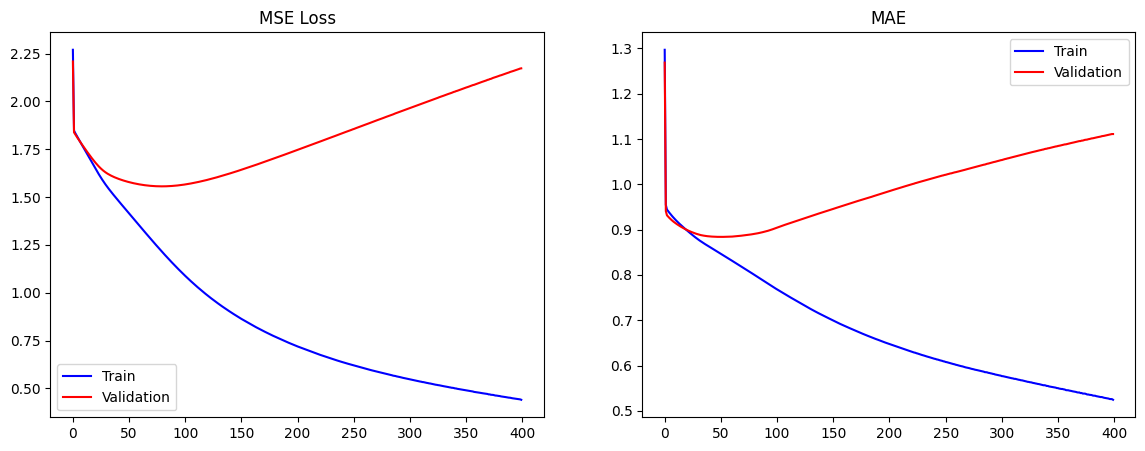

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización TF-IDF:\n")
instantiate_ml_perceptron(train_dl_tf_idf, X_train_tf_idf_torch, X_test_tf_idf_torch, y_train_tf_idf_torch, y_test_tf_idf_torch,
                          n_hidden_tf_idf, epochs, lr, "best_mlp_tf_idf_lr_001.pth")

Análisis del perceptrón multicapa para la vectorización Word2Vec:

Epoch [1/400]	Loss: 1.8539	MAE: 1.0394	Val Loss: 1.8668	Val MAE: 1.0315
Epoch [2/400]	Loss: 1.7560	MAE: 0.9884	Val Loss: 1.7678	Val MAE: 0.9770
Epoch [3/400]	Loss: 1.7308	MAE: 0.9726	Val Loss: 1.7392	Val MAE: 0.9628
Epoch [4/400]	Loss: 1.7185	MAE: 0.9653	Val Loss: 1.7238	Val MAE: 0.9566
Epoch [5/400]	Loss: 1.7103	MAE: 0.9606	Val Loss: 1.7131	Val MAE: 0.9526
Epoch [6/400]	Loss: 1.7039	MAE: 0.9571	Val Loss: 1.7052	Val MAE: 0.9496
Epoch [7/400]	Loss: 1.6987	MAE: 0.9543	Val Loss: 1.6989	Val MAE: 0.9472
Epoch [8/400]	Loss: 1.6941	MAE: 0.9518	Val Loss: 1.6938	Val MAE: 0.9452
Epoch [9/400]	Loss: 1.6903	MAE: 0.9499	Val Loss: 1.6896	Val MAE: 0.9436
Epoch [10/400]	Loss: 1.6868	MAE: 0.9482	Val Loss: 1.6859	Val MAE: 0.9422
Epoch [11/400]	Loss: 1.6836	MAE: 0.9466	Val Loss: 1.6827	Val MAE: 0.9410
Epoch [12/400]	Loss: 1.6808	MAE: 0.9453	Val Loss: 1.6798	Val MAE: 0.9399
Epoch [13/400]	Loss: 1.6780	MAE: 0.9440	Val Loss: 1.6771	Val MAE: 

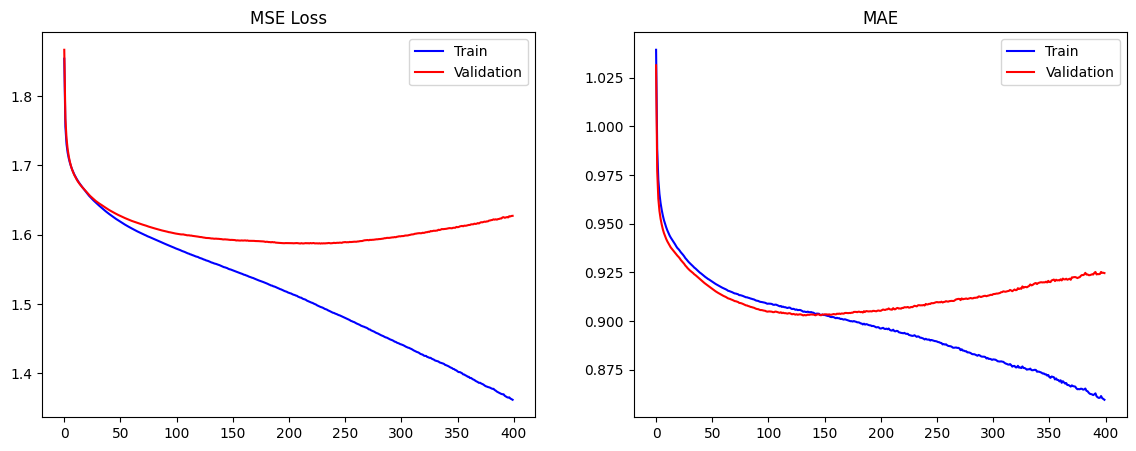

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización Word2Vec:\n")
instantiate_ml_perceptron(train_dl_word2vec, X_train_word2vec_torch, X_test_word2vec_torch, y_train_word2vec_torch, y_test_word2vec_torch,
                          n_hidden_word2vec, epochs, lr, "best_mlp_word2vec_lr_001.pth")

Análisis del perceptrón multicapa para la vectorización embeddings:

Epoch [1/400]	Loss: 1.8550	MAE: 1.0879	Val Loss: 1.8064	Val MAE: 1.0623
Epoch [2/400]	Loss: 1.8004	MAE: 1.0650	Val Loss: 1.7476	Val MAE: 1.0365
Epoch [3/400]	Loss: 1.7708	MAE: 1.0507	Val Loss: 1.7161	Val MAE: 1.0213
Epoch [4/400]	Loss: 1.7531	MAE: 1.0419	Val Loss: 1.6971	Val MAE: 1.0118
Epoch [5/400]	Loss: 1.7398	MAE: 1.0351	Val Loss: 1.6837	Val MAE: 1.0050
Epoch [6/400]	Loss: 1.7299	MAE: 1.0300	Val Loss: 1.6739	Val MAE: 1.0002
Epoch [7/400]	Loss: 1.7226	MAE: 1.0264	Val Loss: 1.6670	Val MAE: 0.9971
Epoch [8/400]	Loss: 1.7164	MAE: 1.0234	Val Loss: 1.6614	Val MAE: 0.9946
Epoch [9/400]	Loss: 1.7104	MAE: 1.0203	Val Loss: 1.6563	Val MAE: 0.9920
Epoch [10/400]	Loss: 1.7051	MAE: 1.0177	Val Loss: 1.6522	Val MAE: 0.9900
Epoch [11/400]	Loss: 1.7005	MAE: 1.0156	Val Loss: 1.6487	Val MAE: 0.9884
Epoch [12/400]	Loss: 1.6960	MAE: 1.0135	Val Loss: 1.6456	Val MAE: 0.9870
Epoch [13/400]	Loss: 1.6919	MAE: 1.0118	Val Loss: 1.6429	Val MAE

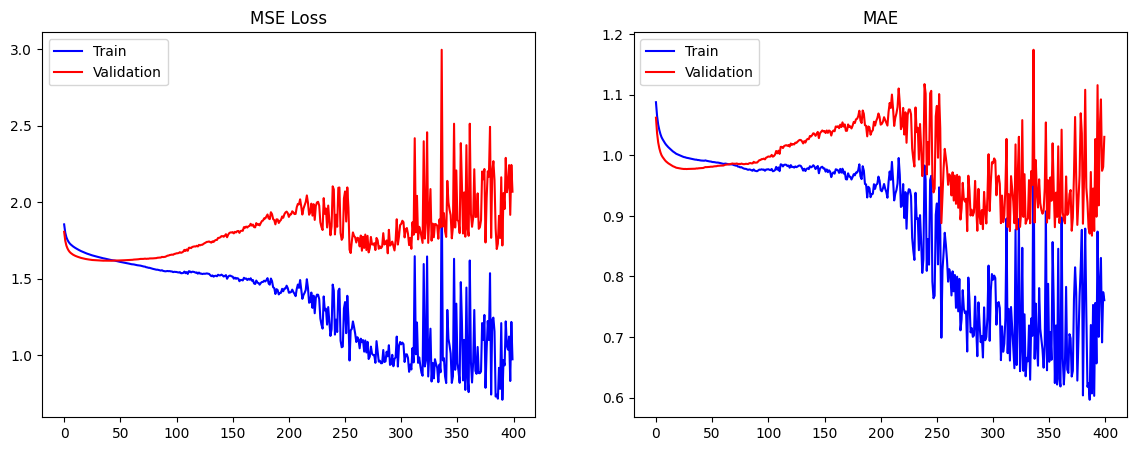

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización embeddings:\n")
instantiate_ml_perceptron(train_dl_embeddings, X_train_embeddings_torch, X_test_embeddings_torch, y_train_embeddings_torch, y_test_embeddings_torch,
                          n_hidden_embeddings, epochs, lr, "best_mlp_embeddings_lr_001.pth")

In [ ]:
def evaluate_model(model_path, X_test_torch, y_test_torch, n_hidden):
  # Paso 1: cargar el modelo guardado
  best_model = MLPerceptron(X_test_torch.size()[1], 1, n_hidden)
  best_model.load_state_dict(torch.load(model_path, weights_only=True))
  best_model.eval()

  # Paso 2: realizar predicciones sobre el conjunto de pruebas
  with torch.no_grad():
      pred_test = best_model(X_test_torch)

  # Paso 3: evaluar las predicciones
  test_mae = mean_absolute_error(y_test_torch.view(-1, 1), pred_test).item()
  return test_mae

In [ ]:
test_mae_tf_idf = evaluate_model('best_mlp_tf_idf_lr_001.pth', X_test_tf_idf_torch, y_test_tf_idf_torch, n_hidden_tf_idf)
test_mae_word2vec = evaluate_model('best_mlp_word2vec_lr_001.pth', X_test_word2vec_torch, y_test_word2vec_torch, n_hidden_word2vec)
test_mae_embeddings = evaluate_model('best_mlp_embeddings_lr_001.pth', X_test_embeddings_torch, y_test_embeddings_torch, n_hidden_embeddings)

# Mostrar resultados
print("Análisis del perceptrón multicapa:\n")
print(f"* TF-IDF -> MAE -> conjunto de pruebas -> {test_mae_tf_idf:.4f}")
print(f"* Word2Vec -> MAE -> conjunto de pruebas -> {test_mae_word2vec:.4f}")
print(f"* Embeddings -> MAE -> conjunto de pruebas -> {test_mae_embeddings:.4f}")

Análisis del perceptrón multicapa:

* TF-IDF -> MAE -> conjunto de pruebas -> 1.1110
* Word2Vec -> MAE -> conjunto de pruebas -> 0.9246
* Embeddings -> MAE -> conjunto de pruebas -> 1.0306


#### Análisis de la tasa de aprendizaje y del número de épocas

In [ ]:
# Probar varios valores de tasa de aprendizaje
epochs_default = 400
lr_list = [0.001, 0.0055, 0.055, 0.1] # tasa de aprendizaje de 0.01 está probada en el apartado anterior

n_hidden_tf_idf = 1024
n_hidden_word2vec = 64
n_hidden_embeddings = 512



Análisis del perceptrón multicapa para la vectorización TF-IDF:
** Epochs: 400
** lr: 0.001

Epoch [1/400]	Loss: 12.8839	MAE: 3.3914	Val Loss: 12.5827	Val MAE: 3.3487
Epoch [2/400]	Loss: 10.7337	MAE: 3.1159	Val Loss: 10.4638	Val MAE: 3.0746
Epoch [3/400]	Loss: 8.7944	MAE: 2.8369	Val Loss: 8.5560	Val MAE: 2.7971
Epoch [4/400]	Loss: 7.0490	MAE: 2.5514	Val Loss: 6.8430	Val MAE: 2.5138
Epoch [5/400]	Loss: 5.5284	MAE: 2.2617	Val Loss: 5.3554	Val MAE: 2.2271
Epoch [6/400]	Loss: 4.2832	MAE: 1.9799	Val Loss: 4.1426	Val MAE: 1.9459
Epoch [7/400]	Loss: 3.3462	MAE: 1.7164	Val Loss: 3.2359	Val MAE: 1.6820
Epoch [8/400]	Loss: 2.7058	MAE: 1.4990	Val Loss: 2.6221	Val MAE: 1.4676
Epoch [9/400]	Loss: 2.3081	MAE: 1.3192	Val Loss: 2.2465	Val MAE: 1.2905
Epoch [10/400]	Loss: 2.0815	MAE: 1.1938	Val Loss: 2.0370	Val MAE: 1.1688
Epoch [11/400]	Loss: 1.9609	MAE: 1.1118	Val Loss: 1.9293	Val MAE: 1.0910
Epoch [12/400]	Loss: 1.9000	MAE: 1.0525	Val Loss: 1.8777	Val MAE: 1.0347
Epoch [13/400]	Loss: 1.8701	MAE: 1

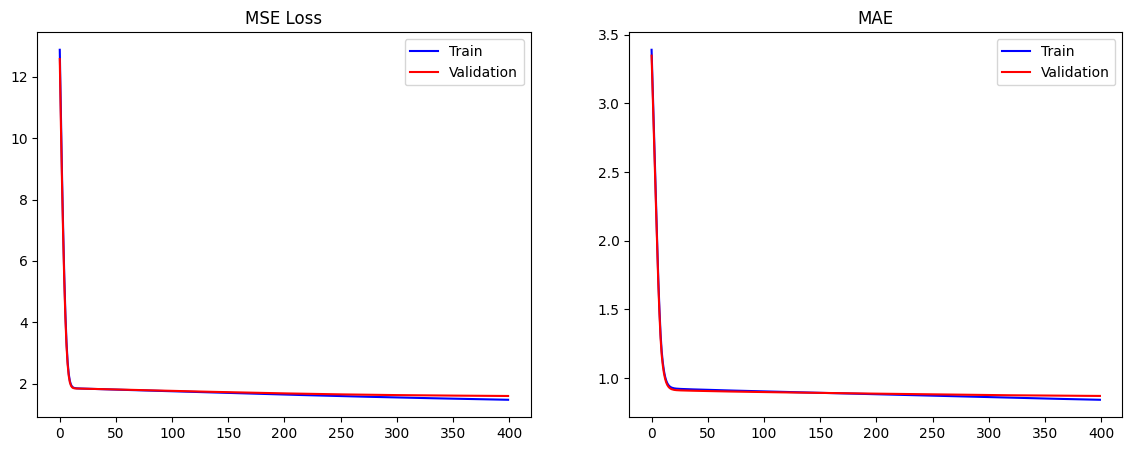



Análisis del perceptrón multicapa para la vectorización TF-IDF:
** Epochs: 400
** lr: 0.0055

Epoch [1/400]	Loss: 5.1871	MAE: 2.1892	Val Loss: 5.0178	Val MAE: 2.1544
Epoch [2/400]	Loss: 2.0119	MAE: 1.1478	Val Loss: 1.9707	Val MAE: 1.1232
Epoch [3/400]	Loss: 1.8522	MAE: 0.9588	Val Loss: 1.8411	Val MAE: 0.9439
Epoch [4/400]	Loss: 1.8425	MAE: 0.9347	Val Loss: 1.8357	Val MAE: 0.9213
Epoch [5/400]	Loss: 1.8362	MAE: 0.9306	Val Loss: 1.8305	Val MAE: 0.9177
Epoch [6/400]	Loss: 1.8300	MAE: 0.9286	Val Loss: 1.8252	Val MAE: 0.9161
Epoch [7/400]	Loss: 1.8240	MAE: 0.9268	Val Loss: 1.8199	Val MAE: 0.9147
Epoch [8/400]	Loss: 1.8179	MAE: 0.9251	Val Loss: 1.8147	Val MAE: 0.9135
Epoch [9/400]	Loss: 1.8120	MAE: 0.9235	Val Loss: 1.8096	Val MAE: 0.9122
Epoch [10/400]	Loss: 1.8060	MAE: 0.9219	Val Loss: 1.8045	Val MAE: 0.9110
Epoch [11/400]	Loss: 1.8001	MAE: 0.9203	Val Loss: 1.7995	Val MAE: 0.9098
Epoch [12/400]	Loss: 1.7943	MAE: 0.9188	Val Loss: 1.7945	Val MAE: 0.9088
Epoch [13/400]	Loss: 1.7884	MAE: 0.91

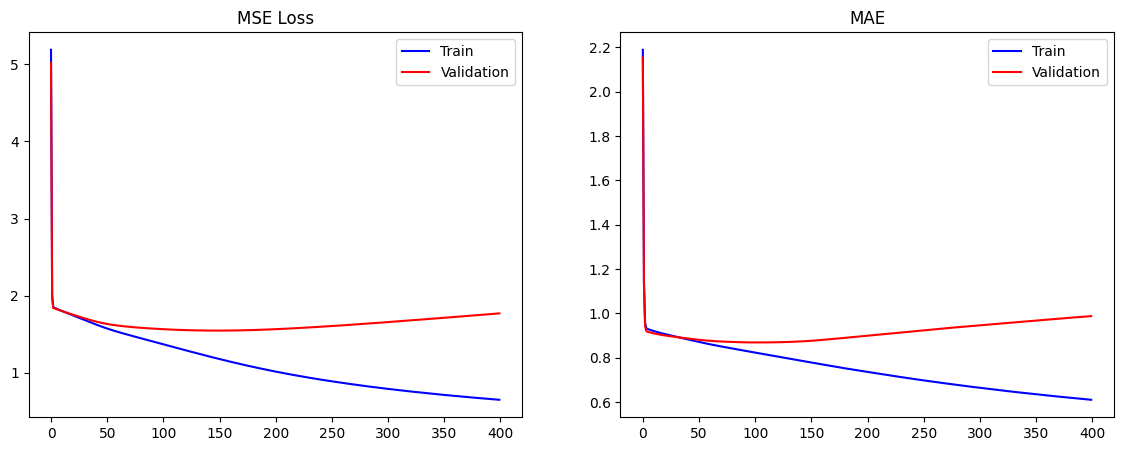



Análisis del perceptrón multicapa para la vectorización TF-IDF:
** Epochs: 400
** lr: 0.055

Epoch [1/400]	Loss: 1.8559	MAE: 1.0331	Val Loss: 1.8386	Val MAE: 1.0173
Epoch [2/400]	Loss: 1.8012	MAE: 1.0156	Val Loss: 1.7930	Val MAE: 1.0030
Epoch [3/400]	Loss: 1.7465	MAE: 0.9981	Val Loss: 1.7496	Val MAE: 0.9894
Epoch [4/400]	Loss: 1.6923	MAE: 0.9807	Val Loss: 1.7101	Val MAE: 0.9761
Epoch [5/400]	Loss: 1.6417	MAE: 0.9632	Val Loss: 1.6778	Val MAE: 0.9641
Epoch [6/400]	Loss: 1.5966	MAE: 0.9473	Val Loss: 1.6537	Val MAE: 0.9544
Epoch [7/400]	Loss: 1.5562	MAE: 0.9340	Val Loss: 1.6360	Val MAE: 0.9472
Epoch [8/400]	Loss: 1.5183	MAE: 0.9226	Val Loss: 1.6226	Val MAE: 0.9425
Epoch [9/400]	Loss: 1.4811	MAE: 0.9120	Val Loss: 1.6117	Val MAE: 0.9389
Epoch [10/400]	Loss: 1.4443	MAE: 0.9014	Val Loss: 1.6025	Val MAE: 0.9362
Epoch [11/400]	Loss: 1.4083	MAE: 0.8917	Val Loss: 1.5955	Val MAE: 0.9347
Epoch [12/400]	Loss: 1.3736	MAE: 0.8828	Val Loss: 1.5906	Val MAE: 0.9345
Epoch [13/400]	Loss: 1.3407	MAE: 0.875

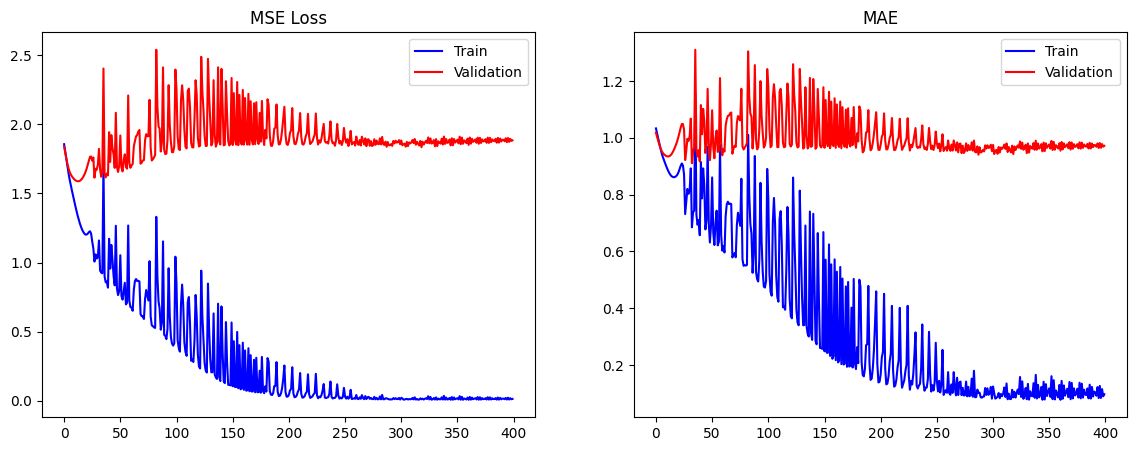



Análisis del perceptrón multicapa para la vectorización TF-IDF:
** Epochs: 400
** lr: 0.1

Epoch [1/400]	Loss: 1.8502	MAE: 1.0546	Val Loss: 1.8328	Val MAE: 1.0389
Epoch [2/400]	Loss: 1.7540	MAE: 1.0217	Val Loss: 1.7566	Val MAE: 1.0123
Epoch [3/400]	Loss: 1.6652	MAE: 0.9891	Val Loss: 1.6967	Val MAE: 0.9874
Epoch [4/400]	Loss: 1.6003	MAE: 0.9695	Val Loss: 1.6662	Val MAE: 0.9771
Epoch [5/400]	Loss: 1.5552	MAE: 0.9658	Val Loss: 1.6581	Val MAE: 0.9828
Epoch [6/400]	Loss: 1.5340	MAE: 0.9786	Val Loss: 1.6743	Val MAE: 1.0048
Epoch [7/400]	Loss: 1.5356	MAE: 1.0017	Val Loss: 1.7119	Val MAE: 1.0359
Epoch [8/400]	Loss: 1.5351	MAE: 1.0169	Val Loss: 1.7453	Val MAE: 1.0587
Epoch [9/400]	Loss: 1.5160	MAE: 1.0166	Val Loss: 1.7582	Val MAE: 1.0666
Epoch [10/400]	Loss: 1.4890	MAE: 1.0099	Val Loss: 1.7623	Val MAE: 1.0684
Epoch [11/400]	Loss: 1.4629	MAE: 1.0027	Val Loss: 1.7662	Val MAE: 1.0699
Epoch [12/400]	Loss: 1.4422	MAE: 0.9980	Val Loss: 1.7745	Val MAE: 1.0736
Epoch [13/400]	Loss: 1.4505	MAE: 1.0093	

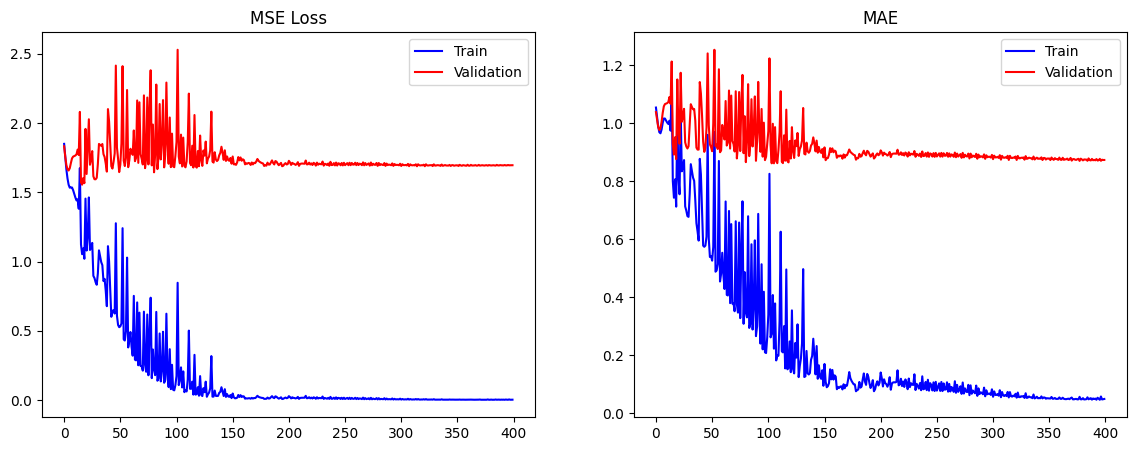

In [ ]:
for lr in lr_list:
  print("\n\nAnálisis del perceptrón multicapa para la vectorización TF-IDF:")
  print(f"** Epochs: {epochs_default}")
  print(f"** lr: {lr}\n")
  model_path = "best_mlp_tf_idf_lr_" + str(lr) + ".pth"
  instantiate_ml_perceptron(train_dl_tf_idf, X_train_tf_idf_torch, X_test_tf_idf_torch, y_train_tf_idf_torch, y_test_tf_idf_torch,
                            n_hidden_tf_idf, epochs_default, lr, model_path)



Análisis del perceptrón multicapa para la vectorización Word2Vec:
** Epochs: 400
** lr: 0.001

Epoch [1/400]	Loss: 10.3082	MAE: 3.0515	Val Loss: 10.0585	Val MAE: 3.0118
Epoch [2/400]	Loss: 5.1780	MAE: 2.1591	Val Loss: 5.0402	Val MAE: 2.1262
Epoch [3/400]	Loss: 2.5481	MAE: 1.3846	Val Loss: 2.5039	Val MAE: 1.3634
Epoch [4/400]	Loss: 2.0169	MAE: 1.1202	Val Loss: 2.0156	Val MAE: 1.1148
Epoch [5/400]	Loss: 1.9292	MAE: 1.0567	Val Loss: 1.9418	Val MAE: 1.0527
Epoch [6/400]	Loss: 1.8922	MAE: 1.0311	Val Loss: 1.9091	Val MAE: 1.0282
Epoch [7/400]	Loss: 1.8643	MAE: 1.0148	Val Loss: 1.8827	Val MAE: 1.0125
Epoch [8/400]	Loss: 1.8413	MAE: 1.0023	Val Loss: 1.8605	Val MAE: 1.0001
Epoch [9/400]	Loss: 1.8221	MAE: 0.9920	Val Loss: 1.8418	Val MAE: 0.9897
Epoch [10/400]	Loss: 1.8061	MAE: 0.9834	Val Loss: 1.8261	Val MAE: 0.9810
Epoch [11/400]	Loss: 1.7926	MAE: 0.9762	Val Loss: 1.8129	Val MAE: 0.9733
Epoch [12/400]	Loss: 1.7813	MAE: 0.9700	Val Loss: 1.8018	Val MAE: 0.9667
Epoch [13/400]	Loss: 1.7717	MAE: 0

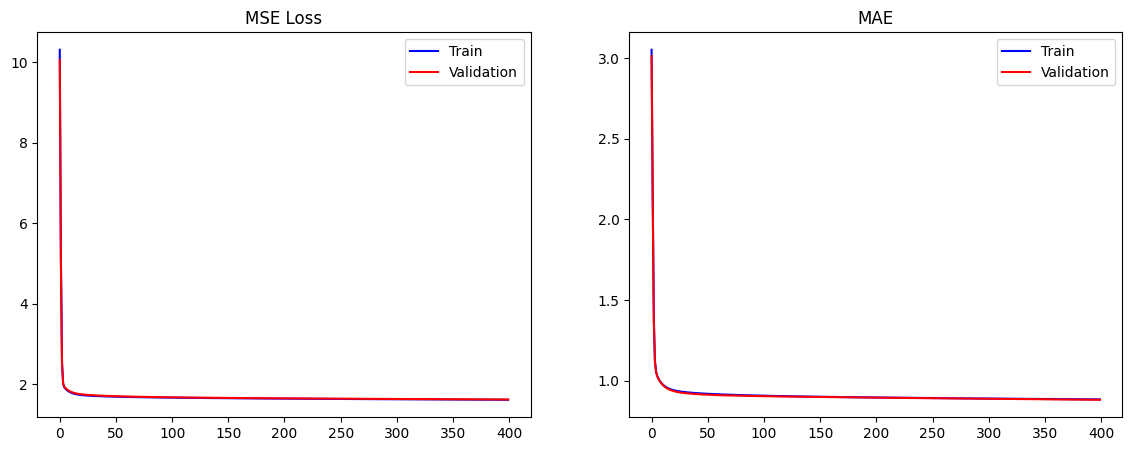



Análisis del perceptrón multicapa para la vectorización Word2Vec:
** Epochs: 400
** lr: 0.0055

Epoch [1/400]	Loss: 1.9209	MAE: 1.0605	Val Loss: 1.9227	Val MAE: 1.0599
Epoch [2/400]	Loss: 1.7757	MAE: 0.9911	Val Loss: 1.7865	Val MAE: 0.9890
Epoch [3/400]	Loss: 1.7295	MAE: 0.9648	Val Loss: 1.7436	Val MAE: 0.9609
Epoch [4/400]	Loss: 1.7120	MAE: 0.9530	Val Loss: 1.7271	Val MAE: 0.9487
Epoch [5/400]	Loss: 1.7032	MAE: 0.9471	Val Loss: 1.7181	Val MAE: 0.9430
Epoch [6/400]	Loss: 1.6975	MAE: 0.9434	Val Loss: 1.7116	Val MAE: 0.9395
Epoch [7/400]	Loss: 1.6931	MAE: 0.9408	Val Loss: 1.7063	Val MAE: 0.9371
Epoch [8/400]	Loss: 1.6894	MAE: 0.9387	Val Loss: 1.7017	Val MAE: 0.9352
Epoch [9/400]	Loss: 1.6862	MAE: 0.9369	Val Loss: 1.6976	Val MAE: 0.9336
Epoch [10/400]	Loss: 1.6834	MAE: 0.9354	Val Loss: 1.6940	Val MAE: 0.9322
Epoch [11/400]	Loss: 1.6808	MAE: 0.9341	Val Loss: 1.6907	Val MAE: 0.9310
Epoch [12/400]	Loss: 1.6783	MAE: 0.9328	Val Loss: 1.6877	Val MAE: 0.9298
Epoch [13/400]	Loss: 1.6761	MAE: 0.

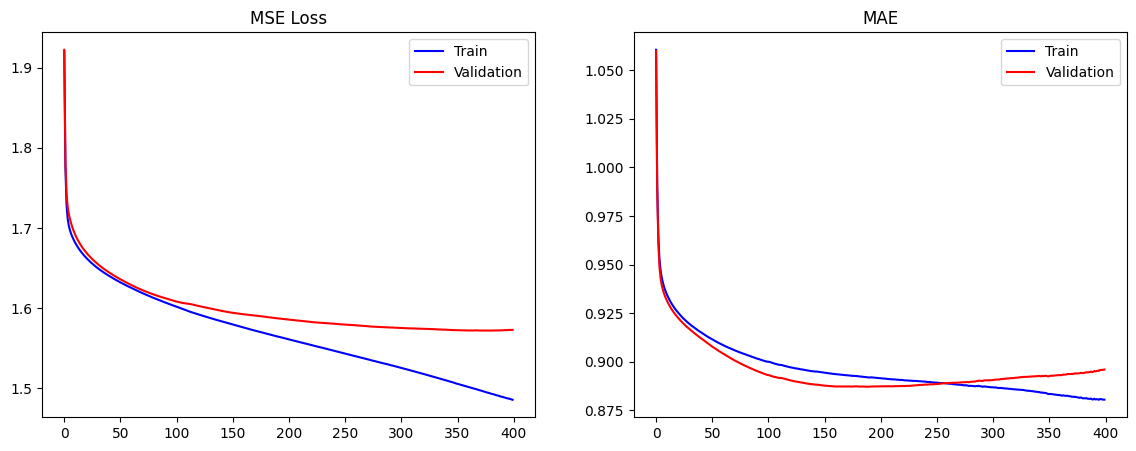



Análisis del perceptrón multicapa para la vectorización Word2Vec:
** Epochs: 400
** lr: 0.055

Epoch [1/400]	Loss: 1.8609	MAE: 1.0906	Val Loss: 1.8368	Val MAE: 1.0741
Epoch [2/400]	Loss: 1.8021	MAE: 1.0545	Val Loss: 1.7807	Val MAE: 1.0405
Epoch [3/400]	Loss: 1.7681	MAE: 1.0326	Val Loss: 1.7494	Val MAE: 1.0201
Epoch [4/400]	Loss: 1.7449	MAE: 1.0172	Val Loss: 1.7285	Val MAE: 1.0059
Epoch [5/400]	Loss: 1.7276	MAE: 1.0056	Val Loss: 1.7136	Val MAE: 0.9950
Epoch [6/400]	Loss: 1.7134	MAE: 0.9960	Val Loss: 1.7018	Val MAE: 0.9861
Epoch [7/400]	Loss: 1.7014	MAE: 0.9876	Val Loss: 1.6920	Val MAE: 0.9787
Epoch [8/400]	Loss: 1.6909	MAE: 0.9801	Val Loss: 1.6835	Val MAE: 0.9719
Epoch [9/400]	Loss: 1.6819	MAE: 0.9737	Val Loss: 1.6763	Val MAE: 0.9660
Epoch [10/400]	Loss: 1.6744	MAE: 0.9682	Val Loss: 1.6702	Val MAE: 0.9608
Epoch [11/400]	Loss: 1.6678	MAE: 0.9635	Val Loss: 1.6644	Val MAE: 0.9562
Epoch [12/400]	Loss: 1.6619	MAE: 0.9594	Val Loss: 1.6588	Val MAE: 0.9518
Epoch [13/400]	Loss: 1.6563	MAE: 0.9

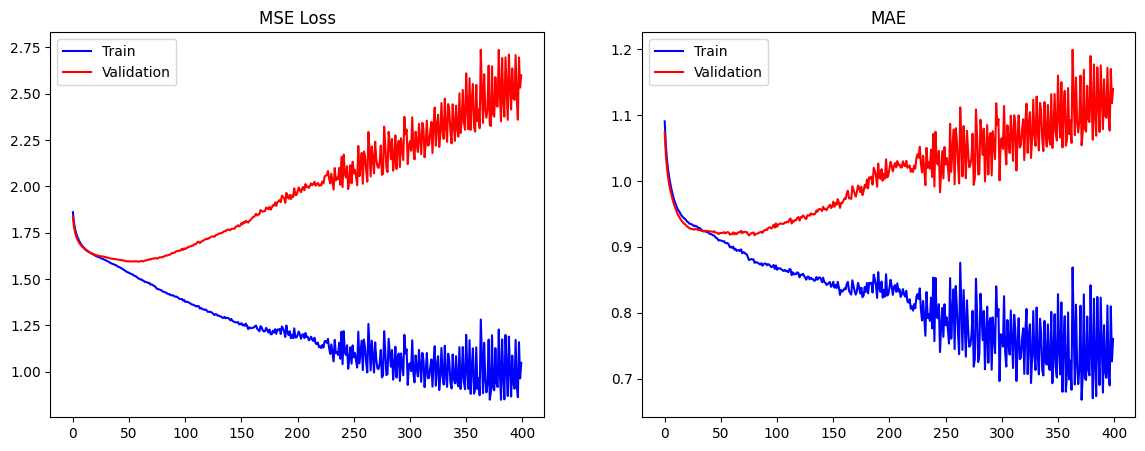



Análisis del perceptrón multicapa para la vectorización Word2Vec:
** Epochs: 400
** lr: 0.1

Epoch [1/400]	Loss: 1.7653	MAE: 1.0183	Val Loss: 1.7306	Val MAE: 0.9982
Epoch [2/400]	Loss: 1.7178	MAE: 0.9864	Val Loss: 1.6959	Val MAE: 0.9713
Epoch [3/400]	Loss: 1.6910	MAE: 0.9655	Val Loss: 1.6790	Val MAE: 0.9534
Epoch [4/400]	Loss: 1.6768	MAE: 0.9547	Val Loss: 1.6704	Val MAE: 0.9434
Epoch [5/400]	Loss: 1.6669	MAE: 0.9475	Val Loss: 1.6643	Val MAE: 0.9373
Epoch [6/400]	Loss: 1.6597	MAE: 0.9431	Val Loss: 1.6594	Val MAE: 0.9331
Epoch [7/400]	Loss: 1.6527	MAE: 0.9386	Val Loss: 1.6545	Val MAE: 0.9291
Epoch [8/400]	Loss: 1.6467	MAE: 0.9359	Val Loss: 1.6496	Val MAE: 0.9263
Epoch [9/400]	Loss: 1.6406	MAE: 0.9323	Val Loss: 1.6446	Val MAE: 0.9229
Epoch [10/400]	Loss: 1.6365	MAE: 0.9311	Val Loss: 1.6409	Val MAE: 0.9220
Epoch [11/400]	Loss: 1.6322	MAE: 0.9290	Val Loss: 1.6376	Val MAE: 0.9196
Epoch [12/400]	Loss: 1.6278	MAE: 0.9271	Val Loss: 1.6349	Val MAE: 0.9182
Epoch [13/400]	Loss: 1.6250	MAE: 0.926

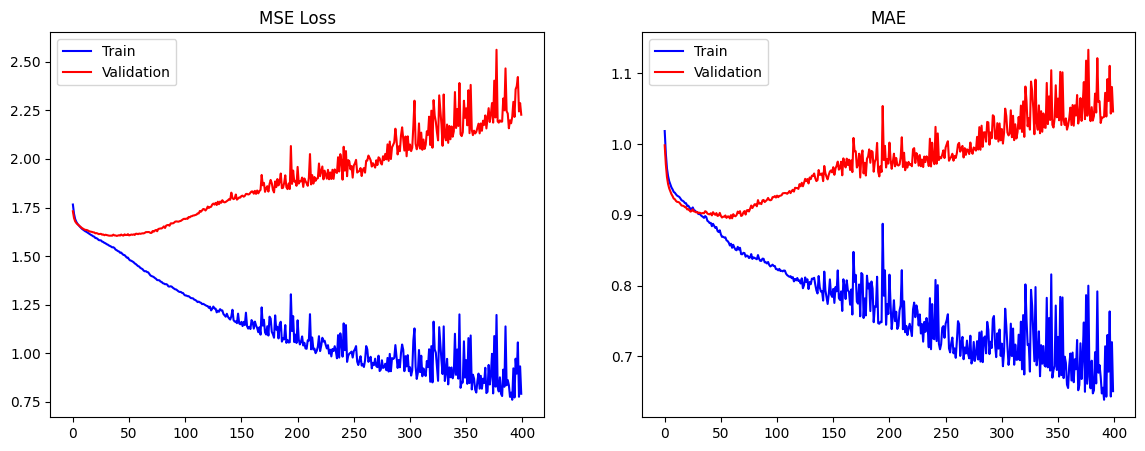

In [ ]:
for lr in lr_list:
  print("\n\nAnálisis del perceptrón multicapa para la vectorización Word2Vec:")
  print(f"** Epochs: {epochs_default}")
  print(f"** lr: {lr}\n")
  model_path = "best_mlp_word2vec_lr_" + str(lr) + ".pth"
  instantiate_ml_perceptron(train_dl_word2vec, X_train_word2vec_torch, X_test_word2vec_torch, y_train_word2vec_torch, y_test_word2vec_torch,
                            n_hidden_word2vec, epochs_default, lr, model_path)



Análisis del perceptrón multicapa para la vectorización embeddings:
** Epochs: 400
** lr: 0.001

Epoch [1/400]	Loss: 1.8599	MAE: 1.0223	Val Loss: 1.8454	Val MAE: 1.0092
Epoch [2/400]	Loss: 1.8139	MAE: 0.9513	Val Loss: 1.8086	Val MAE: 0.9399
Epoch [3/400]	Loss: 1.8002	MAE: 0.9475	Val Loss: 1.7935	Val MAE: 0.9355
Epoch [4/400]	Loss: 1.7876	MAE: 0.9444	Val Loss: 1.7796	Val MAE: 0.9319
Epoch [5/400]	Loss: 1.7760	MAE: 0.9417	Val Loss: 1.7667	Val MAE: 0.9286
Epoch [6/400]	Loss: 1.7653	MAE: 0.9394	Val Loss: 1.7549	Val MAE: 0.9258
Epoch [7/400]	Loss: 1.7556	MAE: 0.9373	Val Loss: 1.7441	Val MAE: 0.9234
Epoch [8/400]	Loss: 1.7467	MAE: 0.9355	Val Loss: 1.7342	Val MAE: 0.9213
Epoch [9/400]	Loss: 1.7384	MAE: 0.9340	Val Loss: 1.7250	Val MAE: 0.9195
Epoch [10/400]	Loss: 1.7307	MAE: 0.9327	Val Loss: 1.7165	Val MAE: 0.9178
Epoch [11/400]	Loss: 1.7236	MAE: 0.9315	Val Loss: 1.7085	Val MAE: 0.9164
Epoch [12/400]	Loss: 1.7170	MAE: 0.9305	Val Loss: 1.7011	Val MAE: 0.9151
Epoch [13/400]	Loss: 1.7108	MAE: 0

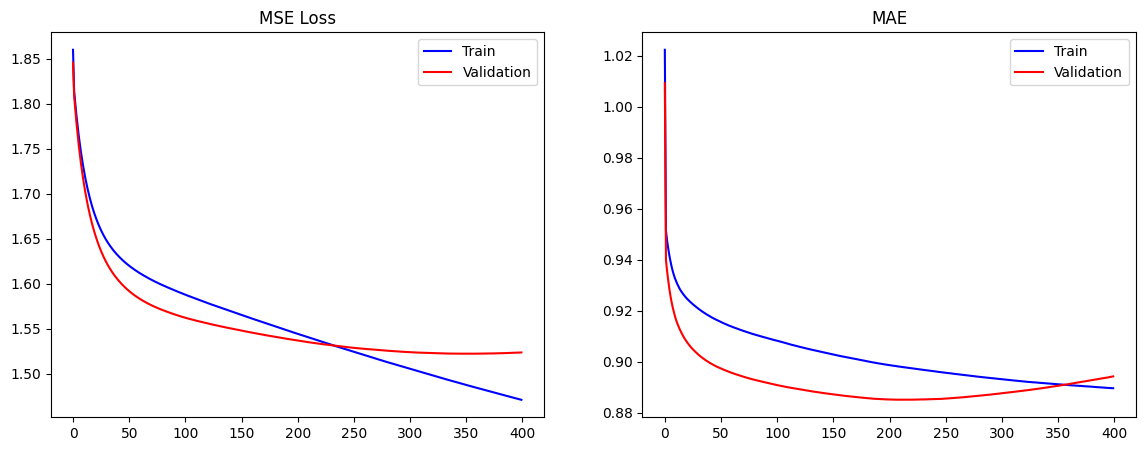



Análisis del perceptrón multicapa para la vectorización embeddings:
** Epochs: 400
** lr: 0.0055

Epoch [1/400]	Loss: 1.8327	MAE: 1.0437	Val Loss: 1.8001	Val MAE: 1.0249
Epoch [2/400]	Loss: 1.7817	MAE: 1.0256	Val Loss: 1.7446	Val MAE: 1.0040
Epoch [3/400]	Loss: 1.7486	MAE: 1.0125	Val Loss: 1.7085	Val MAE: 0.9888
Epoch [4/400]	Loss: 1.7263	MAE: 1.0031	Val Loss: 1.6841	Val MAE: 0.9781
Epoch [5/400]	Loss: 1.7106	MAE: 0.9969	Val Loss: 1.6671	Val MAE: 0.9709
Epoch [6/400]	Loss: 1.6992	MAE: 0.9925	Val Loss: 1.6547	Val MAE: 0.9661
Epoch [7/400]	Loss: 1.6905	MAE: 0.9890	Val Loss: 1.6452	Val MAE: 0.9626
Epoch [8/400]	Loss: 1.6836	MAE: 0.9865	Val Loss: 1.6378	Val MAE: 0.9602
Epoch [9/400]	Loss: 1.6781	MAE: 0.9844	Val Loss: 1.6320	Val MAE: 0.9583
Epoch [10/400]	Loss: 1.6735	MAE: 0.9827	Val Loss: 1.6272	Val MAE: 0.9567
Epoch [11/400]	Loss: 1.6694	MAE: 0.9811	Val Loss: 1.6231	Val MAE: 0.9554
Epoch [12/400]	Loss: 1.6658	MAE: 0.9798	Val Loss: 1.6197	Val MAE: 0.9543
Epoch [13/400]	Loss: 1.6624	MAE: 

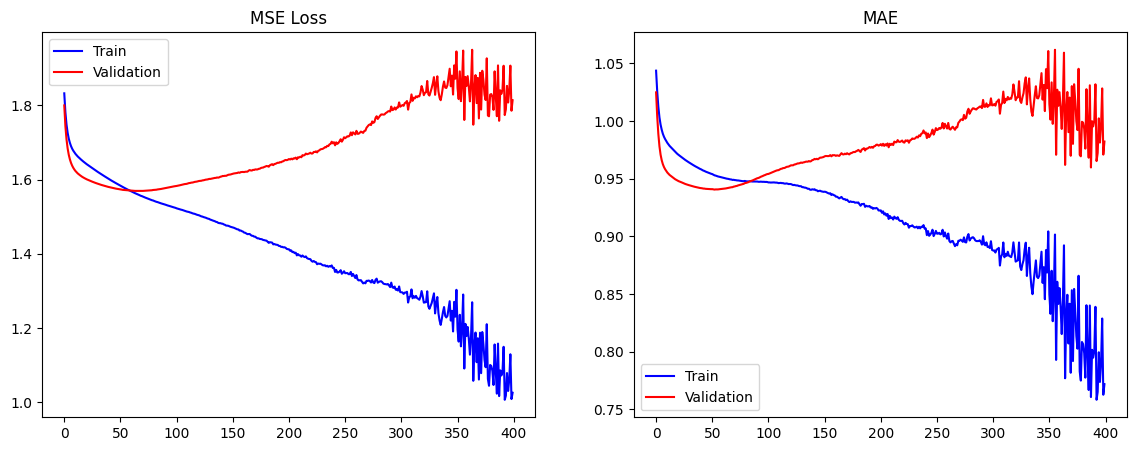



Análisis del perceptrón multicapa para la vectorización embeddings:
** Epochs: 400
** lr: 0.055

Epoch [1/400]	Loss: 1.8562	MAE: 1.0555	Val Loss: 1.8195	Val MAE: 1.0326
Epoch [2/400]	Loss: 1.7864	MAE: 1.0193	Val Loss: 1.7474	Val MAE: 0.9953
Epoch [3/400]	Loss: 1.7935	MAE: 1.0464	Val Loss: 1.7479	Val MAE: 1.0214
Epoch [4/400]	Loss: 1.7299	MAE: 1.0177	Val Loss: 1.6847	Val MAE: 0.9940
Epoch [5/400]	Loss: 1.6997	MAE: 0.9925	Val Loss: 1.6683	Val MAE: 0.9702
Epoch [6/400]	Loss: 1.6936	MAE: 0.9826	Val Loss: 1.6621	Val MAE: 0.9587
Epoch [7/400]	Loss: 1.6785	MAE: 0.9677	Val Loss: 1.6494	Val MAE: 0.9442
Epoch [8/400]	Loss: 1.6695	MAE: 0.9606	Val Loss: 1.6416	Val MAE: 0.9374
Epoch [9/400]	Loss: 1.6710	MAE: 0.9631	Val Loss: 1.6441	Val MAE: 0.9393
Epoch [10/400]	Loss: 1.6623	MAE: 0.9566	Val Loss: 1.6380	Val MAE: 0.9340
Epoch [11/400]	Loss: 1.6531	MAE: 0.9516	Val Loss: 1.6308	Val MAE: 0.9296
Epoch [12/400]	Loss: 1.6404	MAE: 0.9431	Val Loss: 1.6220	Val MAE: 0.9224
Epoch [13/400]	Loss: 1.6329	MAE: 0

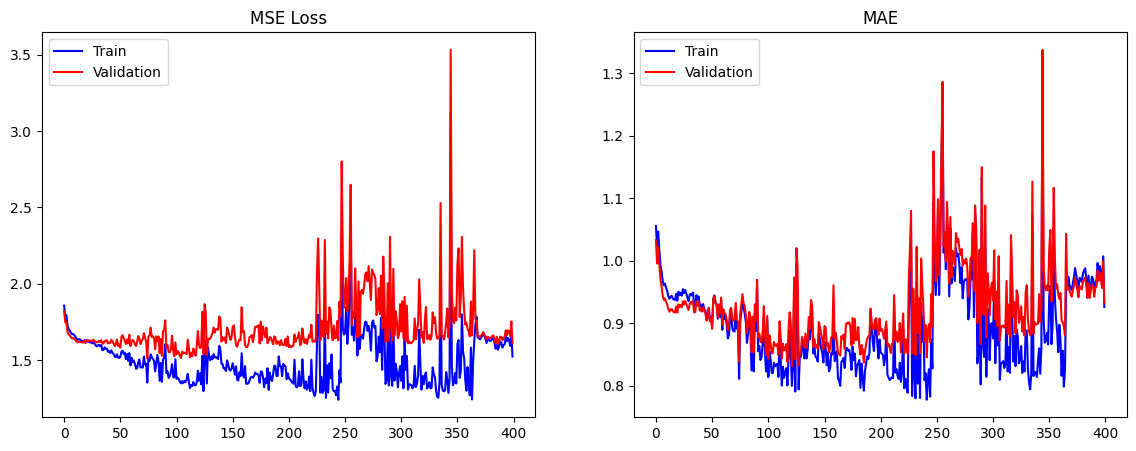



Análisis del perceptrón multicapa para la vectorización embeddings:
** Epochs: 400
** lr: 0.1

Epoch [1/400]	Loss: 1.9102	MAE: 1.0760	Val Loss: 1.8739	Val MAE: 1.0535
Epoch [2/400]	Loss: 1.8887	MAE: 1.0050	Val Loss: 1.8680	Val MAE: 0.9872
Epoch [3/400]	Loss: 1.8975	MAE: 1.0300	Val Loss: 1.8722	Val MAE: 1.0109
Epoch [4/400]	Loss: 1.8882	MAE: 1.0017	Val Loss: 1.8681	Val MAE: 0.9841
Epoch [5/400]	Loss: 1.8868	MAE: 0.9951	Val Loss: 1.8683	Val MAE: 0.9781
Epoch [6/400]	Loss: 1.8871	MAE: 1.0117	Val Loss: 1.8649	Val MAE: 0.9934
Epoch [7/400]	Loss: 1.8862	MAE: 0.9944	Val Loss: 1.8678	Val MAE: 0.9774
Epoch [8/400]	Loss: 1.9188	MAE: 1.0502	Val Loss: 1.8915	Val MAE: 1.0304
Epoch [9/400]	Loss: 1.8869	MAE: 0.9955	Val Loss: 1.8683	Val MAE: 0.9784
Epoch [10/400]	Loss: 1.9509	MAE: 1.0876	Val Loss: 1.9169	Val MAE: 1.0656
Epoch [11/400]	Loss: 1.9285	MAE: 1.0884	Val Loss: 1.8883	Val MAE: 1.0620
Epoch [12/400]	Loss: 1.8948	MAE: 1.0628	Val Loss: 1.8562	Val MAE: 1.0359
Epoch [13/400]	Loss: 1.8871	MAE: 0.9

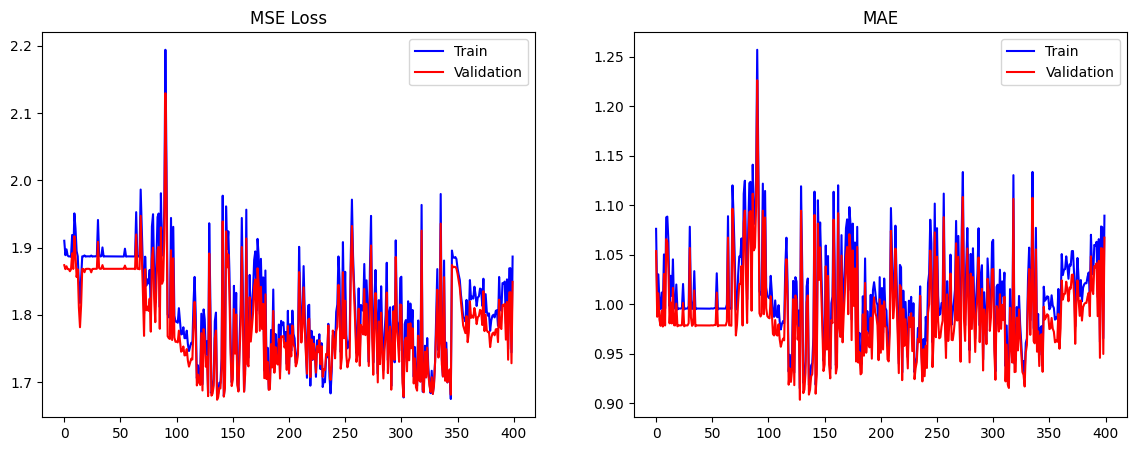

In [ ]:
for lr in lr_list:
  print("\n\nAnálisis del perceptrón multicapa para la vectorización embeddings:")
  print(f"** Epochs: {epochs_default}")
  print(f"** lr: {lr}\n")
  model_path = "best_mlp_embeddings_lr_" + str(lr) + ".pth"
  instantiate_ml_perceptron(train_dl_embeddings, X_train_embeddings_torch, X_test_embeddings_torch, y_train_embeddings_torch, y_test_embeddings_torch,
                            n_hidden_embeddings, epochs_default, lr, model_path)

In [ ]:
def evaluate_model(model_path, X_test_torch, y_test_torch, n_hidden):
  # Paso 1: cargar el modelo guardado
  best_model = MLPerceptron(X_test_torch.size()[1], 1, n_hidden)
  best_model.load_state_dict(torch.load(model_path, weights_only=True))
  best_model.eval()

  # Paso 2: realizar predicciones sobre el conjunto de pruebas
  with torch.no_grad():
      pred_test = best_model(X_test_torch)

  # Paso 3: evaluar las predicciones
  test_mae = mean_absolute_error(y_test_torch.view(-1, 1), pred_test).item()
  return test_mae

In [ ]:
test_mae_tf_idf_lr_0001 = evaluate_model('best_mlp_tf_idf_lr_0.001.pth', X_test_tf_idf_torch, y_test_tf_idf_torch, n_hidden_tf_idf)
test_mae_tf_idf_lr_00055 = evaluate_model('best_mlp_tf_idf_lr_0.0055.pth', X_test_tf_idf_torch, y_test_tf_idf_torch, n_hidden_tf_idf)
test_mae_tf_idf_lr_0055 = evaluate_model('best_mlp_tf_idf_lr_0.055.pth', X_test_tf_idf_torch, y_test_tf_idf_torch, n_hidden_tf_idf)
test_mae_tf_idf_lr_01 = evaluate_model('best_mlp_tf_idf_lr_0.1.pth', X_test_tf_idf_torch, y_test_tf_idf_torch, n_hidden_tf_idf)

test_mae_word2vec_lr_0001 = evaluate_model('best_mlp_word2vec_lr_0.001.pth', X_test_word2vec_torch, y_test_word2vec_torch, n_hidden_word2vec)
test_mae_word2vec_lr_00055 = evaluate_model('best_mlp_word2vec_lr_0.0055.pth', X_test_word2vec_torch, y_test_word2vec_torch, n_hidden_word2vec)
test_mae_word2vec_lr_0055 = evaluate_model('best_mlp_word2vec_lr_0.055.pth', X_test_word2vec_torch, y_test_word2vec_torch, n_hidden_word2vec)
test_mae_word2vec_lr_01 = evaluate_model('best_mlp_word2vec_lr_0.1.pth', X_test_word2vec_torch, y_test_word2vec_torch, n_hidden_word2vec)

test_mae_embeddings_lr_0001 = evaluate_model('best_mlp_embeddings_lr_0.001.pth', X_test_embeddings_torch, y_test_embeddings_torch, n_hidden_embeddings)
test_mae_embeddings_lr_00055 = evaluate_model('best_mlp_embeddings_lr_0.0055.pth', X_test_embeddings_torch, y_test_embeddings_torch, n_hidden_embeddings)
test_mae_embeddings_lr_0055 = evaluate_model('best_mlp_embeddings_lr_0.055.pth', X_test_embeddings_torch, y_test_embeddings_torch, n_hidden_embeddings)
test_mae_embeddings_lr_01 = evaluate_model('best_mlp_embeddings_lr_0.1.pth', X_test_embeddings_torch, y_test_embeddings_torch, n_hidden_embeddings)

# Mostrar resultados
print("Análisis del perceptrón multicapa:\n")

print(f"* TF-IDF:")
print(f"** lr=0.001 -> MAE -> conjunto de pruebas -> {test_mae_tf_idf_lr_0001:.4f}")
print(f"** lr=0.0055 -> MAE -> conjunto de pruebas -> {test_mae_tf_idf_lr_00055:.4f}")
print(f"** lr=0.055 -> MAE -> conjunto de pruebas -> {test_mae_tf_idf_lr_0055:.4f}")
print(f"** lr=0.1 -> MAE -> conjunto de pruebas -> {test_mae_tf_idf_lr_01:.4f}")

print(f"* Word2Vec:")
print(f"** lr=0.001 -> MAE -> conjunto de pruebas -> {test_mae_word2vec_lr_0001:.4f}")
print(f"** lr=0.0055 -> MAE -> conjunto de pruebas -> {test_mae_word2vec_lr_00055:.4f}")
print(f"** lr=0.0055 -> MAE -> conjunto de pruebas -> {test_mae_word2vec_lr_0055:.4f}")
print(f"** lr=0.1 -> MAE -> conjunto de pruebas -> {test_mae_word2vec_lr_01:.4f}")

print(f"* Embeddings:")
print(f"** lr=0.001 -> MAE -> conjunto de pruebas -> {test_mae_embeddings_lr_0001:.4f}")
print(f"** lr=0.0055 -> MAE -> conjunto de pruebas -> {test_mae_embeddings_lr_00055:.4f}")
print(f"** lr=0.055 -> MAE -> conjunto de pruebas -> {test_mae_embeddings_lr_0055:.4f}")
print(f"** lr=0.1 -> MAE -> conjunto de pruebas -> {test_mae_embeddings_lr_01:.4f}")

Análisis del perceptrón multicapa:

* TF-IDF:
** lr=0.001 -> MAE -> conjunto de pruebas -> 0.8695
** lr=0.0055 -> MAE -> conjunto de pruebas -> 0.9880
** lr=0.055 -> MAE -> conjunto de pruebas -> 0.9717
** lr=0.1 -> MAE -> conjunto de pruebas -> 0.8737
* Word2Vec:
** lr=0.001 -> MAE -> conjunto de pruebas -> 0.8818
** lr=0.0055 -> MAE -> conjunto de pruebas -> 0.8959
** lr=0.0055 -> MAE -> conjunto de pruebas -> 1.1399
** lr=0.1 -> MAE -> conjunto de pruebas -> 1.0460
* Embeddings:
** lr=0.001 -> MAE -> conjunto de pruebas -> 0.8942
** lr=0.0055 -> MAE -> conjunto de pruebas -> 0.9822
** lr=0.055 -> MAE -> conjunto de pruebas -> 0.9320
** lr=0.1 -> MAE -> conjunto de pruebas -> 1.0672


#### Análisis de ```dropout```

In [ ]:
# Definir el modelo del perceptrón multicapa
class MLPerceptron(nn.Module):
  def __init__(self, nin, nout, n_hidden):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(nin, n_hidden),
      nn.ReLU(),
      nn.Dropout(0.5), # 0.8 en TF-IDF y 0.5 en Word2vec y embeddings
      nn.Linear(n_hidden, nout)
    )

  def forward(self, x):
      return self.model(x)


def instantiate_ml_perceptron_with_dropout(train_dl, X_train_torch, X_val_torch, y_train_torch, y_val_torch, n_hidden, epochs, lr, model_path):

  # Paso 1: iniciar el perceptrón multicapa
  nin = X_train_torch.size()[1]  # Número de características de entrada
  nout = 1  # Una salida (para regresión)
  my_net = MLPerceptron(nin, nout, n_hidden)

  # Paso 2: definir la función de pérdidas y el optimizador
  loss_func = nn.MSELoss()
  opt = optim.SGD(my_net.parameters(), lr=lr)

  # Paso 3: definir las épocas e inicializar las listas para almacenar los valores de las pérdidas y métricas
  loss_train = np.zeros(epochs)
  loss_val = np.zeros(epochs)
  mae_train = np.zeros(epochs)
  mae_val = np.zeros(epochs)

  # Paso 4: inicializar variables para determinar el mejor modelo
  best_val_mae = float('inf')
  best_epoch = float('inf')
  best_model_state = None

  for epoch in range(epochs):

    # Entrenamiento por lotes
    for xb, yb in train_dl:
      # Ajustar dimensiones de yb
      yb = yb.view(-1, 1)
      # Calcular la salida de la red
      pred = my_net(xb)
      # Calcular las pérdidas para el lote actual
      loss = loss_func(pred, yb)
      # Calcular los gradientes y optimizar los parámetros
      loss.backward()
      opt.step()
      opt.zero_grad()

    # Evaluar las prestaciones al finalizar cada época
    with torch.no_grad():
      pred_train = my_net(X_train_torch)
      loss_train[epoch] = loss_func(pred_train, y_train_torch.view(-1, 1)).item()
      mae_train[epoch] = mean_absolute_error(y_train_torch.view(-1, 1), pred_train).item()

      pred_val = my_net(X_val_torch)
      loss_val[epoch] = loss_func(pred_val, y_val_torch.view(-1, 1)).item()
      mae_val[epoch] = mean_absolute_error(y_val_torch.view(-1, 1), pred_val).item()

    # Guardar el modelo si se encuentra un mejor MAE en validación
    if mae_val[epoch] < best_val_mae:
      best_val_mae = mae_val[epoch]
      best_epoch = epoch
      best_model_state = my_net.state_dict()

    print(f'Epoch [{epoch+1}/{epochs}]\tLoss: {loss_train[epoch]:.4f}\tMAE: {mae_train[epoch]:.4f}\tVal Loss: {loss_val[epoch]:.4f}\tVal MAE: {mae_val[epoch]:.4f}')

  # Guardar el modelo con el mejor MAE en validación
  if best_model_state is not None:
    torch.save(best_model_state, model_path)
    print(f"\nModelo en época {best_epoch+1} tiene el mejor MAE de validación. Almacenando en '{model_path}'...\n\n")

  # Representación gráfica
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(loss_train, 'b', label='Train')
  plt.plot(loss_val, 'r', label='Validation')
  plt.legend()
  plt.title('MSE Loss')
  plt.subplot(1, 2, 2)
  plt.plot(mae_train, 'b', label='Train')
  plt.plot(mae_val, 'r', label='Validation')
  plt.legend()
  plt.title('MAE')
  plt.show()

In [ ]:
epochs = 400

lr_tf_idf = 0.1
lr_word2vec = 0.0055
lr_embeddings = 0.001

n_hidden_tf_idf = 1024
n_hidden_word2vec = 64
n_hidden_embeddings = 512

Análisis del perceptrón multicapa para la vectorización TF-IDF y 'dropout':

Epoch [1/400]	Loss: 1.9139	MAE: 1.0651	Val Loss: 1.8850	Val MAE: 1.0437
Epoch [2/400]	Loss: 1.8464	MAE: 1.0504	Val Loss: 1.8448	Val MAE: 1.0368
Epoch [3/400]	Loss: 1.7656	MAE: 1.0117	Val Loss: 1.7647	Val MAE: 1.0028
Epoch [4/400]	Loss: 1.7114	MAE: 1.0066	Val Loss: 1.7571	Val MAE: 1.0101
Epoch [5/400]	Loss: 1.6512	MAE: 0.9689	Val Loss: 1.7035	Val MAE: 0.9643
Epoch [6/400]	Loss: 1.6806	MAE: 1.0169	Val Loss: 1.7522	Val MAE: 1.0324
Epoch [7/400]	Loss: 1.6205	MAE: 0.9801	Val Loss: 1.7171	Val MAE: 0.9981
Epoch [8/400]	Loss: 1.5297	MAE: 0.9445	Val Loss: 1.7132	Val MAE: 0.9890
Epoch [9/400]	Loss: 1.5656	MAE: 0.9854	Val Loss: 1.7148	Val MAE: 1.0168
Epoch [10/400]	Loss: 1.5394	MAE: 0.9659	Val Loss: 1.6833	Val MAE: 0.9924
Epoch [11/400]	Loss: 1.5354	MAE: 0.9834	Val Loss: 1.7613	Val MAE: 1.0380
Epoch [12/400]	Loss: 1.4270	MAE: 0.9185	Val Loss: 1.6858	Val MAE: 0.9756
Epoch [13/400]	Loss: 1.4054	MAE: 0.9079	Val Loss: 1.6808

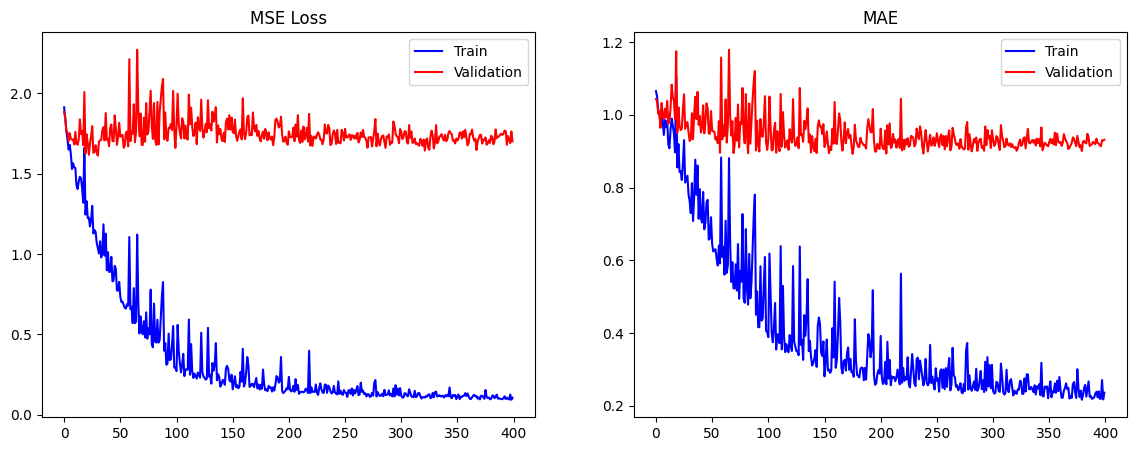

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización TF-IDF y 'dropout':\n")
instantiate_ml_perceptron_with_dropout(train_dl_tf_idf, X_train_tf_idf_torch, X_test_tf_idf_torch, y_train_tf_idf_torch, y_test_tf_idf_torch,
                                       n_hidden_tf_idf, epochs, lr_tf_idf, "best_mlp_tf_idf_dropout.pth")

Análisis del perceptrón multicapa para la vectorización Word2Vec y 'dropout':

Epoch [1/400]	Loss: 2.5679	MAE: 1.2901	Val Loss: 2.6410	Val MAE: 1.3031
Epoch [2/400]	Loss: 2.3810	MAE: 1.2324	Val Loss: 2.3534	Val MAE: 1.2162
Epoch [3/400]	Loss: 2.2712	MAE: 1.1741	Val Loss: 2.2917	Val MAE: 1.1883
Epoch [4/400]	Loss: 2.1526	MAE: 1.1393	Val Loss: 2.1348	Val MAE: 1.1148
Epoch [5/400]	Loss: 2.1506	MAE: 1.1366	Val Loss: 2.0447	Val MAE: 1.0949
Epoch [6/400]	Loss: 2.0765	MAE: 1.1091	Val Loss: 2.0551	Val MAE: 1.0964
Epoch [7/400]	Loss: 2.0935	MAE: 1.1111	Val Loss: 2.0454	Val MAE: 1.0854
Epoch [8/400]	Loss: 2.0406	MAE: 1.0864	Val Loss: 2.0728	Val MAE: 1.0815
Epoch [9/400]	Loss: 1.9967	MAE: 1.0740	Val Loss: 1.9447	Val MAE: 1.0614
Epoch [10/400]	Loss: 2.0206	MAE: 1.0829	Val Loss: 1.9549	Val MAE: 1.0614
Epoch [11/400]	Loss: 1.9807	MAE: 1.0775	Val Loss: 1.9942	Val MAE: 1.0594
Epoch [12/400]	Loss: 1.9918	MAE: 1.0700	Val Loss: 1.9372	Val MAE: 1.0394
Epoch [13/400]	Loss: 1.9567	MAE: 1.0501	Val Loss: 1.97

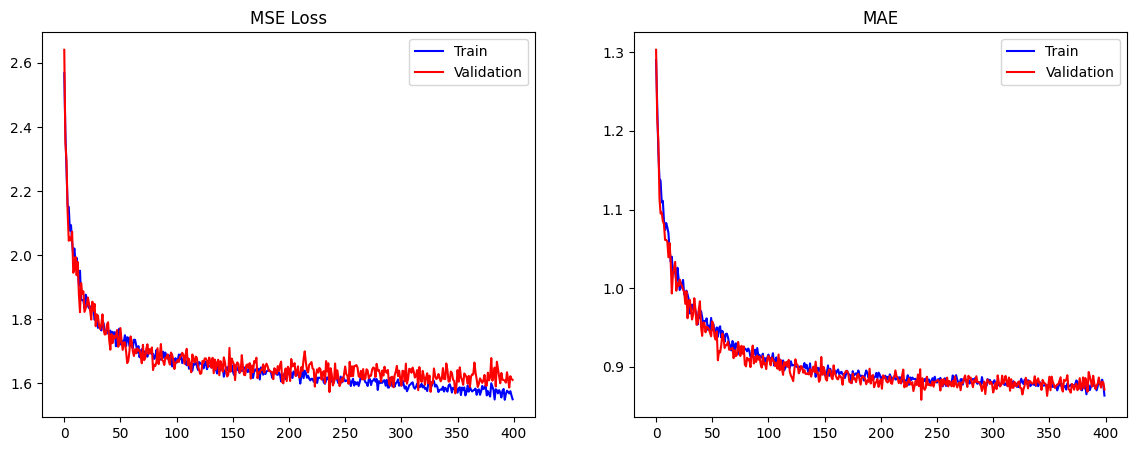

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización Word2Vec y 'dropout':\n")
instantiate_ml_perceptron_with_dropout(train_dl_word2vec, X_train_word2vec_torch, X_test_word2vec_torch, y_train_word2vec_torch, y_test_word2vec_torch,
                                       n_hidden_word2vec, epochs, lr_word2vec, "best_mlp_word2vec_dropout.pth")

Análisis del perceptrón multicapa para la vectorización embeddings y 'dropout':

Epoch [1/400]	Loss: 2.0199	MAE: 1.0763	Val Loss: 1.9761	Val MAE: 1.0605
Epoch [2/400]	Loss: 1.9124	MAE: 1.0107	Val Loss: 1.9728	Val MAE: 1.0240
Epoch [3/400]	Loss: 1.9045	MAE: 1.0027	Val Loss: 1.9751	Val MAE: 1.0191
Epoch [4/400]	Loss: 1.9249	MAE: 1.0138	Val Loss: 1.8473	Val MAE: 0.9869
Epoch [5/400]	Loss: 1.9126	MAE: 1.0096	Val Loss: 1.9045	Val MAE: 1.0187
Epoch [6/400]	Loss: 1.8964	MAE: 1.0006	Val Loss: 1.8979	Val MAE: 1.0050
Epoch [7/400]	Loss: 1.8880	MAE: 0.9958	Val Loss: 1.8617	Val MAE: 0.9942
Epoch [8/400]	Loss: 1.8523	MAE: 0.9933	Val Loss: 1.8603	Val MAE: 0.9840
Epoch [9/400]	Loss: 1.8976	MAE: 0.9995	Val Loss: 1.8470	Val MAE: 0.9895
Epoch [10/400]	Loss: 1.8321	MAE: 0.9876	Val Loss: 1.8509	Val MAE: 0.9814
Epoch [11/400]	Loss: 1.8264	MAE: 0.9889	Val Loss: 1.8491	Val MAE: 0.9691
Epoch [12/400]	Loss: 1.8299	MAE: 0.9914	Val Loss: 1.7980	Val MAE: 0.9691
Epoch [13/400]	Loss: 1.8236	MAE: 0.9904	Val Loss: 1.

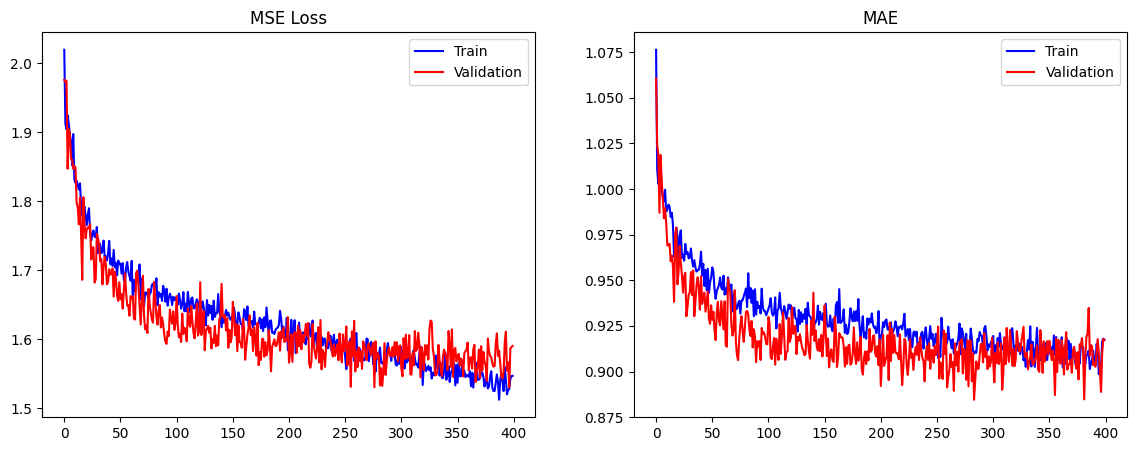

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización embeddings y 'dropout':\n")
instantiate_ml_perceptron_with_dropout(train_dl_embeddings, X_train_embeddings_torch, X_test_embeddings_torch, y_train_embeddings_torch, y_test_embeddings_torch,
                                       n_hidden_embeddings, epochs, lr_embeddings, "best_mlp_embeddings_dropout.pth")

In [ ]:
def evaluate_model(model_path, X_test_torch, y_test_torch, n_hidden):
  # Paso 1: cargar el modelo guardado
  best_model = MLPerceptron(X_test_torch.size()[1], 1, n_hidden)
  best_model.load_state_dict(torch.load(model_path, weights_only=True))
  best_model.eval()

  # Paso 2: realizar predicciones sobre el conjunto de pruebas
  with torch.no_grad():
      pred_test = best_model(X_test_torch)

  # Paso 3: evaluar las predicciones
  test_mae = mean_absolute_error(y_test_torch.view(-1, 1), pred_test).item()
  return test_mae

In [ ]:
test_mae_tf_idf = evaluate_model('best_mlp_tf_idf_dropout.pth', X_test_tf_idf_torch, y_test_tf_idf_torch, n_hidden_tf_idf)
test_mae_word2vec = evaluate_model('best_mlp_word2vec_dropout.pth', X_test_word2vec_torch, y_test_word2vec_torch, n_hidden_word2vec)
test_mae_embeddings = evaluate_model('best_mlp_embeddings_dropout.pth', X_test_embeddings_torch, y_test_embeddings_torch, n_hidden_embeddings)

# Mostrar resultados
print("Análisis del perceptrón multicapa:\n")
print(f"* TF-IDF -> MAE -> conjunto de pruebas -> {test_mae_tf_idf:.4f}")
print(f"* Word2Vec -> MAE -> conjunto de pruebas -> {test_mae_word2vec:.4f}")
print(f"* Embeddings -> MAE -> conjunto de pruebas -> {test_mae_embeddings:.4f}")

Análisis del perceptrón multicapa:

* TF-IDF -> MAE -> conjunto de pruebas -> 0.9087
* Word2Vec -> MAE -> conjunto de pruebas -> 0.8582
* Embeddings -> MAE -> conjunto de pruebas -> 0.8918


#### Análisis de ```early stopping```

In [ ]:
# Definir el modelo del perceptrón multicapa
class MLPerceptron(nn.Module):
  def __init__(self, nin, nout, n_hidden):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(nin, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, nout)
    )

  def forward(self, x):
      return self.model(x)


def instantiate_ml_perceptron_with_early_stopping(train_dl, X_train_torch, X_val_torch, y_train_torch, y_val_torch, n_hidden, epochs, lr, model_path):

  # Paso 1: iniciar el perceptrón multicapa
  nin = X_train_torch.size()[1]  # Número de características de entrada
  nout = 1  # Una salida (para regresión)
  my_net = MLPerceptron(nin, nout, n_hidden)

  # Paso 2: definir la función de pérdidas y el optimizador
  loss_func = nn.MSELoss()
  opt = optim.SGD(my_net.parameters(), lr=lr)

  # Paso 3: definir las épocas e inicializar las listas para almacenar los valores de las pérdidas y métricas
  loss_train = np.zeros(epochs)
  loss_val = np.zeros(epochs)
  mae_train = np.zeros(epochs)
  mae_val = np.zeros(epochs)

  # Paso 4: definir los parámetros para 'early stopping'
  early_stop = False
  min_val_loss = float('inf')
  patience = 10
  min_delta = 0.01
  epochs_no_improve = 0

  # Paso 5: inicializar variables para determinar el mejor modelo
  best_val_mae = float('inf')
  best_epoch = float('inf')
  best_model_state = None

  for epoch in range(epochs):

    # Entrenamiento por lotes
    for xb, yb in train_dl:
      # Ajustar dimensiones de yb
      yb = yb.view(-1, 1)
      # Calcular la salida de la red
      pred = my_net(xb)
      # Calcular las pérdidas para el lote actual
      loss = loss_func(pred, yb)
      # Calcular los gradientes y optimizar los parámetros
      loss.backward()
      opt.step()
      opt.zero_grad()

    # Evaluar las prestaciones al finalizar cada época
    with torch.no_grad():
      pred_train = my_net(X_train_torch)
      loss_train[epoch] = loss_func(pred_train, y_train_torch.view(-1, 1)).item()
      mae_train[epoch] = mean_absolute_error(y_train_torch.view(-1, 1), pred_train).item()

      pred_val = my_net(X_val_torch)
      loss_val[epoch] = loss_func(pred_val, y_val_torch.view(-1, 1)).item()
      mae_val[epoch] = mean_absolute_error(y_val_torch.view(-1, 1), pred_val).item()

    # Guardar el modelo si se encuentra un mejor MAE en validación
    if mae_val[epoch] < best_val_mae:
      best_val_mae = mae_val[epoch]
      best_epoch = epoch
      best_model_state = my_net.state_dict()

    print(f'Epoch [{epoch+1}/{epochs}]\tLoss: {loss_train[epoch]:.4f}\tMAE: {mae_train[epoch]:.4f}\tVal Loss: {loss_val[epoch]:.4f}\tVal MAE: {mae_val[epoch]:.4f}')

    # Comprobar 'early stopping'
    if loss_val[epoch] < min_val_loss - min_delta:
      min_val_loss = loss_val[epoch]
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
          print('Early stopping!')
          loss_val = loss_val[:epoch+1]
          mae_val = mae_val[:epoch+1]
          loss_train = loss_train[:epoch+1]
          mae_train = mae_train[:epoch+1]
          early_stop = True
          break

  # Guardar el modelo con el mejor MAE en validación
  if best_model_state is not None:
    torch.save(best_model_state, model_path)
    print(f"\nModelo en época {best_epoch+1} tiene el mejor MAE de validación. Almacenando en '{model_path}'...\n\n")

  # Representación gráfica
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(loss_train, 'b', label='Train')
  plt.plot(loss_val, 'r', label='Validation')
  plt.legend()
  plt.title('MSE Loss')
  plt.subplot(1, 2, 2)
  plt.plot(mae_train, 'b', label='Train')
  plt.plot(mae_val, 'r', label='Validation')
  plt.legend()
  plt.title('MAE')
  plt.show()

In [ ]:
epochs = 400
lr_tf_idf = 0.001
n_hidden_tf_idf = 1024

Análisis del perceptrón multicapa para la vectorización TF-IDF y 'early stopping':

Epoch [1/400]	Loss: 13.0248	MAE: 3.4086	Val Loss: 12.7208	Val MAE: 3.3657
Epoch [2/400]	Loss: 10.9432	MAE: 3.1443	Val Loss: 10.6679	Val MAE: 3.1025
Epoch [3/400]	Loss: 9.0794	MAE: 2.8804	Val Loss: 8.8329	Val MAE: 2.8398
Epoch [4/400]	Loss: 7.3998	MAE: 2.6122	Val Loss: 7.1828	Val MAE: 2.5732
Epoch [5/400]	Loss: 5.9145	MAE: 2.3405	Val Loss: 5.7277	Val MAE: 2.3041
Epoch [6/400]	Loss: 4.6595	MAE: 2.0712	Val Loss: 4.5031	Val MAE: 2.0360
Epoch [7/400]	Loss: 3.6700	MAE: 1.8150	Val Loss: 3.5428	Val MAE: 1.7792
Epoch [8/400]	Loss: 2.9530	MAE: 1.5894	Val Loss: 2.8524	Val MAE: 1.5556
Epoch [9/400]	Loss: 2.4779	MAE: 1.4020	Val Loss: 2.4003	Val MAE: 1.3709
Epoch [10/400]	Loss: 2.1887	MAE: 1.2504	Val Loss: 2.1299	Val MAE: 1.2214
Epoch [11/400]	Loss: 2.0251	MAE: 1.1570	Val Loss: 1.9809	Val MAE: 1.1319
Epoch [12/400]	Loss: 1.9378	MAE: 1.0881	Val Loss: 1.9045	Val MAE: 1.0665
Epoch [13/400]	Loss: 1.8929	MAE: 1.0381	Val L

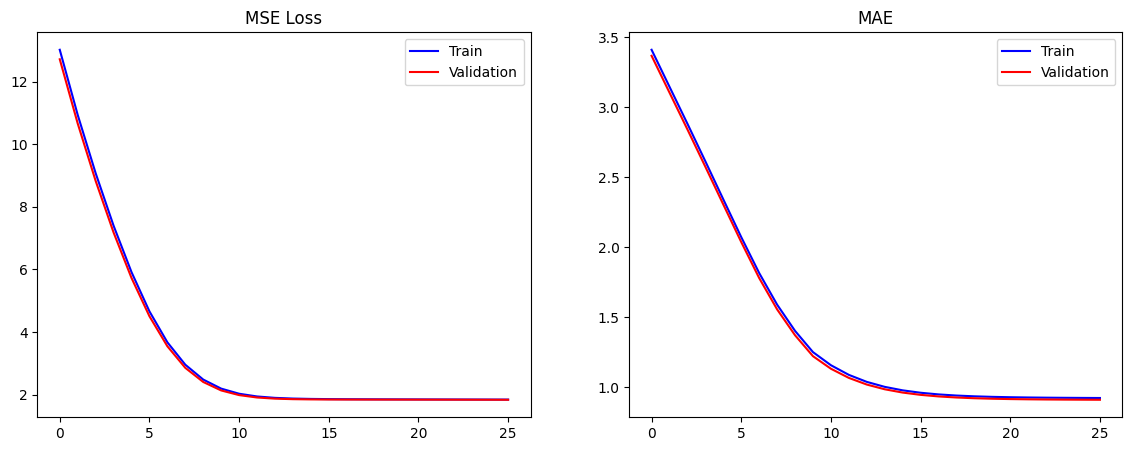

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización TF-IDF y 'early stopping':\n")
instantiate_ml_perceptron_with_early_stopping(train_dl_tf_idf, X_train_tf_idf_torch, X_test_tf_idf_torch, y_train_tf_idf_torch, y_test_tf_idf_torch,
                                              n_hidden_tf_idf, epochs, lr_tf_idf, "best_mlp_tf_idf_es.pth")

In [ ]:
# Definir el modelo del perceptrón multicapa
class MLPerceptron(nn.Module):
  def __init__(self, nin, nout, n_hidden):
    super().__init__()
    self.model = nn.Sequential(
      nn.Linear(nin, n_hidden),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(n_hidden, nout)
    )

  def forward(self, x):
      return self.model(x)


def instantiate_ml_perceptron_with_dropout_and_early_stopping(train_dl, X_train_torch, X_val_torch, y_train_torch, y_val_torch, n_hidden, epochs, lr, model_path):

  # Paso 1: iniciar el perceptrón multicapa
  nin = X_train_torch.size()[1]  # Número de características de entrada
  nout = 1  # Una salida (para regresión)
  my_net = MLPerceptron(nin, nout, n_hidden)

  # Paso 2: definir la función de pérdidas y el optimizador
  loss_func = nn.MSELoss()
  opt = optim.SGD(my_net.parameters(), lr=lr)

  # Paso 3: definir las épocas e inicializar las listas para almacenar los valores de las pérdidas y métricas
  loss_train = np.zeros(epochs)
  loss_val = np.zeros(epochs)
  mae_train = np.zeros(epochs)
  mae_val = np.zeros(epochs)

  # Paso 4: definir los parámetros para 'early stopping'
  early_stop = False
  min_val_loss = float('inf')
  patience = 10
  min_delta = 0.001
  epochs_no_improve = 0

  # Paso 5: inicializar variables para determinar el mejor modelo
  best_val_mae = float('inf')
  best_epoch = float('inf')
  best_model_state = None

  for epoch in range(epochs):

    # Entrenamiento por lotes
    for xb, yb in train_dl:
      # Ajustar dimensiones de yb
      yb = yb.view(-1, 1)
      # Calcular la salida de la red
      pred = my_net(xb)
      # Calcular las pérdidas para el lote actual
      loss = loss_func(pred, yb)
      # Calcular los gradientes y optimizar los parámetros
      loss.backward()
      opt.step()
      opt.zero_grad()

    # Evaluar las prestaciones al finalizar cada época
    with torch.no_grad():
      pred_train = my_net(X_train_torch)
      loss_train[epoch] = loss_func(pred_train, y_train_torch.view(-1, 1)).item()
      mae_train[epoch] = mean_absolute_error(y_train_torch.view(-1, 1), pred_train).item()

      pred_val = my_net(X_val_torch)
      loss_val[epoch] = loss_func(pred_val, y_val_torch.view(-1, 1)).item()
      mae_val[epoch] = mean_absolute_error(y_val_torch.view(-1, 1), pred_val).item()

    # Guardar el modelo si se encuentra un mejor MAE en validación
    if mae_val[epoch] < best_val_mae:
      best_val_mae = mae_val[epoch]
      best_epoch = epoch
      best_model_state = my_net.state_dict()

    print(f'Epoch [{epoch+1}/{epochs}]\tLoss: {loss_train[epoch]:.4f}\tMAE: {mae_train[epoch]:.4f}\tVal Loss: {loss_val[epoch]:.4f}\tVal MAE: {mae_val[epoch]:.4f}')

    # Comprobar 'early stopping'
    if loss_val[epoch] < min_val_loss - min_delta:
      min_val_loss = loss_val[epoch]
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
          print('Early stopping!')
          loss_val = loss_val[:epoch+1]
          mae_val = mae_val[:epoch+1]
          loss_train = loss_train[:epoch+1]
          mae_train = mae_train[:epoch+1]
          early_stop = True
          break

  # Guardar el modelo con el mejor MAE en validación
  if best_model_state is not None:
    torch.save(best_model_state, model_path)
    print(f"\nModelo en época {best_epoch+1} tiene el mejor MAE de validación. Almacenando en '{model_path}'...\n\n")

  # Representación gráfica
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(loss_train, 'b', label='Train')
  plt.plot(loss_val, 'r', label='Validation')
  plt.legend()
  plt.title('MSE Loss')
  plt.subplot(1, 2, 2)
  plt.plot(mae_train, 'b', label='Train')
  plt.plot(mae_val, 'r', label='Validation')
  plt.legend()
  plt.title('MAE')
  plt.show()

In [ ]:
epochs = 400

lr_word2vec = 0.0055
lr_embeddings = 0.001

n_hidden_word2vec = 64
n_hidden_embeddings = 512

Análisis del perceptrón multicapa para la vectorización word2vec, 'dropout' y 'early stopping':

Epoch [1/400]	Loss: 2.7494	MAE: 1.3501	Val Loss: 2.6842	Val MAE: 1.3214
Epoch [2/400]	Loss: 2.4108	MAE: 1.2390	Val Loss: 2.3912	Val MAE: 1.2133
Epoch [3/400]	Loss: 2.2380	MAE: 1.1620	Val Loss: 2.2234	Val MAE: 1.1553
Epoch [4/400]	Loss: 2.1390	MAE: 1.1363	Val Loss: 2.1814	Val MAE: 1.1307
Epoch [5/400]	Loss: 2.1141	MAE: 1.1201	Val Loss: 2.0146	Val MAE: 1.0965
Epoch [6/400]	Loss: 2.0950	MAE: 1.1045	Val Loss: 2.0285	Val MAE: 1.0878
Epoch [7/400]	Loss: 1.9893	MAE: 1.0639	Val Loss: 2.0468	Val MAE: 1.0660
Epoch [8/400]	Loss: 1.9607	MAE: 1.0565	Val Loss: 2.0209	Val MAE: 1.0653
Epoch [9/400]	Loss: 1.8994	MAE: 1.0496	Val Loss: 1.9525	Val MAE: 1.0622
Epoch [10/400]	Loss: 1.9376	MAE: 1.0500	Val Loss: 1.9249	Val MAE: 1.0444
Epoch [11/400]	Loss: 1.9168	MAE: 1.0463	Val Loss: 1.8681	Val MAE: 1.0198
Epoch [12/400]	Loss: 1.9115	MAE: 1.0417	Val Loss: 1.9219	Val MAE: 1.0431
Epoch [13/400]	Loss: 1.8853	MAE: 1.0

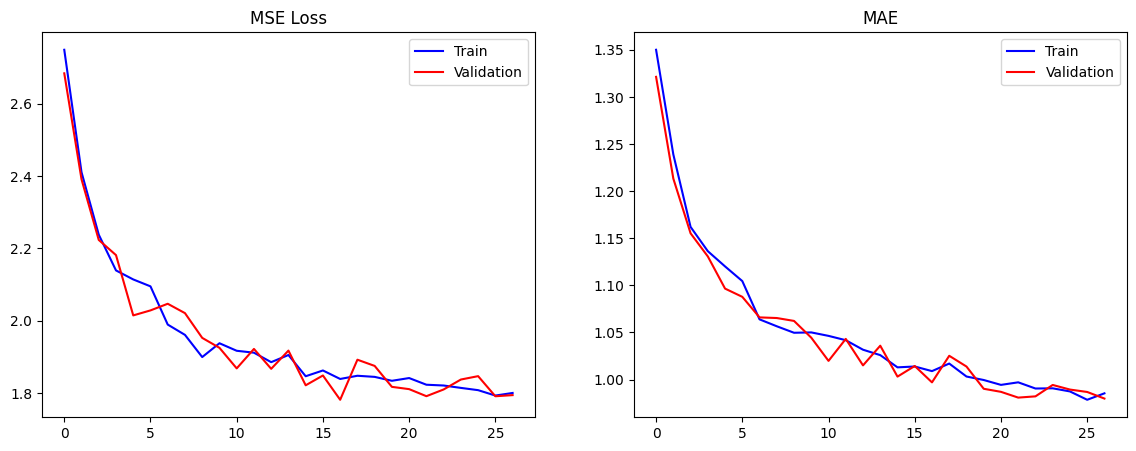

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización word2vec, 'dropout' y 'early stopping':\n")
instantiate_ml_perceptron_with_dropout_and_early_stopping(train_dl_word2vec, X_train_word2vec_torch, X_test_word2vec_torch, y_train_word2vec_torch, y_test_word2vec_torch,
                                              n_hidden_word2vec, epochs, lr_word2vec, "best_mlp_word2vec_dropout_and_es.pth")

Análisis del perceptrón multicapa para la vectorización embeddings, 'dropout' y 'early stopping':

Epoch [1/400]	Loss: 1.9845	MAE: 1.0681	Val Loss: 1.9152	Val MAE: 1.0320
Epoch [2/400]	Loss: 1.8963	MAE: 1.0067	Val Loss: 1.8999	Val MAE: 0.9895
Epoch [3/400]	Loss: 1.9264	MAE: 1.0131	Val Loss: 1.9001	Val MAE: 0.9928
Epoch [4/400]	Loss: 1.9029	MAE: 1.0017	Val Loss: 1.8889	Val MAE: 0.9854
Epoch [5/400]	Loss: 1.8823	MAE: 0.9945	Val Loss: 1.8789	Val MAE: 0.9900
Epoch [6/400]	Loss: 1.9114	MAE: 0.9987	Val Loss: 1.8574	Val MAE: 0.9833
Epoch [7/400]	Loss: 1.9131	MAE: 1.0042	Val Loss: 1.8244	Val MAE: 0.9746
Epoch [8/400]	Loss: 1.8624	MAE: 0.9990	Val Loss: 1.8350	Val MAE: 0.9908
Epoch [9/400]	Loss: 1.8477	MAE: 1.0002	Val Loss: 1.8414	Val MAE: 0.9724
Epoch [10/400]	Loss: 1.8510	MAE: 1.0055	Val Loss: 1.8209	Val MAE: 0.9933
Epoch [11/400]	Loss: 1.8416	MAE: 0.9917	Val Loss: 1.8298	Val MAE: 0.9881
Epoch [12/400]	Loss: 1.8316	MAE: 0.9845	Val Loss: 1.7677	Val MAE: 0.9577
Epoch [13/400]	Loss: 1.8098	MAE: 0

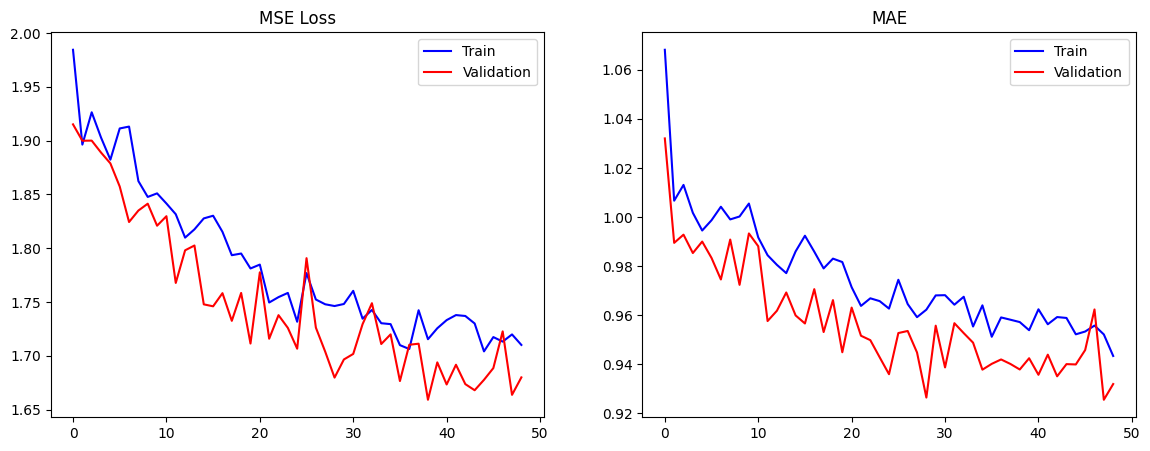

In [ ]:
print("Análisis del perceptrón multicapa para la vectorización embeddings, 'dropout' y 'early stopping':\n")
instantiate_ml_perceptron_with_dropout_and_early_stopping(train_dl_embeddings, X_train_embeddings_torch, X_test_embeddings_torch, y_train_embeddings_torch, y_test_embeddings_torch,
                                              n_hidden_embeddings, epochs, lr_embeddings, "best_mlp_embeddings_dropout_and_es.pth")

In [ ]:
def evaluate_model(model_path, X_test_torch, y_test_torch, n_hidden):
  # Paso 1: cargar el modelo guardado
  best_model = MLPerceptron(X_test_torch.size()[1], 1, n_hidden)
  best_model.load_state_dict(torch.load(model_path, weights_only=True))
  best_model.eval()

  # Paso 2: realizar predicciones sobre el conjunto de pruebas
  with torch.no_grad():
      pred_test = best_model(X_test_torch)

  # Paso 3: evaluar las predicciones
  test_mae = mean_absolute_error(y_test_torch.view(-1, 1), pred_test).item()
  return test_mae

In [ ]:
test_mae_tf_idf = evaluate_model('best_mlp_tf_idf_es.pth', X_test_tf_idf_torch, y_test_tf_idf_torch, n_hidden_tf_idf)

In [ ]:
test_mae_word2vec = evaluate_model('best_mlp_word2vec_dropout_and_es.pth', X_test_word2vec_torch, y_test_word2vec_torch, n_hidden_word2vec)
test_mae_embeddings = evaluate_model('best_mlp_embeddings_dropout_and_es.pth', X_test_embeddings_torch, y_test_embeddings_torch, n_hidden_embeddings)

In [ ]:
# Mostrar resultados
print("Análisis del perceptrón multicapa:\n")
print(f"* TF-IDF -> MAE -> conjunto de pruebas -> {test_mae_tf_idf:.4f}")
print(f"* Word2Vec -> MAE -> conjunto de pruebas -> {test_mae_word2vec:.4f}")
print(f"* Embeddings -> MAE -> conjunto de pruebas -> {test_mae_embeddings:.4f}")

Análisis del perceptrón multicapa:

* TF-IDF -> MAE -> conjunto de pruebas -> 0.9103
* Word2Vec -> MAE -> conjunto de pruebas -> 0.9232
* Embeddings -> MAE -> conjunto de pruebas -> 0.8963


#### Análisis de los resultados

Primero se entrenó, validó y evaluó el perceptrón simple. Los resultados obtenidos sobre el conjunto de pruebas se muestran en la siguiente tabla.

|                                   | **Embeddings**    | **TF-IDF**        | **Word2Vec**      |
|-----------------------------------|-------------------|-------------------|-------------------|
| **Red Neuronal**                  | **MAE (pruebas)** | **MAE (pruebas)** | **MAE (pruebas)** |
| Perceptrón simple + lr=0.01       | 0.95              | **0.85**          | 0.88              |

De esta tabla se puede concluir que la mejor vectorización es TF-IDF. No obstante, el perceptrón simple es un regresor que, debido a su naturaleza lineal, no capta de manera adecuada las relaciones no lineales que pueden existir entre los datos. Por este motivo, se decidió añadir nuevas capas (lineales y no lineales) al regresor. En concreto, se añadió una capa oculta y una función de activación ReLU. Los nuevos resultados obtenidos sobre el conjunto de pruebas se muestran en la siguiente tabla.

|                                   | **Embeddings**    | **TF-IDF**        | **Word2Vec**      |
|-----------------------------------|-------------------|-------------------|-------------------|
| **Red Neuronal**                  | **MAE (pruebas)** | **MAE (pruebas)** | **MAE (pruebas)** |
| Perceptrón simple + lr=0.01       | 0.95              | 0.85              | 0.88              |
| Perceptrón multicapa + lr=0.01    | 1.03              | 1.11              | **0.92**          |

Como se puede observar, la mejor vectorización para el perceptrón multicapa es Word2Vec. Sin embargo, se observa que las prestaciones al añadir nuevas capas son peores que las obtenidas en el perceptrón simple. Por este motivo, se decidió probar diferentes valores de tasa de aprendizaje (0'001, 0'0055, 0'055 y 0'1) para intentar mejorar las métricas, obteniendo los resultados que se muestran en la siguiente tabla.

|                                   | **Embeddings**    | **TF-IDF**        | **Word2Vec**      |
|-----------------------------------|-------------------|-------------------|-------------------|
| **Red Neuronal**                  | **MAE (pruebas)** | **MAE (pruebas)** | **MAE (pruebas)** |
| Perceptrón simple + lr=0.01       | 0.95              | 0.85              | 0.88              |
|**Perceptrón multicapa + lr=0.001**| **0.89**          | **0.86**          | **0.88**          |
| Perceptrón multicapa + lr=0.0055  | 0.98              | 0.98              | 0.89              |
| Perceptrón multicapa + lr=0.01    | 1.03              | 1.11              | 0.92              |
| Perceptrón multicapa + lr=0.055   | 0.93              | 0.97              | 1.13              |
| Perceptrón multicapa + lr=0.1     | 1.06              | 0.87              | 1.04              |

De esta tabla se puede concluir que la mejor tasa de aprendizaje para los tres tipos de vectorización en el perceptrón multicapa es 0'001, con la vectorización TF-IDF mostrando el mejor rendimiento general en este caso. No obstante, se decidió continuar analizando si con las técnicas de ```dropout``` y ```early stopping``` se podían mejorar las prestaciones.

La técnica de ```dropout``` se aplicó para TF-IDF con tasa de aprendizaje 0'1, Word2Vec con tasa de aprendizaje 0'0055 y embeddings con tasa de aprendizaje 0'001. Lo lógico hubiera sido aplicar ```dropout``` para las tasas de aprendizaje que mejores valores ofrecían en el punto anterior (0'001 en los tres casos). Sin embargo, en TF-IDF y Word2Vec con tasa de aprendizaje 0'001 no había sobreentrenamiento, por lo que aplicar esta técnica no tenía sentido. En su lugar, se utilizaron las segundas mejores tasas de aprendizaje para ver si se podían mejorar sus prestaciones.

Además, el valor de la probabilidad de ```dropout``` se estableció inicialmente en 0'5 para las tres técnicas de vectorización. Este valor fue suficiente para evitar el sobreentrenamiento en Word2Vec y embeddings. Sin embargo, no ocurrió lo mismo en TF-IDF, lo que llevó a aumentar su tasa de ```dropout``` a 0'8 en un intento de mitigar este problema. Aunque este incremento ayudó a reducir el sobreentrenamiento, los resultados apenas mejoraron. Por ello, se considera que una posible mejora futura sería aplicar una técnica de regularización adicional para reducir aún más el sobreentrenamiento en TF-IDF.

Los resultados obtenidos tras aplicar ```dropout``` se muestran en la siguiente tabla. De ellos, se concluye que aplicar ```dropout``` mejora ligeramente las prestaciones de Word2Vec y embeddings. Sin embargo, no ocurre lo mismo con TF-IDF.

|                                   | **Embeddings**    | **TF-IDF**        | **Word2Vec**      |
|-----------------------------------|-------------------|-------------------|-------------------|
| **Red Neuronal**                  | **MAE (pruebas)** | **MAE (pruebas)** | **MAE (pruebas)** |
| Perceptrón simple + lr=0.01       | 0.95              | 0.85              | 0.88              |
| Perceptrón multicapa + lr=0.001   | **0.89**          | **0.86**          | **0.88**          |
| Perceptrón multicapa + lr=0.0055  | 0.98              | 0.98              | 0.89              |
| Perceptrón multicapa + lr=0.01    | 1.03              | 1.11              | 0.92              |
| Perceptrón multicapa + lr=0.055   | 0.93              | 0.97              | 1.13              |
| Perceptrón multicapa + lr=0.1     | 1.06              | 0.87              | 1.04              |
| MLP + lr=0.1 + dropout            | -                 | **0.91**          | -                 |
| MLP + lr=0.0055 + dropout         | -                 | -                 | **0.85**          |
| MLP + lr=0.001 + dropout          | **0.89**          | -                 | -                 |


La técnica de ```early stopping``` se aplicó para el mejor modelo de cada vectorización: TF-IDF con tasa de aprendizaje 0'001, Word2Vec con tasa de aprendizaje 0'0055 y ```dropout```, y embeddings con tasa de aprendizaje 0'001 y ```dropout```. Los resultados obtenidos se muestran en la siguiente tabla. De ellos, se concluye que aplicar ```early stopping``` no mejora las prestaciones de ninguna vectorización. La razón de este empeoramiento de los resultados es que ```early stopping``` hace que el entrenamiento se detenga exceisvamente pronto.

|                                   | **Embeddings**    | **TF-IDF**        | **Word2Vec**      |
|-----------------------------------|-------------------|-------------------|-------------------|
| **Red Neuronal**                  | **MAE (pruebas)** | **MAE (pruebas)** | **MAE (pruebas)** |
| Perceptrón simple + lr=0.01       | 0.95              | 0.85              | 0.88              |
| Perceptrón multicapa + lr=0.001   | 0.89              | **0.86**          | 0.88              |
| Perceptrón multicapa + lr=0.0055  | 0.98              | 0.98              | 0.89              |
| Perceptrón multicapa + lr=0.01    | 1.03              | 1.11              | 0.92              |
| Perceptrón multicapa + lr=0.055   | 0.93              | 0.97              | 1.13              |
| Perceptrón multicapa + lr=0.1     | 1.06              | 0.87              | 1.04              |
| MLP + lr=0.1 + dropout            | -                 | 0.91              | -                 |
| MLP + lr=0.0055 + dropout         | -                 | -                 | **0.85**          |
| MLP + lr=0.001 + dropout          | **0.89**          | -                 | -                 |
| MLP + lr=0.001 + es               | -                 | **0.91**          | -                 |
| MLP + lr=0.0055 + dropout + es    | -                 | -                 | **0.92**          |
| MLP + lr=0.001 + dropout + es     | **0.89**          | -                 | -                 |


**Elección de la red neuronal:**

A la vista de los resultados, la red neuronal que mejores prestaciones tiene es el perceptrón multicapa con vectorización Word2Vec, tasa de aprendizaje 0'0055 y ```dropout``` ya que es el que mejor valor de MAE de pruebas tiene.

|                                   | **Embeddings**    | **TF-IDF**        | **Word2Vec**      |
|-----------------------------------|-------------------|-------------------|-------------------|
| **Red Neuronal**                  | **MAE (pruebas)** | **MAE (pruebas)** | **MAE (pruebas)** |
| Perceptrón simple + lr=0.01       | 0.95              | 0.85              | 0.88              |
| Perceptrón multicapa + lr=0.001   | 0.89              | 0.86              | 0.88              |
| Perceptrón multicapa + lr=0.0055  | 0.98              | 0.98              | 0.89              |
| Perceptrón multicapa + lr=0.01    | 1.03              | 1.11              | 0.92              |
| Perceptrón multicapa + lr=0.055   | 0.93              | 0.97              | 1.13              |
| Perceptrón multicapa + lr=0.1     | 1.06              | 0.87              | 1.04              |
| MLP + lr=0.1 + dropout            | -                 | 0.91              | -                 |
| **MLP + lr=0.0055 + dropout**     | -                 | -                 | **0.85**          |
| MLP + lr=0.001 + dropout          | 0.89              | -                 | -                 |
| MLP + lr=0.001 + es               | -                 | 0.91              | -                 |
| MLP + lr=0.0055 + dropout + es    | -                 | -                 | 0.92              |
| MLP + lr=0.001 + dropout + es     | 0.89              | -                 | -                 |


###  Técnica implementada en la librería Scikit-learn: k-NN

La hoja de ruta es la siguiente:

1) Obtener los conjuntos de entrenamiento y de pruebas. Es importante mencionar que el conjunto de entrenamiento incluye el conjunto de validación porque en este apartado se utilizará validación cruzada. Además, las muestras asignadas a cada conjunto son las mismas que en redes neuronales ya que se les ha asignado el mismo ```random_state```.

2) El regresor k-NN cuenta con [varios hiperparámetros](https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). En este proyecto se analiza el valor óptimo del número de vecinos (```n_neighbors```) en un rango de 1 a 100. El motivo de elegir un rango amplio de vecinos se debe a que el número de muestras utilizadas para entrenar el regresor k-NN es elevado. El resto de los hiperparámetros mantienen sus valores por defecto.

3) El valor óptimo de ```n_neighbors``` se va a determinar mediante validación cruzada utilizando el conjunto de entrenamiento. En concreto, se aplica ```10-Fold cv```, tal y como se realizó en la práctica de regresión de la asignatura. Además, la métrica para determinar el valor óptimo de ```n_neighbors``` es el MAE (Mean Absolute Error). El motivo de su elección es que es una métrica que se suele emplear en problemas de regresión, además de ser la métrica que se ha ido analizando en la red neuronal.

4) Determinar las prestaciones de cada regresor k-NN hallando el MAE sobre el conjunto de pruebas.

In [ ]:
# Dividir en conjunto de entrenamiento y de pruebas
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(X_tf_idf, y, test_size=0.2, random_state=42)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
X_train_embeddings, X_test_embeddings, y_train_embeddings, y_test_embeddings = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

In [ ]:
def kNN_analysis(X_train, X_test, y_train, y_test):
    # Definir el rango de 'n_neighbors' a validar
    n_neighbors_range = range(1, 101)

    # Crear el modelo base
    knn_regressor = KNeighborsRegressor()

    # Configurar GridSearchCV para encontrar el mejor valor de 'n_neighbors'
    # usando validación cruzada
    param_grid = {'n_neighbors': n_neighbors_range}
    grid_search = GridSearchCV(knn_regressor, param_grid, cv=10, scoring='neg_mean_absolute_error')

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Obtener el mejor valor de 'n_neighbors'
    best_n_neighbors = grid_search.best_params_['n_neighbors']

    # Evaluar el modelo con el mejor 'n_neighbors' en los datos de prueba
    best_knn_model = grid_search.best_estimator_
    y_pred = best_knn_model.predict(X_test)

    # Calcular el error absoluto medio (MAE) en los datos de prueba
    test_mae = mean_absolute_error(y_test, y_pred)

    # Imprimir resultados del análisis
    print("\nAnálisis del k-NN:\n")
    print(f"* Número de muestras de entrenamiento: {len(X_train)}")
    print("* Validación cruzada: 10-fold")
    print("* Hiperparámetros a validar: 'n_neighbors' con un rango de 1 a 100")
    print(f"* 'n_neighbors' óptimo: {best_n_neighbors}\n")
    print(f"* Número de muestras de pruebas: {len(X_test)}")
    print(f"* MAE en el conjunto de pruebas: {test_mae}")

    # Obtener el historial de resultados de la validación cruzada
    mean_test_scores = -grid_search.cv_results_['mean_test_score']

    # Graficar la relación entre 'n_neighbors' y el MAE
    plt.figure(figsize=(8, 6))
    plt.plot(n_neighbors_range, mean_test_scores, marker='o', color='b', linewidth=0.6, markersize=3, label='MAE')
    plt.axvline(x=best_n_neighbors, color='r', linestyle='--', label=f"'n_neighbors' óptimo = {best_n_neighbors}")
    plt.title("Evolución del MAE respecto a 'n_neighbors' en validación cruzada")
    plt.xlabel("Número de vecinos ('n_neighbors')")
    plt.ylabel("Error absoluto medio (MAE)")
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Análisis del k-NN:

* Número de muestras de entrenamiento: 3200
* Validación cruzada: 10-fold
* Hiperparámetros a validar: 'n_neighbors' con un rango de 1 a 100
* 'n_neighbors' óptimo: 42

* Número de muestras de pruebas: 800
* MAE en el conjunto de pruebas: 0.8539620535714286


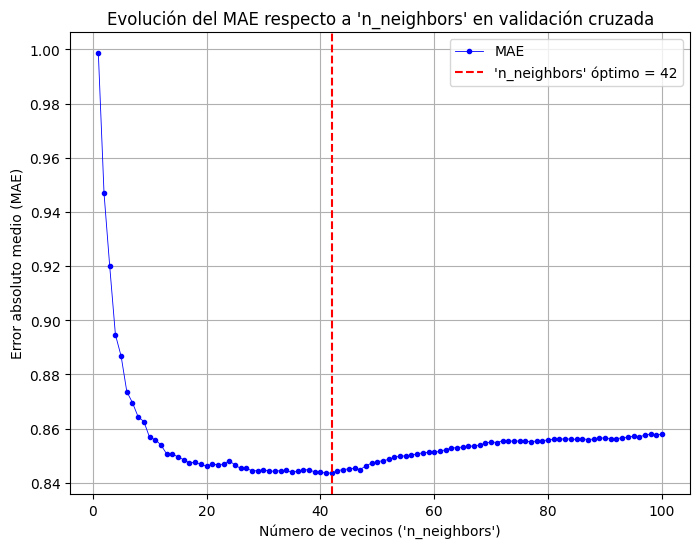

In [ ]:
# Análisis del k-NN con la vectorización TF-IDF
kNN_analysis(X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf)


Análisis del k-NN:

* Número de muestras de entrenamiento: 3200
* Validación cruzada: 10-fold
* Hiperparámetros a validar: 'n_neighbors' con un rango de 1 a 100
* 'n_neighbors' óptimo: 37

* Número de muestras de pruebas: 800
* MAE en el conjunto de pruebas: 0.8674197635135136


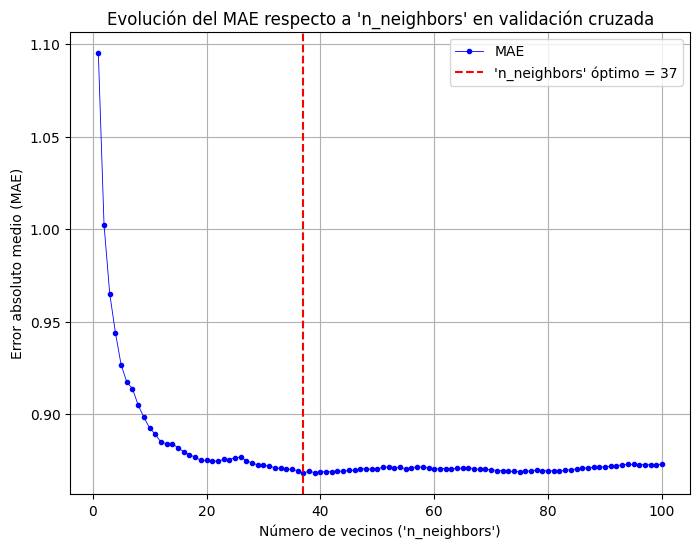

In [ ]:
# Análisis del k-NN con la vectorización Word2Vec
kNN_analysis(X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec)


Análisis del k-NN:

* Número de muestras de entrenamiento: 3200
* Validación cruzada: 10-fold
* Hiperparámetros a validar: 'n_neighbors' con un rango de 1 a 100
* 'n_neighbors' óptimo: 37

* Número de muestras de pruebas: 800
* MAE en el conjunto de pruebas: 0.8171241554054055


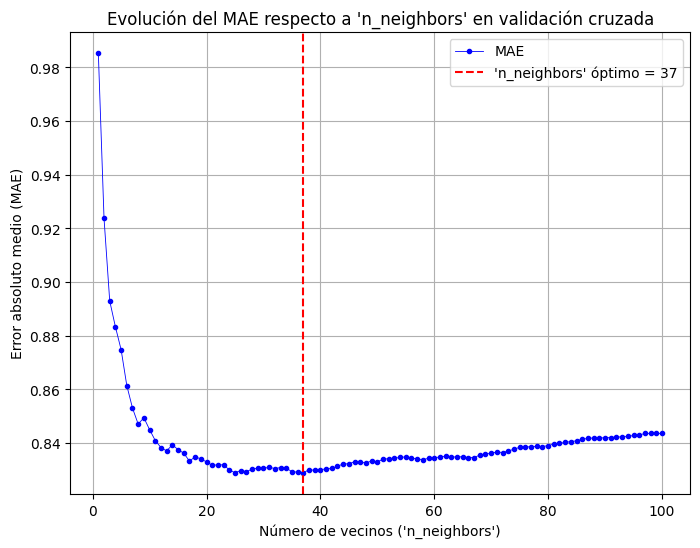

In [ ]:
# Análisis del k-NN con la vectorización embeddings
kNN_analysis(X_train_embeddings, X_test_embeddings, y_train_embeddings, y_test_embeddings)

**Discusión de los resultados:**

Los resultados mostrados en la siguiente tabla indican, para cada regresor k-NN, su número óptimo de vecinos y el MAE obtenido sobre el conjunto de pruebas. Se observa que la vectorización que mejores prestaciones ofrece es embeddings, seguido de TF-IDF y Word2Vec. Además, en cuanto al número de vecinos, las vectorizaciones embeddings y Word2Vec necesitan un número menor de vecinos respecto a TF-IDF.

| **Vectorización**  | **Número de vecinos óptimo** | **MAE de pruebas** |
|--------------------|------------------------------|-----------------------|
| **Embeddings**     | 37                           | 0.81                  |
| **TF-IDF**         | 42                           | 0.85                  |
| **Word2Vec**       | 37                           | 0.86                  |


**Elección del modelo k-NN:**

A la vista de los resultados, el regresor k-NN que mejores prestaciones tiene es el que utiliza la vectorización embeddings. Por un lado, es el que mejor valor de MAE de pruebas tiene. Por otro lado, es el que menor número de vecinos necesita.

## 5) Comparación de lo obtenido en el punto anterior con el fine-tuning de un modelo preentrenado con Hugging Face.

 El modelo preentrenado que se va a utilizar para realizar fine-tuning es BERT. Se ha elegido porque es el transformers principal que se ha estudiado en la asignatura. Un trabajo futuro sería analizar otros modelos y diferentes arquitecturas (```encoder-only```, ```decoder-only``` y ```encoder-decoder```), teniendo en cuenta las limitaciones de hardware que tiene Google Colab.

 Los pasos para realizar el fine-tuning son:

  1) Tokenizar el conjunto de entrenamiento y de pruebas.

  2) Adaptar los conjuntos de datos a objetos de la clase ```Dataset```, necesaria para trabajar con Hugging Face.

  3) Cargar el modelo preentrenado BERT y configurarlo para un problema de regresión.

  4) Entrenar el modelo con el conjunto de entrenamiento.

  5) Evaluar el modelo con el conjunto de pruebas y la métrica MAE. El motivo de su elección es que es una métrica que se suele emplear en problemas de regresión, además de ser la métrica que se ha ido analizando en la red neuronal y el regresor k-NN.

  El resultado obtenido es un modelo que, al ser evaluado sobre el conjunto de pruebas, obtiene un MAE de 0'85.

In [ ]:
# Obtener el conjunto de datos adaptado
corpus_in_transformers = adapt_corpus_for_transformers(corpus_selected_features_in_df)

In [ ]:
# Guardar el conjunto de datos adaptado en formato JSON
with open('corpus_fine_tuning_4000_samples.json', 'w') as f:
  json.dump(corpus_in_transformers, f)

In [ ]:
# Importar el conjunto de datos adaptado en formato JSON
with open('corpus_fine_tuning_4000_samples.json', 'r') as f:
  corpus_in_transformers = json.load(f)

In [ ]:
# Obtener las salidas del conjunto de datos
y = rating_in_lists

In [ ]:
# Dividir en conjunto de entrenamiento y de pruebas
X_in_transformers = corpus_in_transformers
X_train_in_transformers, X_test_in_transformers, y_train_in_transformers, y_test_in_transformers = train_test_split(X_in_transformers, y, test_size=0.2, random_state=42)

In [ ]:
# Paso 1: tokenizar el conjunto de entrenamiento y de pruebas
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_encodings = tokenizer(X_train_in_transformers, truncation=True, padding=True, max_length=512)
X_test_encodings = tokenizer(X_test_in_transformers, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print(f"La primera receta del conjunto de entrenamiento es:\n{X_train_in_transformers[0]}\n")
# 'input_ids' representa la posición del token en el diccionario del modelo
print(f"'input_ids' de la primera receta del conjunto de entrenamiento:\n{X_train_encodings['input_ids'][0]}\n")
# 'attention_mask' indica si el 'input_id' se corresponde con una palabra del diccionario ('1') o es padding ('0')
print(f"'attention_mask' de la primera receta del conjunto de entrenamiento:\n{X_train_encodings['attention_mask'][0]}\n")

La primera receta del conjunto de entrenamiento es:
Date: month 5 and day 16. Categories: Sandwich, turkey, Low Fat, Grill/Barbecue, Self. Directions: In a large bowl, combine egg white, cheese, turkey, salt, kidney beans, breadcrumbs, onion, cilantro, and salsa and mix thoroughly. Divide the mixture and form into 4 patties. Tuck any pieces of cheese into the burgers with your fingertip to prevent scorching. Heat oil in a large nonstick pan over medium heat. Add burgers and cook 6 to 7 minutes per side or until cooked through. Serve on English muffins, accompanied by lettuce and extra salsa (to use as a topping).

'input_ids' de la primera receta del conjunto de entrenamiento:
[101, 3058, 1024, 3204, 1019, 1998, 2154, 2385, 1012, 7236, 1024, 11642, 1010, 4977, 1010, 2659, 6638, 1010, 18651, 1013, 26375, 1010, 2969, 1012, 7826, 1024, 1999, 1037, 2312, 4605, 1010, 11506, 8288, 2317, 1010, 8808, 1010, 4977, 1010, 5474, 1010, 14234, 13435, 1010, 7852, 26775, 25438, 2015, 1010, 20949, 1010,

In [ ]:
# Paso 2: adaptar los conjuntos de datos a objetos de la clase Dataset
class Dataset(torch.utils.data.Dataset):
  def __init__(self, text, label):
    self.text = text
    self.label = label

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.text.items()}
    item['label'] = torch.tensor(self.label[idx])
    return item

  def __len__(self):
    return len(self.label)


train_dataset = Dataset(X_train_encodings, y_train_in_transformers)
test_dataset = Dataset(X_test_encodings, y_test_in_transformers)

In [ ]:
# Paso 3: cargar el modelo preentrenado BERT y configurarlo para un problema de regresión (num_labels=1)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.to("cuda")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Definir la función para calcular la métrica
metric_mae = evaluate.load("mae")

def compute_metrics(p):
  predictions, labels = p
  predicted_values = predictions.flatten()
  mae = metric_mae.compute(predictions=predicted_values, references=labels)
  return {"MAE": mae}

In [ ]:
# Configurar los parámetros de entrenamiento
training_args = TrainingArguments(
  output_dir="./results_fine_tunning",
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  warmup_steps=500,
  weight_decay=0.01,
  logging_dir='./logs',
  logging_steps=10,
)

# Configurar el entrenador
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
  compute_metrics=compute_metrics
)

In [ ]:
# Paso 4: entrenar el modelo con el conjunto de entrenamiento
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,11.981800
20,10.630900
30,9.774600
40,9.287000
50,6.963100
60,4.855900
70,3.123900
80,2.185800
90,1.914500
100,1.403400


TrainOutput(global_step=600, training_loss=2.434899328549703, metrics={'train_runtime': 947.1339, 'train_samples_per_second': 10.136, 'train_steps_per_second': 0.633, 'total_flos': 2525843452723200.0, 'train_loss': 2.434899328549703, 'epoch': 3.0})

In [ ]:
# Paso 5: evaluar el nuevo modelo con el conjunto de pruebas y la métrica MAE
eval_result = trainer.evaluate()
print(eval_result)

Trainer is attempting to log a value of "{'mae': 0.8510517973537207}" of type <class 'dict'> for key "eval/MAE" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.536065697669983, 'eval_MAE': {'mae': 0.8510517973537207}, 'eval_runtime': 23.1733, 'eval_samples_per_second': 34.523, 'eval_steps_per_second': 0.561, 'epoch': 3.0}


In [ ]:
# Guardar el nuevo modelo
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

## 6) Extensión

La extensión que se va a implementar es: ```uso de un summarizer preentrenado (utilizando pipelines de Hugging Face) para proporcionar un resumen de la característica 'directions'```.

- Se va a probar la capacidad de resumir de tres modelos: [facebook/bart-large-cnn](https://huggingface.co/facebook/bart-large-cnn)<sup>[1]</sup>, [meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) y [DISLab/SummLlama3.2-3B](https://huggingface.co/DISLab/SummLlama3.2-3B)<sup>[2]</sup>.
- Para determinar cómo de buenos son los resúmenes obtenidos, lo ideal sería compararlos con los realizados por un ser humano. Sin embargo, para optimizar el tiempo de trabajo, los resúmenes obtenidos de los tres modelos se van a comparar con los resúmenes generados por ChatGPT-4o.
- Para obtener un valor cuantitativo de la calidad de los resúmenes obtenidos, se van a aplicar las [métricas ROUGE y BLEU](https://neptune.ai/blog/llm-evaluation-text-summarization). El motivo de su elección es el bajo coste computacional que conllevan. Además, se utilizará la métrica [BERT score](https://medium.com/@abonia/bertscore-explained-in-5-minutes-0b98553bfb71) que, aunque suponga un coste computacional mayor, determinará mejor la calidad de los resúmenes obtenidos.

<sup>[1]</sup> Se trata de un modelo con arquitectura encoder-decoder. En concreto, es el fine-tuning de [facebook/bart-large](https://huggingface.co/facebook/bart-large).

<sup>[2]</sup> Se trata de un modelo con arquitectura decoder-only. En concreto, es el fine-tuning de [meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct), que a su vez es el fine-tunning de [meta-llama/Llama-3.2-3B](https://huggingface.co/meta-llama/Llama-3.2-3B).

In [ ]:
def get_rouge_score(other_model_summaries, chatgpt_4o_summaries):
  """ Calcula 'precision', 'recall' y 'f1' de la métrica ROUGE-1 para
  cada comparación."""

  rouge = Rouge()
  rouge_precision = []
  rouge_recall = []
  rouge_f1 = []

  for i in range(len(chatgpt_4o_summaries)):
    hypothesis = other_model_summaries[i]
    reference = chatgpt_4o_summaries[i]
    scores_i = rouge.get_scores(hypothesis, reference)
    rouge_precision.append(scores_i[0]['rouge-1']['p'])
    rouge_recall.append(scores_i[0]['rouge-1']['r'])
    rouge_f1.append(scores_i[0]['rouge-1']['f'])

  return rouge_precision, rouge_recall, rouge_f1


def get_bleu_score(other_model_summaries, chatgpt_4o_summaries):
  """Calcula el valor de la métrica BLEU para cada comparación."""

  bleu = evaluate.load("bleu")
  bleu_scores = []

  for i in range(len(chatgpt_4o_summaries)):
    prediction = [other_model_summaries[i]]
    reference = [chatgpt_4o_summaries[i]]
    bleu_score_i = bleu.compute(predictions=prediction, references=reference)['bleu']
    bleu_scores.append(bleu_score_i)

  return bleu_scores


def get_bert_score(other_model_summaries, chatgpt_4o_summaries):
  """Calcula el valor de la métrica BERT score para cada comparación."""

  bert = evaluate.load("bertscore")
  bert_precision = []
  bert_recall = []
  bert_f1 = []

  for i in range(len(chatgpt_4o_summaries)):
    prediction = [other_model_summaries[i]]
    reference = [chatgpt_4o_summaries[i]]
    bert_score_i = bert.compute(predictions=prediction, references=reference, lang="en")
    bert_precision.append(bert_score_i['precision'])
    bert_recall.append(bert_score_i['recall'])
    bert_f1.append(bert_score_i['f1'])

  return bert_precision, bert_recall, bert_f1

In [ ]:
def get_directions_from_corpus_in_df(corpus_in_df):
  """Concatena el listado de instrucciones de cada receta en un único string."""

  # Paso 1: eliminar valores nulos y escoger 46 muestras aleatorias
  corpus_cleaned_in_df = corpus_in_df.dropna(subset=['directions']).copy()
  corpus_random_in_df = corpus_cleaned_in_df.sample(n=46)

  # Paso 2: filtrar las características deseadas
  directions_in_df = corpus_random_in_df[['directions']]

  # Paso 3: convertir el corpus a formato de listas
  directions_in_lists = directions_in_df['directions'].tolist()

  # Paso 4: concatenar las instrucciones para que haya un string por receta
  directions_concatenated_in_lists = [' '.join(directions) for directions in directions_in_lists]

  return directions_concatenated_in_lists, directions_in_df

In [ ]:
# Adaptar el corpus de datos
directions_concatenated_in_lists, directions_in_df = get_directions_from_corpus_in_df(corpus_in_df)

In [ ]:
# Ejemplo: instrucciones de la primera receta adaptada
print(f"Las instrucciones para la primera receta sin adaptar: {directions_in_df['directions'].loc[4448]}\n")
print(f"Las instrucciones para la primera receta adaptada: {directions_concatenated_in_lists[0]}")

Las instrucciones para la primera receta sin adaptar: ['Combine dried peaches and water in heavy medium saucepan. Let stand 30 minutes. Bring to boil. Reduce heat and simmer gently until peaches are very soft, about 20 minutes.', 'Meanwhile, place 1/4 cup Pêcher Mignon in small bowl; sprinkle gelatin over. Set aside to soften. Beat 3 egg yolks, 1/2 cup sugar and remaining 1/4 cup Pêcher Mignon in top of double boiler until light in color. Set over simmering water and stir until thick enough to coat back of spoon when finger is drawn across (do not boil), about 2 minutes. Transfer to small bowl.', 'Add gelatin to hot peach mixture and stir until dissolved. Transfer to processor and puree until smooth. Pour into large bowl. Cool to room temperature, stirring occasionally (do not let peach mixture set up.)', 'Add custard to peach mixture and whisk to combine. Using electric mixer, beat cream in medium bowl to soft peaks. Mix 1/3 of whipped cream into peach mixture to lighten. Gently fold 

In [ ]:
# Guardar el corpus de datos adaptado en un fichero JSON
with open("corpus_extension_46_samples.json", "w") as f:
  json.dump(directions_concatenated_in_lists, f)

In [ ]:
# Importar el corpus de datos adaptado desde el fichero JSON
with open("corpus_extension_46_samples.json", "r") as f:
    directions_concatenated_in_lists = json.load(f)

In [ ]:
chatgpt_4o_summaries = [
    "This recipe makes a peach mousse. First, dried peaches are softened in water, boiled, and pureed. Gelatin is dissolved in peach liquid, then combined with a custard made from egg yolks, sugar, and Pêcher Mignon. Whipped cream and beaten egg whites are gently folded into the peach mixture to create a light and airy mousse. The mousse is refrigerated for 8 hours or overnight, then piped into glasses and topped with fresh mint before serving.",
    "This recipe involves making a lobster gelee. First, two lobsters are boiled, their meat removed, and the shells are used to create a flavorful stock with vegetables, herbs, and seasonings. After the stock is reduced, it's strained and mixed with gelatin to form a base. The lobster meat is cut into pieces, chilled, and placed into molds with a sprig of tarragon and a bit of claw meat. The gelatin mixture is poured over the lobster and chilled until set. Once firm, the gelee is unmolded and served with a drizzle of fresh tarragon oil.",
    "This recipe makes pistachio and berry biscotti with a chocolate dip. First, preheat the oven to 350°F and prepare a baking sheet with parchment paper. Mix dry ingredients (flour, baking powder, salt) and beat wet ingredients (sugar, eggs, oil, almond extract) until smooth. Combine the two mixtures and fold in pistachios, dried berries, and white chocolate. Form the dough into two strips and bake at 350°F for 30 minutes. After cooling for 30 minutes, reduce the oven to 325°F and cut the logs into slices. Arrange the slices upright on a baking sheet and bake for 20 minutes until golden. Once cooled, dip the biscotti in melted white or bittersweet chocolate and chill until set. Store in an airtight container for up to 5 days or freeze for up to 2 weeks.",
    "This recipe involves making spiced cookies. First, preheat the oven to 325°F and mix together ginger, cinnamon, cardamom, cloves, star anise, and sugar in a small bowl. Cut a chilled dough log into 1/2-inch rounds and dip one side of each round into the spice mixture. Arrange the rounds on a parchment-lined cookie sheet and bake for 15 to 20 minutes until golden brown. Cool the cookies on a wire rack.",
    "This recipe suggests starting with a 2:2 ratio of spirit to soda to highlight the flavor of the base spirit. If the drink is too strong, gradually add more soda, 1 ounce at a time, until it reaches your preferred taste. Keep track of the measurements to replicate your ideal mix in the future.",
    "This recipe makes a moist, spiced carrot cake with a cream cheese frosting. To prepare, preheat the oven to 325°F and grease three 9-inch cake pans. Mix sugar, vegetable oil, and eggs, then add sifted dry ingredients like flour, baking powder, cinnamon, and nutmeg. Stir in grated carrots, chopped pecans, and raisins, and bake the batter for about 45 minutes. After cooling, layer the cakes with frosting in between, and decorate with the remaining frosting. The cake can be made ahead and served cold or at room temperature.",
    "This recipe involves coating trout with a seasoned cornmeal mixture and frying it until crispy. A flavorful salsa is made by sautéing onion, garlic, and serrano chili, then adding tomatoes, clam juice, lemon juice, and honey, and simmering briefly. The salsa is finished with fresh tarragon and seasoned with salt and pepper. The cooked trout is topped with the salsa and garnished with pumpkin seeds for a delicious, savory dish.",
    "This recipe involves cooking quinoa and steaming a mix of vegetables. First, rinse the quinoa and cook it with water and salt until tender, then cool it. While the quinoa cooks, peel and cube a turnip, slice garlic and scallions, and chop beans. Steam the squash, turnip, and garlic until almost tender, then add the beans, quinoa, salt, and pepper, steaming for an additional 3 minutes. Finally, toss the mixture with scallions and serve.",
    "This recipe involves making a chili butter mixture, chilling it, and using it to enhance both sautéed onions and potatoes. Start by mixing chili butter, seasonings, and rolling it into a cylinder. Then, sauté onions until golden, steam and brown potatoes, and combine them with the onions and parsley. Season and set aside. Season and cook steaks to your desired doneness in hot skillets. Serve the steaks on top of the potato mixture, topped with slices of the chilled chili butter for extra flavor.",
    "This recipe involves making a chilled soup by puréeing soup ingredients with salt and pepper, then straining and chilling the mixture for at least 4 hours. Just before serving, toss crab with oil, vinegar, salt, and pepper, and place it in the center of soup bowls. Ladle the chilled soup around the crab, and garnish with chopped chives and diced yellow pepper. The soup can be prepared a day ahead.",
    "This recipe involves making savory seafood-filled crêpes with a curried sauce. First, scallops and scrod are poached in water, then combined with sautéed carrots, peas, and a rich curry-flavored sauce made with butter, flour, milk, chutney, and lemon juice. The seafood mixture is then used as a filling for crêpes. To prepare the crêpes, a batter made from flour, curry powder, eggs, broth, and butter is blended, rested, and then cooked in a crêpe pan. The filled crêpes are baked until heated through and garnished with parsley and lemon slices. The filling can be made a day ahead, and crêpes can be prepared up to three days in advance.",
    "This recipe is for a chilled zucchini soup. Zucchini is sautéed in oil until golden, then simmered with water until tender. After cooling, the mixture is blended until smooth, then combined with yogurt, mint, salt, and pepper. The soup is chilled for at least 6 hours before serving, with additional seasoning added as needed.",
    "This recipe involves making individual rhubarb tartlets. First, cook rhubarb with brown sugar to create a syrup, then chill overnight. For the tartlet crusts, roll out pastry, cut into rounds, bake, and flatten. Blend ricotta with powdered sugar for the filling, and bake the tartlets with a brush of egg glaze and a cheese mixture. Meanwhile, reduce rhubarb juices to a syrup. Broil the rhubarb with brown sugar until crisp, then spoon it over the tartlets, drizzling with the syrup before serving.",
    "This recipe is for making chewy oat cookies with chocolate and ginger. First, you combine oats, flours, salt, and baking soda in a food processor and pulse until the oats are coarsely chopped. Then, beat butter and brown sugar until fluffy, and add egg, honey, and vanilla. Mix in the dry oat mixture, followed by chocolate and ginger. Drop rounded tablespoons of dough onto baking sheets and bake at 375°F for 14-16 minutes until golden and slightly crisp on the edges. Cool on racks and store in covered containers with waxed paper between layers.",
    "This recipe involves roasting eggplants and serving them with a flavorful vinaigrette. First, halved eggplants are brushed with oil, seasoned, and broiled until browned. They are then roasted in the oven until tender. While the eggplants cook, a vinaigrette is made by blending olive oil, cumin, cilantro, parsley, garlic, salt, cayenne, and lemon juice. Once the eggplants are done, they are served at room temperature, drizzled with the vinaigrette.",
    "This recipe involves making a bourbon-mint syrup by mixing bourbon, chopped mint, and sugar, then letting it stand for 20 minutes. Meanwhile, pineapple is prepared by trimming, peeling, and slicing it into thin rounds. The bourbon-mint mixture is strained over the pineapple, which is then gently tossed with whole mint leaves for a flavorful and refreshing dish.",
    "This recipe makes plum soufflés with a plum sauce. To prepare the soufflés, you create foil collars for four 3/4-cup soufflé dishes, then cook a plum and sugar mixture until reduced and smooth. You whisk together egg yolks, corn syrup, butter, and sugar over simmering water until thick, then fold in whipped cream, plum puree, and the egg mixture. The soufflés are frozen overnight. For the sauce, a similar plum and sugar mixture is simmered, pureed, and chilled. The soufflés are served with the chilled sauce and fresh plum slices.",
    "This recipe is for a creamy parsnip soup with a spiced apple garnish. First, sauté onion and curry powder in butter and olive oil, then add broth and parsnips, cooking until soft. Puree the soup until smooth, then chill if desired. Stir in shredded apples and yogurt. For garnish, fry apple peel strips until crispy. Serve the soup warm, topped with the fried apple peel and seasoned with salt.",
    "This recipe is for a citrusy green salad with a flavorful dressing. To make the dressing, whisk together lemon juice, shallot, thyme, orange peel, and oil, then season with salt and pepper. For the salad, combine greens, green onions, radishes, and dill in a large bowl. Toss with the dressing and add oranges before serving. The dressing can be made ahead and chilled.",
    "This recipe involves cooking steaks and preparing a flavorful sauce. First, dry and season steaks, then sear them in a hot skillet with oil until medium-rare. While the steaks cook, sauté garlic and almonds in another pan, then add vegetables and spices, cooking until softened. After removing the steaks, use the leftover fat in the skillet to cook the vegetables with tomato paste, vinegar, raisins, and sugar to make a slightly thickened sauce. Finally, season the sauce and serve it over the steaks.",
    "This recipe is for a hearty white bean and potato soup with rosemary, arugula, and a Parmesan oil topping. First, Great Northern beans are soaked overnight, then simmered with bay leaves and rosemary. Potatoes are sautéed with garlic, then cooked in chicken stock until soft. The beans and their cooking liquid are added to the potatoes and simmered until tender. The soup is seasoned with salt and pepper, then cooled or served immediately. A Parmesan oil, made by blending Parmesan cheese and olive oil, is stirred into the soup along with sautéed garlic and red pepper flakes. Arugula is added for freshness, and the soup is simmered again before serving. The soup can be made ahead and stored in the fridge for up to 2 days.",
    "This recipe makes a rum-soaked Bundt cake. To prepare, preheat the oven and butter and flour a 10-cup Bundt pan. Mix fruit and rum, and let it sit for 30 minutes. Combine dry ingredients in a separate bowl. Cream sugar and butter, adding eggs one at a time, then blend in the fruit mixture and dry ingredients. Pour the batter into the prepared pan and bake for about 1 hour and 15 minutes. Once cooled, glaze the cake with a warm rum-corn syrup mixture. Let the cake mellow at room temperature for a day before refrigerating. It can be made up to 2 weeks in advance.",
    "This recipe makes a ginger and lemon zest ice cream. First, steep ginger and lemon zest in hot water, then strain and cool the mixture. Heat milk and sugar until the sugar dissolves, then whisk some of it into beaten eggs. Combine the egg mixture with the remaining milk, cook briefly to form a custard, and chill. Once cold, mix in the ginger tea and churn the mixture in an ice cream maker. After churning, freeze the ice cream in a chilled container and serve within 24 hours for the best texture, optionally garnishing with fresh fruit.",
    "This recipe makes a meringue roulade filled with whipped cream and strawberries. To prepare, beat egg whites and sugar into a stiff meringue, bake it in a sheet pan, and cool. Then, whip cream and mix strawberries with preserves. Spread the strawberry mixture on the meringue, top with whipped cream, and roll it up jelly-roll style. Chill the roulade, dust with powdered sugar, and serve with fresh strawberries.",
    "This recipe involves brining pork overnight in a cider-based mixture, then cooking it with a flavorful apple and leek sauce. First, prepare a cider brine with salt, allspice, and bay leaves, and let it cool before soaking the pork in it overnight. For the sauce, sauté leeks in butter and cream until tender, and cook apples in butter, sugar, stock, and Calvados until golden and tender. After grilling or broiling the pork, reheat the leeks and apples. Serve the pork on top of the creamed leeks, with the apples drizzled over the top.",
    "This recipe involves grilling veal with a flavorful spice rub. The veal is first coated with a mix of red pepper flakes, porcini powder, sugar, salt, and black pepper, then grilled over direct heat until browned. It is then moved to indirect heat and grilled slowly until it reaches an internal temperature of 115°F. After resting, the loin is separated from the bones and grilled again for crispness, while the loin is briefly reheated. The veal is sliced, sprinkled with sea salt, and served with the bones. The dish can be made ahead and reheated before serving.",
    "This recipe is for flavorful lemongrass turkey burgers. The process begins by making a paste with lemongrass, garlic, shallot, ginger, chile, and fish sauce, which is then mixed with ground turkey to form patties. After chilling the patties to enhance flavor, a tangy lime sauce is prepared with lime juice, sugar, fish sauce, and red-pepper flakes. The patties are grilled until cooked through and then assembled into burgers with fresh herbs and the lime sauce, served on buns.",
    "This recipe involves making a simple dressing by whisking together oil, salt, and pepper. Chicken breasts are seasoned and sautéed until cooked through, then sliced. The dish is assembled by placing watercress on plates, topping it with chicken, mango, and red onion, and drizzling the dressing over the top before serving.",
    "This recipe makes a simple butter sauce. First, you boil wine, shallot, and lemon juice until reduced by three-quarters. Then, lower the heat and gradually whisk in butter until fully melted. Once the butter is incorporated, remove from heat and stir in dill, seasoning with salt and pepper to taste.",
    "This recipe involves sautéing onion and bacon, then adding tomatoes, garlic, Sherry, wine, and stock to create a flavorful base. The mixture is simmered and reduced, then blended until smooth. Chipotle chilies and oregano are stirred in, followed by cream for richness. The soup is seasoned with salt and pepper before serving. Chipotle chilies in adobo sauce are used for added heat and flavor.",
    "This recipe makes a chocolate almond semifreddo. First, line a loaf pan with plastic wrap and chill it. Cook almonds with butter and salt, then chill them. Melt chocolate in a bowl over hot water, and beat eggs and sugar over simmering water until thick and pale. Fold the melted chocolate, vanilla, and almond extract into the egg mixture. Whip cream to stiff peaks and gently fold it into the egg mixture along with the chilled almonds. Pour the mixture into the prepared pan and freeze for 8 hours or overnight. Once frozen, unmold, slice, and serve with Lemon Rhubarb Cake Roll.",
    "This recipe involves making a bacon-molasses butter to serve with grilled steaks. First, bake bacon slices brushed with molasses and sprinkled with pepper at 375°F for about 15 minutes, then chop and mix with butter. Season with salt and pepper, and refrigerate if making in advance. For the steaks, season with salt and pepper, then grill over medium-high heat until cooked to your desired doneness. Top each steak with the bacon-molasses butter before serving.",
    "This recipe makes a creamy almond panna cotta topped with candied almonds and cherries. First, gelatin is dissolved in milk, then combined with a warm milk-cream mixture flavored with almond and vanilla extracts. After letting the mixture set, it is divided into glasses and chilled for about 4 hours. For the topping, candied almonds are made by toasting almonds with sugar, and cherries are mixed with almond liqueur (optional) and sugar. Once the panna cotta has set, the cherries and candied almonds are added as a final garnish. This dessert can be made ahead and kept refrigerated for up to two days.",
    "This recipe makes a brandied cherry cocktail. Start by combining cherries, kirsch, and sugar in a bowl, and let it sit for 24 hours. (The cherries can be made up to 2 weeks ahead.) Chill two Martini glasses in the freezer for at least 2 hours. When ready to serve, place 3 brandied cherries in each glass and crush them. In a cocktail shaker, mix ice, Cognac, orange curaçao, lemon juice, and cherry liqueur. Shake well, strain into the prepared glasses, and serve.",
    "This recipe details how to make fluffy, fermented bean dumplings. First, soak and rinse beans, then blend them into a smooth puree. Rinse and squeeze cream of rice cereal, and mix it with the bean paste. Let the mixture ferment for 8 to 12 hours. After fermentation, gently stir in baking soda and let the batter rest. Prepare the dumpling racks by lining them with oiled cheesecloth. Steam the dumplings for 12-15 minutes, then remove and keep warm. For serving, place two dumplings per plate, make an indentation, and pour sesame oil into the center before serving.",
    "This recipe outlines how to make grilled corn with garlic butter. First, prepare garlic butter by mixing softened butter and minced garlic, then season with salt and pepper. Grill corn on high heat for 15-20 minutes, turning occasionally, until tender. Once grilled, unwrap the corn, spread with garlic butter, squeeze lime juice over it, and sprinkle with cheese. Serve immediately. The garlic butter can be made ahead and stored in the fridge or freezer.",
    "This recipe makes a refreshing cocktail. First, prepare a Collins glass by rubbing half the rim with lime and coating it with kosher salt. In a shaker, muddle cucumber slices, then add tequila, lime juice, agave syrup, and celery shrub. Shake with ice until chilled, then pour into the prepared glass.",
    "This recipe is for a creamy lobster chowder. Start by rendering bacon fat in a pot, then sauté onions and add butter and flour. Simmer broth with bay leaves and paprika, then add potatoes and thyme to cook until tender. Afterward, stir in half-and-half, corn, peppers, and scallions, seasoning with salt and pepper. Finally, add lobster and parsley just before serving.",
    "This recipe involves sautéing squid with garlic, chile, tomatoes, wine, raisins, and capers to create a flavorful seafood sauce. Meanwhile, pasta is cooked until al dente, then tossed with the squid mixture, basil, pine nuts, and lemon zest. The dish is finished with a drizzle of olive oil and served hot.",
    "This recipe makes a savory plantain and beef casserole. Start by preparing a filling with crumbled beef, sautéed onions, bell peppers, tomatoes, olives, and seasonings, simmered until most of the liquid evaporates. Meanwhile, slice and fry plantains until golden brown. In a baking dish, layer fried plantains, beef filling, and Parmesan cheese, repeating the layers, then pour a beaten egg mixture over the top. Bake until the casserole is heated through and bubbly, then cool before serving. Optionally, unmold the pie for a more elegant presentation.",
    "This recipe involves making a coffee granita and a whipped cream topping with Sambuca. First, dissolve granulated sugar in coffee and chill the mixture, then freeze it while stirring every 30 minutes until it becomes frozen and granular. Meanwhile, beat cream with confectioners' sugar and Sambuca until soft peaks form. To serve, spoon the Sambuca cream into glasses and top with a scoop of the coffee granita, finishing with a sprinkle of chocolate shavings.",
    "This recipe involves making a savory mushroom and miso sauce. First, sauté onions and mushroom caps in a skillet with butter and olive oil until softened. Meanwhile, warm vegetable stock in a separate pan. In a food processor, blend wine, garlic, flour, misos, nutritional yeast, and mustard into a paste, then whisk this into the warm stock. Bring the mixture to a boil, then simmer, adding a ladleful of the stock to the sautéed mushrooms to deglaze the pan. Combine everything in the stock pot, simmer for 30 minutes, and adjust seasoning with salt and pepper. Serve the sauce hot over your dish of choice.",
    "This recipe involves blending tomatoes, stock, onion, cumin, garlic, and chile into a smooth mixture. The sauce is cooked in a pan with oil until reduced by half, then beans are added. Eggs are cracked into the sauce, cooked until the whites are set and yolks are runny, and the dish is served on tortillas. It's topped with cheese, avocado, cilantro, and a lime garnish.",
    "This recipe is for a zucchini and cheddar cheese omelet. First, sauté zucchini in butter until tender, then set it aside. In a separate bowl, beat egg yolks with creamy herb cheese, and in another, beat egg whites to soft peaks. Fold the yolk mixture into the egg whites. Pour the egg mixture into the skillet, sprinkle with zucchini and cheddar cheese, and cook until the omelet sets. Fold it over, cover, and cook for a few more minutes until puffed and cooked through. Serve the omelet on a plate.",
    "This recipe involves broiling Portobello mushrooms and serving them topped with soft scrambled eggs. First, the mushrooms are prepared by removing the stems and scraping out the centers, then brushed with olive oil, seasoned, and broiled until tender. Meanwhile, eggs are whisked with Parmesan, rosemary, salt, and pepper, then gently scrambled in butter until soft. The broiled mushrooms are arranged on plates, topped with the scrambled eggs, and sprinkled with additional Parmesan before serving. The dish can be made ahead and reheated if needed.",
    "This recipe involves making a ginger-cardamom custard with poached meringue. First, separate eggs and beat the egg whites with sugar to stiff peaks. Simmer milk with ginger and cardamom, then poach dollops of the meringue in the milk. While poaching, prepare the custard by whisking egg yolks, sugar, cornstarch, and hot milk, then cook until thickened. Strain and cool the custard in an ice bath. Serve the chilled custard in bowls, topping each with poached meringue and a sprinkle of nuts."
]

### meta-llama/Llama-3.2-3B-Instruct

In [ ]:
from huggingface_hub import InferenceClient
client = InferenceClient(api_key="YOUR_HUGGING_FACE_API_KEY_HERE")

In [ ]:
def format_chat_template_llama_base(directions):
  """Adapta el prompt de entrada para 'meta-llama/Llama-3.2-3B-Instruct'."""
  content = f"Please summarize the input document: {directions}"
  message = [{"role": "user", "content": content}]
  return message


def generate_summaries_llama_base(directions_concatenated_in_lists):
  """Genera un listado que contiene los resúmenes de cada receta para 'meta-llama/Llama-3.2-3B-Instruct'."""
  summaries = []
  for i, directions in enumerate(directions_concatenated_in_lists):
    print(f"Procesando la receta {i+1} de {len(directions_concatenated_in_lists)}")
    message = format_chat_template_llama_base(directions)
    completion = client.chat.completions.create(model="meta-llama/Llama-3.2-3B-Instruct", messages=message, max_tokens=500) # Uso de Serverless Inference API de HF
    summaries.append(completion.choices[0].message.content)
  return summaries

In [ ]:
# Generar los resúmenes
summaries_llama_base = generate_summaries_llama_base(directions_concatenated_in_lists)

Procesando la receta 1 de 46
Procesando la receta 2 de 46
Procesando la receta 3 de 46
Procesando la receta 4 de 46
Procesando la receta 5 de 46
Procesando la receta 6 de 46
Procesando la receta 7 de 46
Procesando la receta 8 de 46
Procesando la receta 9 de 46
Procesando la receta 10 de 46
Procesando la receta 11 de 46
Procesando la receta 12 de 46
Procesando la receta 13 de 46
Procesando la receta 14 de 46
Procesando la receta 15 de 46
Procesando la receta 16 de 46
Procesando la receta 17 de 46
Procesando la receta 18 de 46
Procesando la receta 19 de 46
Procesando la receta 20 de 46
Procesando la receta 21 de 46
Procesando la receta 22 de 46
Procesando la receta 23 de 46
Procesando la receta 24 de 46
Procesando la receta 25 de 46
Procesando la receta 26 de 46
Procesando la receta 27 de 46
Procesando la receta 28 de 46
Procesando la receta 29 de 46
Procesando la receta 30 de 46
Procesando la receta 31 de 46
Procesando la receta 32 de 46
Procesando la receta 33 de 46
Procesando la recet

In [ ]:
# Ejemplo:
print(f"Las instrucciones de la primera receta son:\n{directions_concatenated_in_lists[0]}\n\n")
print(f"El resumen generado por 'meta-llama/Llama-3.2-3B-Instruct' es:\n{summaries_llama_base[0]}")

Las instrucciones de la primera receta son:
Combine dried peaches and water in heavy medium saucepan. Let stand 30 minutes. Bring to boil. Reduce heat and simmer gently until peaches are very soft, about 20 minutes. Meanwhile, place 1/4 cup Pêcher Mignon in small bowl; sprinkle gelatin over. Set aside to soften. Beat 3 egg yolks, 1/2 cup sugar and remaining 1/4 cup Pêcher Mignon in top of double boiler until light in color. Set over simmering water and stir until thick enough to coat back of spoon when finger is drawn across (do not boil), about 2 minutes. Transfer to small bowl. Add gelatin to hot peach mixture and stir until dissolved. Transfer to processor and puree until smooth. Pour into large bowl. Cool to room temperature, stirring occasionally (do not let peach mixture set up.) Add custard to peach mixture and whisk to combine. Using electric mixer, beat cream in medium bowl to soft peaks. Mix 1/3 of whipped cream into peach mixture to lighten. Gently fold in remaining cream in

In [ ]:
# Calcular ROUGE
rouge_precision_llama_base, rouge_recall_llama_base, rouge_f1_llama_base = get_rouge_score(summaries_llama_base, chatgpt_4o_summaries)

In [ ]:
# Calcular BLEU
bleu_llama_base = get_bleu_score(summaries_llama_base, chatgpt_4o_summaries)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Calcular BERT score
bert_precision_llama_base, bert_recall_llama_base, bert_f1_llama_base = get_bert_score(summaries_llama_base, chatgpt_4o_summaries)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Imprimir resultados
print("Análisis de los resultados:")
print(f"** Número de recetas resumidas: {len(directions_concatenated_in_lists)}")
print("** ROUGE:")
print("**** Media de 'precision':")
print(f"****** meta-llama/Llama-3.2-3B-Instruct:\t{np.mean(rouge_precision_llama_base)}")
print("**** Media de 'recall':")
print(f"****** meta-llama/Llama-3.2-3B-Instruct:\t{np.mean(rouge_recall_llama_base)}")
print("**** Media de 'f1':")
print(f"****** meta-llama/Llama-3.2-3B-Instruct:\t{np.mean(rouge_f1_llama_base)}")
print("** BLEU (media):")
print(f"**** meta-llama/Llama-3.2-3B-Instruct:\t{np.mean(bleu_llama_base)}")
print("** BERT score:")
print("**** Media de 'precision':")
print(f"****** meta-llama/Llama-3.2-3B-Instruct:\t{np.mean(bert_precision_llama_base)}")
print("**** Media de 'recall':")
print(f"****** meta-llama/Llama-3.2-3B-Instruct:\t{np.mean(bert_recall_llama_base)}")
print("**** Media de 'f1':")
print(f"****** meta-llama/Llama-3.2-3B-Instruct:\t{np.mean(bert_f1_llama_base)}")

Análisis de los resultados:
** Número de recetas resumidas: 46
** ROUGE:
**** Media de 'precision':
****** meta-llama/Llama-3.2-3B-Instruct:	0.3948191324693256
**** Media de 'recall':
****** meta-llama/Llama-3.2-3B-Instruct:	0.5197893591148766
**** Media de 'f1':
****** meta-llama/Llama-3.2-3B-Instruct:	0.43908306419708315
** BLEU (media):
**** meta-llama/Llama-3.2-3B-Instruct:	0.14289308354332345
** BERT score:
**** Media de 'precision':
****** meta-llama/Llama-3.2-3B-Instruct:	0.8775021122849506
**** Media de 'recall':
****** meta-llama/Llama-3.2-3B-Instruct:	0.9065585291903951
**** Media de 'f1':
****** meta-llama/Llama-3.2-3B-Instruct:	0.8915776364181353


### DISLab/SummLlama3.2-3B

In [ ]:
def format_chat_template_llama_ft(document):
  """Adapta el prompt de entrada para 'DISLab/SummLlama3.2-3B'."""
  instruction = "Please summarize the input document."
  row_json = [{"role": "user", "content": f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{document}\n\n### Response:\n"}]
  return row_json


def generate_summaries_llama_ft(directions_concatenated_in_lists):
  """Genera un listado que contiene los resúmenes de cada receta para 'DISLab/SummLlama3.2-3B'."""
  generator = pipeline("text-generation", model="DISLab/SummLlama3.2-3B", device_map={"": 0}) # GPU activada
  summaries = []
  for i, directions in enumerate(directions_concatenated_in_lists):
      print(f"Procesando la receta {i+1} de {len(directions_concatenated_in_lists)}")
      formatted_input = format_chat_template_llama_ft(directions)
      summary = generator(formatted_input)
      summaries.append(summary[0]['generated_text'][1]['content'])
  return summaries

In [ ]:
# Generar los resúmenes
summaries_llama_ft = generate_summaries_llama_ft(directions_concatenated_in_lists)

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Procesando la receta 1 de 46
Procesando la receta 2 de 46
Procesando la receta 3 de 46
Procesando la receta 4 de 46
Procesando la receta 5 de 46
Procesando la receta 6 de 46
Procesando la receta 7 de 46
Procesando la receta 8 de 46
Procesando la receta 9 de 46
Procesando la receta 10 de 46


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Procesando la receta 11 de 46
Procesando la receta 12 de 46
Procesando la receta 13 de 46
Procesando la receta 14 de 46
Procesando la receta 15 de 46
Procesando la receta 16 de 46
Procesando la receta 17 de 46
Procesando la receta 18 de 46
Procesando la receta 19 de 46
Procesando la receta 20 de 46
Procesando la receta 21 de 46
Procesando la receta 22 de 46
Procesando la receta 23 de 46
Procesando la receta 24 de 46
Procesando la receta 25 de 46
Procesando la receta 26 de 46
Procesando la receta 27 de 46
Procesando la receta 28 de 46
Procesando la receta 29 de 46
Procesando la receta 30 de 46
Procesando la receta 31 de 46
Procesando la receta 32 de 46
Procesando la receta 33 de 46
Procesando la receta 34 de 46
Procesando la receta 35 de 46
Procesando la receta 36 de 46
Procesando la receta 37 de 46
Procesando la receta 38 de 46
Procesando la receta 39 de 46
Procesando la receta 40 de 46
Procesando la receta 41 de 46
Procesando la receta 42 de 46
Procesando la receta 43 de 46
Procesando

In [ ]:
# Ejemplo:
print(f"Las instrucciones de la primera receta son:\n{directions_concatenated_in_lists[0]}\n\n")
print(f"El resumen generado por 'DISLab/SummLlama3.2-3B' es:\n{summaries_llama_ft[0]}")

Las instrucciones de la primera receta son:
Combine dried peaches and water in heavy medium saucepan. Let stand 30 minutes. Bring to boil. Reduce heat and simmer gently until peaches are very soft, about 20 minutes. Meanwhile, place 1/4 cup Pêcher Mignon in small bowl; sprinkle gelatin over. Set aside to soften. Beat 3 egg yolks, 1/2 cup sugar and remaining 1/4 cup Pêcher Mignon in top of double boiler until light in color. Set over simmering water and stir until thick enough to coat back of spoon when finger is drawn across (do not boil), about 2 minutes. Transfer to small bowl. Add gelatin to hot peach mixture and stir until dissolved. Transfer to processor and puree until smooth. Pour into large bowl. Cool to room temperature, stirring occasionally (do not let peach mixture set up.) Add custard to peach mixture and whisk to combine. Using electric mixer, beat cream in medium bowl to soft peaks. Mix 1/3 of whipped cream into peach mixture to lighten. Gently fold in remaining cream in

In [ ]:
# Calcular ROUGE
rouge_precision_llama_ft, rouge_recall_llama_ft, rouge_f1_llama_ft = get_rouge_score(summaries_llama_ft, chatgpt_4o_summaries)

In [ ]:
# Calcular BLEU
bleu_llama_ft = get_bleu_score(summaries_llama_ft, chatgpt_4o_summaries)

In [ ]:
# Calcular BERT score
bert_precision_llama_ft, bert_recall_llama_ft, bert_f1_llama_ft = get_bert_score(summaries_llama_ft, chatgpt_4o_summaries)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Imprimir resultados
print("Análisis de los resultados:")
print(f"** Número de recetas resumidas: {len(directions_concatenated_in_lists)}")
print("** ROUGE:")
print("**** Media de 'precision':")
print(f"****** DISLab/SummLlama3.2-3B:\t{np.mean(rouge_precision_llama_ft)}")
print("**** Media de 'recall':")
print(f"****** DISLab/SummLlama3.2-3B:\t{np.mean(rouge_recall_llama_ft)}")
print("**** Media de 'f1':")
print(f"****** DISLab/SummLlama3.2-3B:\t{np.mean(rouge_f1_llama_ft)}")
print("** BLEU (media):")
print(f"**** DISLab/SummLlama3.2-3B:\t{np.mean(bleu_llama_ft)}")
print("** BERT score:")
print("**** Media de 'precision':")
print(f"****** DISLab/SummLlama3.2-3B:\t{np.mean(bert_precision_llama_ft)}")
print("**** Media de 'recall':")
print(f"****** DISLab/SummLlama3.2-3B:\t{np.mean(bert_recall_llama_ft)}")
print("**** Media de 'f1':")
print(f"****** DISLab/SummLlama3.2-3B:\t{np.mean(bert_f1_llama_ft)}")

Análisis de los resultados:
** Número de recetas resumidas: 46
** ROUGE:
**** Media de 'precision':
****** DISLab/SummLlama3.2-3B:	0.4437621153014029
**** Media de 'recall':
****** DISLab/SummLlama3.2-3B:	0.4413104745505617
**** Media de 'f1':
****** DISLab/SummLlama3.2-3B:	0.43370575959690294
** BLEU (media):
**** DISLab/SummLlama3.2-3B:	0.13419556904961116
** BERT score:
**** Media de 'precision':
****** DISLab/SummLlama3.2-3B:	0.9020877117696016
**** Media de 'recall':
****** DISLab/SummLlama3.2-3B:	0.9031385235164476
**** Media de 'f1':
****** DISLab/SummLlama3.2-3B:	0.9024915565615115


### facebook/bart-large-cnn

In [ ]:
def generate_summaries_bart_ft(directions_concatenated_in_lists):
  """Genera un listado que contiene los resúmenes de cada receta para 'facebook/bart-large-cnn'."""
  summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
  summaries = []
  for i, directions in enumerate(directions_concatenated_in_lists):
      print(f"Procesando la receta {i+1} de {len(directions_concatenated_in_lists)}")
      summary = summarizer(directions)
      summaries.append(summary[0]['summary_text'])
  return summaries

In [ ]:
# Generar los resúmenes
summaries_bart_ft = generate_summaries_bart_ft(directions_concatenated_in_lists)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Procesando la receta 1 de 46
Procesando la receta 2 de 46
Procesando la receta 3 de 46


Your max_length is set to 142, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Procesando la receta 4 de 46


Your max_length is set to 142, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Procesando la receta 5 de 46
Procesando la receta 6 de 46
Procesando la receta 7 de 46
Procesando la receta 8 de 46
Procesando la receta 9 de 46


Your max_length is set to 142, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Procesando la receta 10 de 46
Procesando la receta 11 de 46


Your max_length is set to 142, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Procesando la receta 12 de 46
Procesando la receta 13 de 46
Procesando la receta 14 de 46
Procesando la receta 15 de 46


Your max_length is set to 142, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Procesando la receta 16 de 46
Procesando la receta 17 de 46
Procesando la receta 18 de 46


Your max_length is set to 142, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Procesando la receta 19 de 46
Procesando la receta 20 de 46
Procesando la receta 21 de 46
Procesando la receta 22 de 46
Procesando la receta 23 de 46
Procesando la receta 24 de 46
Procesando la receta 25 de 46
Procesando la receta 26 de 46
Procesando la receta 27 de 46


Your max_length is set to 142, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Procesando la receta 28 de 46


Your max_length is set to 142, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Procesando la receta 29 de 46
Procesando la receta 30 de 46
Procesando la receta 31 de 46
Procesando la receta 32 de 46
Procesando la receta 33 de 46


Your max_length is set to 142, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Procesando la receta 34 de 46
Procesando la receta 35 de 46
Procesando la receta 36 de 46


Your max_length is set to 142, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Procesando la receta 37 de 46
Procesando la receta 38 de 46
Procesando la receta 39 de 46
Procesando la receta 40 de 46


Your max_length is set to 142, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


Procesando la receta 41 de 46
Procesando la receta 42 de 46


Your max_length is set to 142, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


Procesando la receta 43 de 46
Procesando la receta 44 de 46
Procesando la receta 45 de 46
Procesando la receta 46 de 46


In [ ]:
# Ejemplo:
print(f"Las instrucciones de la primera receta son:\n{directions_concatenated_in_lists[0]}\n\n")
print(f"El resumen generado por 'facebook/bart-large-cnn' es:\n{summaries_bart_ft[0]}")

Las instrucciones de la primera receta son:
Combine dried peaches and water in heavy medium saucepan. Let stand 30 minutes. Bring to boil. Reduce heat and simmer gently until peaches are very soft, about 20 minutes. Meanwhile, place 1/4 cup Pêcher Mignon in small bowl; sprinkle gelatin over. Set aside to soften. Beat 3 egg yolks, 1/2 cup sugar and remaining 1/4 cup Pêcher Mignon in top of double boiler until light in color. Set over simmering water and stir until thick enough to coat back of spoon when finger is drawn across (do not boil), about 2 minutes. Transfer to small bowl. Add gelatin to hot peach mixture and stir until dissolved. Transfer to processor and puree until smooth. Pour into large bowl. Cool to room temperature, stirring occasionally (do not let peach mixture set up.) Add custard to peach mixture and whisk to combine. Using electric mixer, beat cream in medium bowl to soft peaks. Mix 1/3 of whipped cream into peach mixture to lighten. Gently fold in remaining cream in

In [ ]:
# Calcular ROUGE
rouge_precision_bart_ft, rouge_recall_bart_ft, rouge_f1_bart_ft = get_rouge_score(summaries_bart_ft, chatgpt_4o_summaries)

In [ ]:
# Calcular BLEU
bleu_bart_ft = get_bleu_score(summaries_bart_ft, chatgpt_4o_summaries)

In [ ]:
# Calcular BERT score
bert_precision_bart_ft, bert_recall_bart_ft, bert_f1_bart_ft = get_bert_score(summaries_bart_ft, chatgpt_4o_summaries)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Imprimir resultados
print("Análisis de los resultados:")
print(f"** Número de recetas resumidas: {len(directions_concatenated_in_lists)}")
print("** ROUGE:")
print("**** Media de 'precision':")
print(f"****** facebook/bart-large-cnn:\t{np.mean(rouge_precision_bart_ft)}")
print("**** Media de 'recall':")
print(f"****** facebook/bart-large-cnn:\t{np.mean(rouge_recall_bart_ft)}")
print("**** Media de 'f1':")
print(f"****** facebook/bart-large-cnn:\t{np.mean(rouge_f1_bart_ft)}")
print("** BLEU (media):")
print(f"**** facebook/bart-large-cnn:\t{np.mean(bleu_bart_ft)}")
print("** BERT score:")
print("**** Media de 'precision':")
print(f"****** facebook/bart-large-cnn:\t{np.mean(bert_precision_bart_ft)}")
print("**** Media de 'recall':")
print(f"****** facebook/bart-large-cnn:\t{np.mean(bert_recall_bart_ft)}")
print("**** Media de 'f1':")
print(f"****** facebook/bart-large-cnn:\t{np.mean(bert_f1_bart_ft)}")

Análisis de los resultados:
** Número de recetas resumidas: 46
** ROUGE:
**** Media de 'precision':
****** facebook/bart-large-cnn:	0.37721069144807473
**** Media de 'recall':
****** facebook/bart-large-cnn:	0.2584538030523291
**** Media de 'f1':
****** facebook/bart-large-cnn:	0.30298419713768643
** BLEU (media):
**** facebook/bart-large-cnn:	0.05852098597362652
** BERT score:
**** Media de 'precision':
****** facebook/bart-large-cnn:	0.8742868991001792
**** Media de 'recall':
****** facebook/bart-large-cnn:	0.8623187127320663
**** Media de 'f1':
****** facebook/bart-large-cnn:	0.868114094371381


### Análisis comparativo

- ROUGE indica las coincidencias de tokens (o N-gramas) entre dos textos: el de referencia (resúmenes generados por ChatGPT-4o) y el de hipótesis (resúmenes generados por los otros tres modelos).

- Existen múltiples variantes de ROUGE. En este proyecto se ha utilizado ROUGE-1 ```precision```. Los pasos para calcular la métrica son: 1) tokenizar los resúmenes, 2) calcular cuántos tokens tienen en común la referencia y la hipótesis, 3) calcular el valor de ```precision``` como

$$\text{precision} = \frac{\text{Número de tokens solapados}}{\text{Número total de tokens en el resumen de hipótesis}}$$

- Los pasos para calcular la métrica BLEU son: 1) tokenizar los resúmenes, 2) calcular los tokens, bigramas y trigramas que tienen en común la referencia y la hipótesis, 3) calcular el valor de ```precision``` para los tokens, bigramas y trigramas, 4) calcular una penalización basada en la longitud de los resúmenes de referencia y de hipótesis, 4) calcular BLEU como el producto de los tres valores de ```precision``` y la penalización.

- BERT score hace uso del modelo RoBERTa (355M de parámetros) para obtener los embeddings del texto de referencia y de hipótesis. Después, calcula la similitud coseno entre ambos vectores.

- Las tres métricas tienen un rango de valores de 0 a 1, donde 0 significa que el resumen de la hipótesis es de baja calidad y 1 indica que es de alta calidad.

**Discusión de los resultados:**

Los resultados obtenidos se resumen en la siguiente tabla:

| Modelo                           | Recetas resumidas            | ROUGE-1 precision  | BLEU   | BERT score |
|----------------------------------|------------------------------|--------------------|--------|------------|
| meta-llama/Llama-3.2-3B-Instruct | 46                           | 0.3948             | 0.1428 | 0.8775     |
| DISLab/SummLlama3.2-3B           | 46                           | 0.4437             | 0.1341 | 0.9020     |
| facebook/bart-large-cnn          | 46                           | 0.3772             | 0.0585 | 0.8742     |

En un principio, solo se utilizaron las métricas ROUGE y BLEU para evaluar los resúmenes. Con estas métricas, se observó que la calidad de los tres modelos era bastante baja, especialmente en el caso de ```facebook/bart-large-cnn```. No obstante, al emplear BERT score, las conclusiones son completamente diferentes. Esta gran discrepancia entre los resultados de las métricas se debe a las limitaciones de ROUGE y BLEU. Ambas métricas se basan únicamente en la coincidencia de n-gramas, lo que las hace incapaces de capturar el significado del texto generado.

Si se analizan los resultados de BERT score:
- Se observa que los modelos ```meta-llama/Llama-3.2-3B-Instruct``` y ```DISLab/SummLlama3.2-3B``` son mejores que ```facebook/bart-large-cnn```. Esto puede deberse a que los dos primeros modelos cuentan con 3.21B de parámetros respecto a los 406M del último. Aunque el número de parámetros no asegura automáticamente mejores resultados, generalmente sí contribuye a un mejor desempeño.
- Se observa que ```DISLab/SummLlama3.2-3B``` es mejor que ```meta-llama/Llama-3.2-3B-Instruct```. Esto tiene sentido ya que el primer modelo ha sido especializado en resumir, mientras que el segundo no.

Por último, es importante comentar que el modelo ```facebook/bart-large``` no se ha podido probar. Los motivos se encuentran en su [ficha](https://huggingface.co/facebook/bart-large) de Hugging Face:

- BART is particularly effective when fine-tuned for text generation (e.g. summarization, translation) but also works well for comprehension tasks (e.g. text classification, question answering).
- You can use the raw model for text infilling. However, the model is mostly meant to be fine-tuned on a supervised dataset. See the model hub to look for fine-tuned versions on a task that interests you.